In [21]:
import sys
#sys.path.append("/home/bl9/gempy/")
#sys.path.append("C:/Users/Fabian/gempy/")
import gempy as gp

%matplotlib inline
import pymc
import numpy as np
import math

from IPython.core.display import Image

from pymc.Matplot import plot
from pymc import graph

from IPython.core.pylabtools import figsize
figsize(15, 6)

import scipy.optimize as sop
import scipy.stats as stats
from scipy.signal import argrelextrema

import matplotlib.mlab as mlab
from matplotlib import pyplot as plt

import importlib

from operator import itemgetter

from mpl_toolkits.mplot3d import Axes3D

import vtk
import evtk

from scipy.interpolate import griddata

#import pydot

In [22]:
# Importing the data from csv files and setting extent and resolution
geo_data = gp.create_data([0,2000,0,2000,0,2000],[100,100,100],
                         path_f = "./input_data/Fab_ResModel_Foliations2.csv",
                         path_i = "./input_data/Fab_ResModel_Points4_small_offset.csv")
geo_data.n_faults = 1

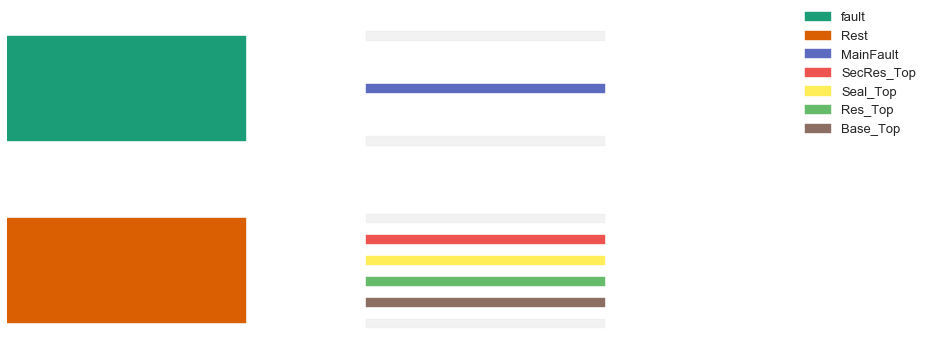

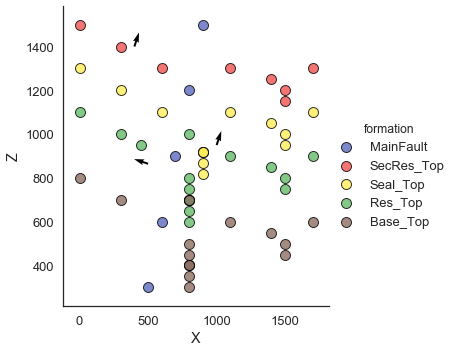

In [23]:
gp.set_series(geo_data, {"fault":'MainFault', 
                      "Rest":('Base_Top', 'Res_Top', 'Seal_Top', 'SecRes_Top')},
                       order_series = ["fault","Rest",], order_formations=['MainFault', 
                                         'SecRes_Top', 'Seal_Top', 'Res_Top','Base_Top',
                                         ])

gp.plot_data(geo_data)

In [24]:
# Creating a row label 'fault side' to distinguish between footwall (FW) and hanging wall (HW)
geo_data.interfaces['fault side'] = 'nan'
HW_border = 1300 # distance of middle of fault (border HW/FW) from footwall border of model
                # (X = 2000 - 1300 = 700)
nonfault_cond = geo_data.interfaces['formation'] != 'MainFault'
fault_cond = geo_data.interfaces['formation'] == 'MainFault'

fw_x_cond = geo_data.interfaces['X'] > (geo_data.extent[:2][1] - HW_border) # condition for FW points

hw_x_cond = geo_data.interfaces['X'] < (geo_data.extent[:2][1] - HW_border) # condition for HW points

geo_data.interfaces.set_value(fw_x_cond,'fault side','footwall') # setting FW
geo_data.interfaces.set_value(hw_x_cond,'fault side','hanging wall') #setting HW
geo_data.interfaces.set_value(fault_cond,'fault side','nan'); # reverting fault points to 'nan'

In [25]:
# INTERPOLATION
interp_data = gp.InterpolatorInput(geo_data, 
                                   u_grade = [3, 3, 3],
                                   compile_theano=True, dtype ='float64')

Level of Optimization:  fast_run
Device:  cpu
Precision:  float64


In [26]:
# COMPUTATION OF THE MODEL
lith_sol, fault_sol = gp.compute_model(interp_data)

In [27]:
# Arrays to hold the original compuation of the model
# These is used in case of computation failure (singular matrix) during modeling under uncertainty
lith_holder = lith_sol
fault_holder = fault_sol
interp_holder = interp_data

In [28]:
# CREATING SURFACES FOR LAYERS
base_surf, base_surf_simp = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], potential_fault=fault_sol[1], n_formation = (interp_data.get_formation_number()['Base_Top']))
res_surf, res_surf_simp = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], potential_fault=fault_sol[1], n_formation = (interp_data.get_formation_number()['Res_Top']))
seal_surf, seal_surf_simp = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], potential_fault=fault_sol[1], n_formation = (interp_data.get_formation_number()['Seal_Top']))
sec_res_surf, sec_res_surf_simp = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], potential_fault=fault_sol[1], n_formation = (interp_data.get_formation_number()['SecRes_Top']))
#fault_surf, fault_surf_simp = gp.get_surfaces(interp_data = interp_data, potential_lith=lith_sol[1], potential_fault=fault_sol[1], n_formation = (interp_data.get_formation_number()['MainFault']))

In [29]:
plot_3Dpoints = False
plot_3Dsurf = False

if plot_3Dpoints:
    # 3D plot points in VTK
    gp.plot_data_3D(geo_data)
elif plot_3Dsurf:
    # 3D plot points and surfaces in VTK
    gp.plot_surfaces_3D(geo_data, [base_surf, sec_res_surf, seal_surf, res_surf], 
                    [base_surf_simp, sec_res_surf_simp, seal_surf_simp, res_surf_simp], plot_data=False
                   )

In [30]:
#export = True
#
#if export:
#    gp.export_vtk_rectilinear(geo_data, np.ascontiguousarray(lith_sol[0]), path="original model")

In [31]:
# DECLARING SOME MODEL VARIABLES
resolution = geo_data.resolution[1] #resolution, standard: 50
model_size = geo_data.extent[:2][1] # 'real' model extent, here: 2000 m - cubic (what if not cubic?)
scale_factor = (model_size/resolution) # scale factor used for calculating voxel volumes in [m]
                                        # here: 2000/50 = 40
rescale_f = interp_data.rescaling_factor # rescaling factor from geo_data to interp_data

minmax_buffer = True # buffer around local min and max values [on/off] - not used atm

SSF_c = 3

C:\Users\Fabian\Anaconda3\lib\site-packages\gempy\Visualization.py:253: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  im = plt.imshow(plot_block[_a, _b, _c].T, origin="bottom", cmap=self._cmap, norm=self._norm,


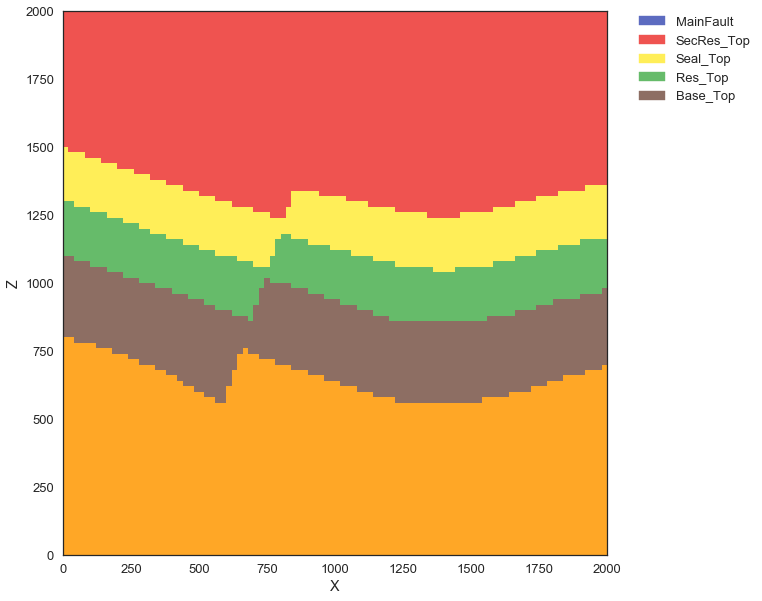

In [32]:
#%matplotlib notebook
%matplotlib inline
figsize(20,10)
gp.plot_section(geo_data, lith_sol[0], resolution/2, plot_data=0)

In [33]:
# FUNCTION TO FIND ANTICLINAL SPILL POINT AND CROSS-FAULT LEAK POINT

    #@staticmethod # possibly use to find saddle points!
    #def squared_euclidean_distances(x_1, x_2):
    #    """
    #    Compute the euclidian distances in 3D between all the points in x_1 and x_2
    #    Args:
    #        x_1 (theano.tensor.matrix): shape n_points x number dimension
    #        x_2 (theano.tensor.matrix): shape n_points x number dimension
#
    #    Returns:
    #        theano.tensor.matrix: Distancse matrix. shape n_points x n_points
    #    """
#
    #    # T.maximum avoid negative numbers increasing stability
    #    sqd = T.sqrt(T.maximum(
    #        (x_1**2).sum(1).reshape((x_1.shape[0], 1)) +
    #        (x_2**2).sum(1).reshape((1, x_2.shape[0])) -
    #        2 * x_1.dot(x_2.T), 0
    #    ))
#
    #    return sqd

def spill_leak_P(interp_data, res_surf, lith, fault, print_figures=False):    
    
    # creating a grid with uniform distances for vertices of the reservoir surface
    grid_x, grid_y = np.meshgrid(np.unique(interp_data.geo_data_res.grid.grid[:, 0]),
                             np.unique(interp_data.geo_data_res.grid.grid[:, 1]))

    grid_x=(grid_x*rescale_f)-(np.min(grid_x)*rescale_f)
    grid_y=(grid_y*rescale_f)-(np.min(grid_y)*rescale_f)
    
    grid_z0 = griddata(res_surf[:,:2], res_surf[:,2],
                       (grid_x, grid_y), method='linear')
    
    # order of values that serve to find relative extrema (min/max)
    rel_order_maxX = 5
    rel_order_maxY = 10
    rel_order_minX = 5
    rel_order_minY = 5
    
    # check grid_z0 for max and min in directions x and y
    # direction X
    minX1,minX2 = argrelextrema(grid_z0,np.less,order=rel_order_minX,axis=1)
    maxX1,maxX2 = argrelextrema(grid_z0,np.greater,order=rel_order_maxX,axis=1)
    grid_minX = np.zeros_like(grid_z0)
    grid_minX[minX1,minX2]=1           # grid of min in X
    grid_maxX = np.zeros_like(grid_z0)
    grid_maxX[maxX1,maxX2]=1           # grid of max in X
    
    #direction Y
    minY1,minY2 = argrelextrema(grid_z0,np.less,order=rel_order_minY,axis=0)
    maxY1,maxY2 = argrelextrema(grid_z0,np.greater,order=rel_order_maxY,axis=0)
    grid_minY = np.zeros_like(grid_z0)
    grid_minY[minY1,minY2]=1           # grid of min in Y
    grid_maxY = np.zeros_like(grid_z0)
    grid_maxY[maxY1,maxY2]=1           # grid of max in Y
    
    # fault leak line: defining line of juxtaposition, point of cross-fault leakage to be found on it
    # check for minima line that is on hanging wall side compared to max contact of layer top with fault
    fault_max_line_bool = np.copy(grid_maxX)
    fault_max_line = fault_max_line_bool.argmax(axis=1)
    fault_max = np.max(fault_max_line) # max of fault-layer contact as threshold        
    fleak_line = np.copy(grid_minX).astype(int)
    fleak_line[:,fault_max:]=0 # only returns minima at hanging wall side
    
    # minmax buffering - not used atm
    # supposed to set neighboring values of min and max to min and max respectively, too 
    if minmax_buffer:
        minXroll1 = np.logical_or(grid_minX,np.roll(grid_minX,1, axis=0))
        minXroll1[:,:fault_max] = 0
        minXroll2 = np.logical_or(grid_minX,np.roll(grid_minX,-1, axis=0))
        minXroll2[:,:fault_max] = 0
        minXbuffer = np.logical_or(minXroll1, minXroll2)
        grid_minX = np.logical_or(grid_minX, minXbuffer)
        #grid_maxX = np.logical_or(grid_maxX,np.roll(grid_maxX,1))
        #grid_maxX = np.logical_or(grid_maxX,np.roll(grid_maxX,-1))
        #grid_minY = np.logical_or(grid_minY,np.roll(grid_minY,1))
        #grid_minY = np.logical_or(grid_minY,np.roll(grid_minY,-1))
        grid_maxY = np.logical_or(grid_maxY,np.roll(grid_maxY,1, axis=1))
        grid_maxY = np.logical_or(grid_maxY,np.roll(grid_maxY,-1, axis=1))
    
    #check for saddle points
    saddle_p1 = np.logical_and(grid_minX,grid_maxY)
    saddle_p2 = np.logical_and(grid_minY,grid_maxX)
    saddle_p_all= np.logical_or(saddle_p1, saddle_p2)
    
    # this should find saddle points relative to X and Y directions
    # problem of finding other points in a rotated direction?
    
    #fleak_line_z0 = grid_z0[fleak_line]
    #leak_max = fleak_line==np.nanargmax(fleak_line_z0)
    #print(np.nanargmax(fleak_line_z0))
    ### NOT FINISHED: DEFINE LEAK POINT OVER LEAK LINE MAX?
    
    # distinguish anticlinal spill points from fault leak points:
    pot_leak_points = np.logical_and(fleak_line,saddle_p_all)    
    pot_spill_points = saddle_p_all - pot_leak_points    # substracting leak bool from saddle point bool 
                                                    # to get spill point bool    
    # leak and spill point 3D coordinates
    # LEAK POINT
    #if juxtaposition_over_seal(lith, fault) == True: #check for juxtaposition with layers above seal (due to offset)
    
    pot_leak_Xcoord = grid_x[pot_leak_points]
    pot_leak_Ycoord = grid_y[pot_leak_points]
    pot_leak_Zcoord = grid_z0[pot_leak_points]    
    pot_leak_3Dcoord = np.array(list(zip(pot_leak_Xcoord, pot_leak_Ycoord, pot_leak_Zcoord)))
        
    if pot_leak_3Dcoord.size == 0:
        fault_leak_3Dcoord = np.array([]) # if no leak coordinates found, set to empty array
    else:
        max_leak_pos = pot_leak_3Dcoord[:,2].argmax(axis=0)
        fault_leak_3Dcoord = pot_leak_3Dcoord[max_leak_pos,:] # max is LP
        
    # SPILL POINT
    pot_spill_Xcoord = grid_x[pot_spill_points]
    pot_spill_Ycoord = grid_y[pot_spill_points]
    pot_spill_Zcoord = grid_z0[pot_spill_points]    
    pot_spill_3Dcoord = np.array(list(zip(pot_spill_Xcoord, pot_spill_Ycoord, pot_spill_Zcoord)))
    
    if pot_spill_3Dcoord.size == 0:
        anticline_spill_3Dcoord = np.array([]) # if no leak coordinates found, set to empty array
    else:
        max_spill_pos = pot_spill_3Dcoord[:,2].argmax(axis=0)
        anticline_spill_3Dcoord = pot_spill_3Dcoord[max_spill_pos,:] # max is SP
        
    #print('SP',anticline_spill_3Dcoord)
    #print('LP',fault_leak_3Dcoord)
    
    # PLOTTING (for visualization and checking)
    # plot of min/max bools and all potential LPs(+) and SPs(x):
    if print_figures==True:
        figsize(15,6)
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        #ax.scatter(grid_x, grid_y, grid_z0, c="b", alpha = 0.1)
        ax.scatter(grid_x, grid_y, grid_minY, c="b", alpha = 0.1)
        ax.scatter(grid_x, grid_y, grid_maxY, c="r", alpha = 0.1)
        ax.scatter(grid_x, grid_y, grid_minX, c="b", alpha = 0.1)
        ax.scatter(grid_x, grid_y, grid_maxX, c="r", alpha = 0.1)
        ax.scatter(grid_x, grid_y, pot_spill_points, c="black", alpha = 1, marker='x', s = 250)
        ax.scatter(grid_x, grid_y, pot_leak_points, c="black", alpha = 1, marker='+', s = 250)
        #ax.scatter(grid_x, grid_y, fleak_line, c="b", alpha = 1, marker='+', s= 250)
        #ax.scatter(grid_x, grid_y, leak_max[2], c="g", alpha = 1, marker='+', s= 250)
        
        ax.set_xlabel('X Label')
        ax.set_ylabel('Y Label')
        ax.set_zlabel('Z Label')
        
        plt.show()
    
        # plot of reservoir top surface and position of all potential LPs(+) and SPs(x):
        plot_spill_leak(res_surf, pot_spill_points, anticline_spill_3Dcoord, fault_leak_3Dcoord, grid_x, grid_y, grid_z0)
    
    return anticline_spill_3Dcoord, fault_leak_3Dcoord

In [34]:
# LITHOLOGY BLOCK MASKING FUNCTIONS

# Masking function that confines to voxels which are part fo the reservoir formation,
# in the footwall side and above the z-horizontal defined by the spill or leak point
def res_mask(lith,fault, bottom_z, formation_nr):
    mask = np.ones_like(lith)
    mask[~formation_nr] = False
    mask[fault.astype(bool)] = False
    bottom_z = round((bottom_z/scale_factor)+0.5) # rounding up scale_factor or rescale_f?
    mask = mask.reshape(resolution,resolution,resolution) #(50,50,50)
    mask[:,:,:bottom_z] = False
    mask = mask.reshape(resolution**3,)
    return mask

def topo_analysis(lith, fault, fault_seal, seal_th):
    #fig = plt.figure()
    traps = []
    SSF = 0
    trap_control = 0
    # Padding of lith- and fault-block (creating border sections, formation number = 8)
    lith_pad = (np.pad(lith.reshape(resolution,resolution,resolution), 1, 'constant', constant_values = (8,8)))
    fault_pad = (np.pad(fault.reshape(resolution,resolution,resolution), 1, 'constant', constant_values = (8,8)))
    G, centroids, labels_unique, lith_to_labels_lot, labels_to_lith_lot, topo_block = \
    gp.topology_analyze(lith_pad, fault_pad, 1, areas_bool=False, return_block=True)
    # Finding sections which are possible traps in the reservoir (formation number = 7)
    trap_keys = [int(k) for k in lith_to_labels_lot["7"].keys()] # potential trap sections
    pad_keys = [int(p) for p in lith_to_labels_lot["8"].keys()] # model border sections
    secres_nr = interp_data.get_formation_number()['Seal_Top']
    over_nr = interp_data.get_formation_number()['SecRes_Top']
    res_nr = interp_data.get_formation_number()['Base_Top']
    base_keys = [int(b) for b in lith_to_labels_lot["0"].keys()]
    res_keys = [int(r) for r in lith_to_labels_lot["%s" % res_nr].keys()]
    secres_keys = [int(j) for j in lith_to_labels_lot["%s" % secres_nr].keys()] # sections in Secondary Reservoir
    over_keys = [int(o) for o in lith_to_labels_lot["%s" % over_nr].keys()] # section in Overlying
    tot_under_keys = np.append(res_keys, base_keys) # all sections that belong to underlying below seal
    tot_over_keys = np.append(secres_keys, over_keys) # all sections that belong to overlying above seal
    bool_block = np.zeros_like(topo_block)
    # If too many traps, model probably broken:
    print("NUMBER OF TRAPS", len(trap_keys))
    if len(trap_keys) > 10:
        trap_mask = bool_block[1:-1,1:-1,1:-1]
        SSF = 0
        trap_control = 0
        return trap_mask, SSF, trap_control
    else:
        # Check for each possible trap section, if it is connected to a border
        for tk in trap_keys:
            print('Checking Section:', tk)
            # Check for adjacency to model border
            if gp.topology_check_adjacency(G, tk, pad_keys[0]) == False:
                # Check for connection (juxtaposition!) to overlying layers (above seal) and SSF
                fault_seal_bool, SSF, trap_control = juxta_SSF_check(G, tk, res_keys, tot_under_keys, tot_over_keys, topo_block, seal_th)
                if fault_seal_bool == True:
                    traps.append(tk)
                    print('TRAP:', tk)
        if traps == []:
            print('No trap found! =(')
        else:
            for i in traps:
                # Creating a mask from the trap sections in the label block
                top_bool = topo_block == i
                bool_block[top_bool] = True
        # Removing padding
        trap_mask = bool_block[1:-1,1:-1,1:-1]
        return trap_mask, SSF, trap_control # this mask returns True for all voxels which were accepted as trap voxels

In [35]:
def juxta_SSF_check(G, tk, res_keys, tot_under_keys, tot_over_keys, topo_block, seal_th):
    throw = 0
    jp=0
    trap_c = 4
    # FIRST: check the adjacency area only for the trap: only the point of highest throw is relevant for SSF
    for tk in res_keys:
        for ok in tot_over_keys:  
            if gp.topology_check_adjacency(G, tk, ok) == True:
                if G.adj[tk][ok]['edge_type'] == 'stratigraphic':
                    print("Stratigraphic adjacency, leakage assumed!")
                    sealing = False
                    SSF = 0
                    trap_c = 4
                    return sealing, SSF, trap_c                     # stratigraphic adjancency assumed to always leak
                elif G.adj[tk][ok]['edge_type'] == 'fault':
                    trap_jshape = gp.Topology.compute_adj_shape(tk,ok,topo_block, ext=None)[3]
                    # fault throw at edge of trap section, voxels*scale_factor to get height in [m]
                    if trap_jshape !=0:
                        y_ext = trap_jshape[1]
                        z_ext = trap_jshape[2]
                        # finding point of greatest throw for trap --> relevant for total fault throw and SSF
                        # bottom of trap is flat, so need to find only highest z-values for juxtaposition:
                        z_max = max(z_ext)
                        # finding the y.axis range in which this highest throw appears:
                        y_range = y_ext[z_ext==z_max]
                        y_min = min(y_range)
                        y_max = max(y_range)
                        ## creating mask where values within this range = True --> to appl
                        #y_ext_bool = np.logical_and(y_ext>=y_min, y_ext<=y_max)
                        #y_bool_mask = np.copy(y_ext)
                        #y_bool_mask[~y_ext_bool] = False
                        #y_bool_mask[y_ext_bool] = True
                        ## the following can be used to find the throw height for one area
                        #y_bool = y_bool_mask==True
                        #print(z_ext[len_bool])
                        jp+=1
                        
    # SECOND: check for adjancencies between all seal-underlying and seal-overlying formations to
    # determine total fault throw at point/range defined over trap (y_bool)
    if jp != 0:
        for uk in tot_under_keys:
            for ok in tot_over_keys:  
                if gp.topology_check_adjacency(G, uk, ok) == True:
                    #print("Adjacency with section:", ok)
                    if G.adj[uk][ok]['edge_type'] == 'stratigraphic':
                        print("Stratigraphic adjacency, leakage assumed!")
                        sealing = False
                        SSF = 0
                        trap_c = 4
                        return sealing, SSF, trap_c     # stratigraphic adjancency assumed to always leak
                    elif G.adj[uk][ok]['edge_type'] == 'fault':
                        # get the array for z-extent for this adj-area, then mask to relevant range
                        section_jshape = gp.Topology.compute_adj_shape(uk,ok,topo_block, ext=None)[3]
                        if section_jshape != 0:
                            section_z_ext = section_jshape[2]
                            # creating mask where values within this range = True --> to appl
                            section_y_ext = section_jshape[1]
                            y_ext_bool = np.logical_and(section_y_ext>=y_min, section_y_ext<=y_max)
                            y_bool_mask = np.copy(section_y_ext)
                            y_bool_mask[~y_ext_bool] = False
                            y_bool_mask[y_ext_bool] = True
                            #print(y_min, y_max)
                            #print(section_y_ext)
                            if np.count_nonzero(y_bool_mask) != 0:
                                #print(section_z_ext)
                                #print(y_bool_mask)
                                # the following can be used to find the throw height for one area
                                y_bool = y_bool_mask==True
                                section_z_range = section_z_ext[y_bool]
                                #print(section_z_range)
                                # get the throw height:
                                z_len = max(section_z_range)-min(section_z_range)+1
                                # calculate throw in [m] for this adjacency and add to total
                                section_throw = z_len*scale_factor
                                throw += section_throw
                                print("Adding %s to throw, adjacency between %s and %s" % (section_throw, uk, ok))
                                jp+=1
    if jp == 0:
        print('No JP with any layer over seal.')
        SSF = 0
        sealing = True
        trap_c = 0
        return sealing, SSF, trap_c
    else:
        print('JP with layer over seal, checking SSF.')
        tot_fault_throw = throw + seal_th
        SSF = tot_fault_throw/seal_th
        print('SSF = %s / %s = %s' % (tot_fault_throw, seal_th, SSF))
        if SSF > SSF_c:
            print('SSF threshold exceeded, shale smear assumed to be incomplete.')
            sealing = False
            trap_c = 3
            return sealing, SSF, trap_c
        else: 
            print('SSF in confidence range, complete shale smear sealing assumed.')
            sealing = True
            trap_c = 0
            return sealing, SSF, trap_c
#def juxta_SSF_check(G, tk, tot_over_keys, topo_block, seal_th):
#    trap_throw = 0
#    jp=0
#    for ok in tot_over_keys:  
#        if gp.topology_check_adjacency(G, tk, ok) == True:
#            print("Adjacency with section:", ok)
#            if G.adj[tk][ok]['edge_type'] == 'stratigraphic':
#                print("Stratigraphic adjacency, leakage assumed!")
#                return False                         # stratigraphic adjancency assumed to always leak
#            elif G.adj[tk][ok]['edge_type'] == 'fault':
#                # fault throw at edge of trap section, voxels*scale_factor to get height in [m]
#                print("Fault edge adjacency! Analyse shape.")
#                section_throw = gp.Topology.compute_adj_shape(tk,ok,topo_block, ext=None)[2]*scale_factor
#                trap_throw += section_throw
#                print("Adding %s to throw, over_section: %s" % (section_throw, ok))
#                jp+=1
#    if jp == 0:
#        print('No JP with any layer over seal.')
#        return True
#    else:
#        print('JP with layer over seal, checking SSF.')
#        tot_fault_throw = trap_throw + seal_th
#        SSF = tot_fault_throw/seal_th
#        print('SSF = %s / %s = %s' % (tot_fault_throw, seal_th, SSF))
#        if SSF > SSF_c:
#            print('SSF threshold exceeded, shale smear assumed to be incomplete.')
#            return False
#        else: 
#            print('SSF ok, complete shale smear sealing assumed.')
#            return True
#            
# Shale Smear Factor SSF = Fault throw / Shale layer thickness
# SSF threshold = 7 --> incomplete shale smear to be expected for higher values
# SGR equivalent = 14%
# Shale Gouge Ratio SGR = (Sum(Shale bed thickness in throw)/Fault throw)*100%
# Attention: Need to count shale thickness into throw!
# From: Yielding et al. (1997)

In [36]:
# MAIN FUNCTION: Calculation of maximum fill volume in reservoir traps

def max_trap_vol(interp_data, lith, fault, res_surface, fault_sealing, seal_th):
    trap_control = 0 # intitiating variable that indicates what kind of mechanism controls the trap volume
                        # 0 = Unclear; 1 = Spill Point; 2 = Leak Point; 3 = Seal breach juxtaposition leakage;
                        # 4 = Stratigraphical adjacency leakage
    bottom_surface = np.ones_like(res_surface) # needed?   
    spill_point, leak_point = spill_leak_P(interp_data, res_surface, lith, fault, print_figures=False)
    print("SPILL POINT AT:", spill_point)
    print("LEAK POINT AT:", leak_point)
    #CHECK: ONLY CONTINUE IF SPILL POINT FOUND, ELSE RETURN ZERO TRAP VOLUME
    if spill_point.size == 0:
        spill_z = np.nan
        #print('No SPILL POINT found!')
        trap_vol = 0
        final_trap_mask = np.zeros_like(lith)
        return trap_vol, lith, bottom_surface, final_trap_mask    
    else:
        #print('SPILL POINT:',spill_point)
        spill_z = spill_point[2]
        #spill_z, spill_p, spill_min_line, spill_bottom = spill_point(res_surface)
        # calculate leak point
        if leak_point.size == 0:
            #print('No LEAK POINT found! So FULL LEAKAGE assumed!')
            #leak_z = np.nan
            leak_z = 2000
        else:
            #print('Leak Point:',leak_point)
            leak_z = leak_point[2]
        #leak_z, leak_p, leak_line, leak_bottom = leak_point(res_surface)
        
        # Check for "down-to" z-horizon, maximum depth of reservoir
        # Check for fault sealing and subsequent relevance of leak point
        max_z = np.nanmax([spill_z, leak_z])
        #if fault_sealing == True:
        #    if max_z == spill_z:
        #        print("Spill point defines trap.")
        #        print("Fault is sealing. Down to spill.")
        #        #bottom_surface = spill_bottom
        #    else:
        #        print("Fault leak point above spill point.")
        #        max_z = spill_z
        #        print("...but fault sealing. Down to spill.")
        #        #bottom_surface = spill_bottom
        #else:
        #    if max_z == spill_z:
        #        print("Spill point defines trap.")
        #        print("Fault is pathway. Down to spill.")
        #        #bottom_surface = spill_bottom
        #    else:
        #        print("Fault leak point above spill point.")
        #        print("Cross-fault leakage. Down to leak.")
        #        #bottom_surface = leak_bottom    
        if max_z == spill_z:
            trap_control = 1
        else:
            trap_control = 2                
        
        res_nr = interp_data.get_formation_number()['Base_Top']
        res_nr_bool = lith == res_nr
        pre_trap_mask = res_mask(lith, fault, max_z, res_nr_bool)
          
        # volume cells for counting
        vol_cells = 0      
        
        pre_trap_mask_bool = (pre_trap_mask == True)
        # Check if there is anaything in the reservoir mask at all
        if np.count_nonzero(pre_trap_mask_bool) == 0:
            print("No res_formation above max_z!")
            SSF = 0
            trap_control = 0
            return 0, lith, bottom_surface, pre_trap_mask, SSF, trap_control
        else:
            lith[pre_trap_mask_bool] = 7                           # setting reservoir above bottom on footwall side 
            final_trap_mask, SSF, trap_c = topo_analysis(lith, fault, fault_sealing, seal_th)
            if trap_c == 3:
                trap_control = trap_c
            elif trap_c == 4:
                trap_control = trap_c
            #lith[pre_trap_mask_bool] = 5
            lith[final_trap_mask] = 9                         # setting final trap to formation value = 9
            vol_cells = np.count_nonzero(final_trap_mask)
            
            #calulate volume from cells
            trap_vol = ((scale_factor)**3) * vol_cells 
            # revert to lith_block without any masks
            lith[pre_trap_mask_bool] = res_nr        
            #return the maximum reservoir volume
            return trap_vol, lith, bottom_surface, final_trap_mask, SSF, trap_control

In [37]:
# PLOTTING FUNCTIONS: Spill and leak point visualization
def plot_spill_leak(res_surface, pot_spills, spill_point, leak_point, grid_x, grid_y, grid_z0):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(grid_x, grid_y, grid_z0, c="b", alpha = 0.1)
    #ax.scatter(grid_x, grid_y,pot_spills, c="r", alpha = 1, marker='p', s = 250)
    if spill_point.size != 0:        
        ax.scatter(spill_point[0],spill_point[1],spill_point[2], c="black", alpha = 1, marker='x', s = 250)
    if leak_point.size != 0:        
        ax.scatter(leak_point[0],leak_point[1],leak_point[2], c="black", alpha = 1, marker='+', s = 250)
        
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    
    plt.show()

In [38]:
# for setting up postional conditions to determine thicknesses and the like:
fw_th_point = 900 # distance of test point for thickness from footwall border of model 
                  # (e.g.: X = 2000 - 900 = 1100)
HW_border = 1300 # distance of middle of fault (border HW/FW) from footwall border of model
                # (X = 2000 - 1300 = 700)

# SAVING ORIGINAL Z-VALUES (so they are not overwritten and can be used a base for every iteration)    
sec_res_z = interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'SecRes_Top']['Z']
seal_z = interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'Seal_Top']['Z']
res_z = interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'Res_Top']['Z']
base_z = interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'Base_Top']['Z']

#res_len = len(interp_data.geo_data_res.interfaces[interp_data.geo_data_res.interfaces['formation'] == 'Res_Top']['Z'])    

# SETTING Z-UNCERTAINTIES FOR EACH LAYER TOP
unc_f = 1
std_secres_top = 40 #* unc_f
std_seal_top = 60 #* unc_f
std_res_top = 80 #* unc_f
std_base_top = 100 #* unc_f
z_unc_secres_top = pymc.Normal('z_unc_secres_top', 0, 1./np.square(std_secres_top/rescale_f))
z_unc_seal_top = pymc.Normal('z_unc_seal_top', 0/rescale_f, 1./np.square(std_seal_top/rescale_f))
z_unc_res_top = pymc.Normal('z_unc_res_top', 0, 1./np.square(std_res_top/rescale_f))
z_unc_base_top = pymc.Normal('z_unc_base_top', 0, 1./np.square(std_base_top/rescale_f))

# SETTING FAULT OFFSET UNCERTAINTY
std_offset = 150
#offset_unc = pymc.Normal('offset_unc', 0/rescale_f, 1./np.square(std_offset/rescale_f))
# using SkewNormal, so that fault offset is much more like to vary to a higher offset and to stay as a normal fault
offset_unc = pymc.SkewNormal('offset_unc', 0/rescale_f, 1./np.square(std_offset/rescale_f), alpha=-2)

# FAULT SEALING UNCERTAINTY (p = probability of success (1 = True); True = fault sealing)
fault_sealing = pymc.Bernoulli('fault_sealing_unc',p=0)

In [39]:
# Boolean conditions to find data points for each formation
base_top_cond = interp_data.geo_data_res.interfaces['formation'] == 'Base_Top'
res_top_cond = interp_data.geo_data_res.interfaces['formation'] == 'Res_Top'
seal_top_cond = interp_data.geo_data_res.interfaces['formation'] == 'Seal_Top'
secres_top_cond = interp_data.geo_data_res.interfaces['formation'] == 'SecRes_Top'

# Footwall and hanging wall conditions
footwall = interp_data.geo_data_res.interfaces['fault side'] == 'footwall'
hanging_wall = interp_data.geo_data_res.interfaces['fault side'] == 'hanging wall'

# Combining hanging wall and formation conditions
HW_secres_top = np.logical_and(secres_top_cond,hanging_wall)
HW_seal_top = np.logical_and(seal_top_cond,hanging_wall)
HW_res_top = np.logical_and(res_top_cond,hanging_wall)
HW_base_top = np.logical_and(base_top_cond,hanging_wall)

#interp_data.geo_data_res.interfaces.set_value(HW_secres_top,'Z',25)

In [40]:
# PYMC MODEL FUNCTIONS 

# Updating of interp_data points with new z-values resulting from z-positional uncertainty
# and including offset uncertainty:
@pymc.deterministic
def interp_unc(value=0, z_unc_secres_top = z_unc_secres_top, z_unc_seal_top=z_unc_seal_top, 
                  z_unc_res_top = z_unc_res_top, z_unc_base_top = z_unc_base_top, off_unc=offset_unc):
    #print('CHECK0:', res_z)
    new_z_secres_top = sec_res_z + z_unc_secres_top
    new_z_seal_top = seal_z + z_unc_seal_top
    new_z_res_top = res_z + z_unc_res_top
    new_z_base_top = base_z + z_unc_base_top   
    
    # for offset uncertainty: additional change on hanging wall (HW): 
    HW_new_z_secres_top = new_z_secres_top + off_unc
    HW_new_z_seal_top = new_z_seal_top + off_unc
    HW_new_z_res_top = new_z_res_top + off_unc
    HW_new_z_base_top = new_z_base_top + off_unc

    print('Z variations top to bottom:', z_unc_secres_top*rescale_f, 
          z_unc_seal_top*rescale_f, z_unc_res_top*rescale_f, z_unc_base_top*rescale_f)
    
    print('Fault offset variation:', off_unc*rescale_f)
    #print('CHECK1:', new_z_res_top)
    #print('CHECK2:', HW_new_z_res_top)
    
    # FOOTWALL UNCERTAINTY
    interp_data.geo_data_res.interfaces.set_value(secres_top_cond,'Z',new_z_secres_top)
    interp_data.geo_data_res.interfaces.set_value(seal_top_cond,'Z',new_z_seal_top)
    interp_data.geo_data_res.interfaces.set_value(res_top_cond,'Z',new_z_res_top)
    interp_data.geo_data_res.interfaces.set_value(base_top_cond,'Z',new_z_base_top)
    
    # HANGING WALL UNCERTAINTY (incl. offset)
    interp_data.geo_data_res.interfaces.set_value(HW_secres_top,'Z',HW_new_z_secres_top)
    interp_data.geo_data_res.interfaces.set_value(HW_seal_top,'Z',HW_new_z_seal_top)
    interp_data.geo_data_res.interfaces.set_value(HW_res_top,'Z',HW_new_z_res_top)
    interp_data.geo_data_res.interfaces.set_value(HW_base_top,'Z',HW_new_z_base_top)
    
    #print('CHECK3:', interp_data.geo_data_res.interfaces)    
    return interp_data

# Calculating formation thickness based on z-difference between a bottom and top point on the footwall (fw)

# This is done using interp_data, where X,Y and Z-values are rescaled according to the rescaling_factor.
# Value[1] of extent_rescaled equals the maximum extent of model (here: 2000).
# So if we want to find the rescaled chosen X-position (here: 1100), 
# we simply calculate 2000-fw_th_point(here:900) rescaled (see fw_x)
# Y_mid defines that we are looking at a central position (in y-direction) in the model.
# The difference in z between two points has to be rescaled to the original scale again.
#rescale_f = interp_data.rescaling_factor

# Reservoir thickness
@pymc.deterministic
def res_th(interp_data=interp_unc):
    fw_x = interp_data.geo_data_res.interfaces['X'] == (interp_data.extent_rescaled['X'].values[1] - (fw_th_point/rescale_f))
    y_mid = interp_data.geo_data_res.interfaces['Y'] == (interp_data.extent_rescaled['Y'].values[1] - (1000/rescale_f))
    points_fw = interp_data.geo_data_res.interfaces[fw_x]
    points_fw = points_fw[y_mid] 
    fw_rb_z = points_fw[base_top_cond]['Z'].values*rescale_f
    fw_sb_z = points_fw[res_top_cond]['Z'].values*rescale_f
    return np.abs(fw_sb_z-fw_rb_z)

#Seal thickness
@pymc.deterministic
def seal_th(interp_data=interp_unc):
    fw_x = interp_data.geo_data_res.interfaces['X'] == (interp_data.extent_rescaled['X'].values[1] - (fw_th_point/rescale_f))
    y_mid = interp_data.geo_data_res.interfaces['Y'] == (interp_data.extent_rescaled['Y'].values[1] - (1000/rescale_f))
    points_fw = interp_data.geo_data_res.interfaces[fw_x]
    points_fw = points_fw[y_mid] 
    fw_r2b_z = points_fw[seal_top_cond]['Z'].values*rescale_f
    fw_sb_z = points_fw[res_top_cond]['Z'].values*rescale_f
    return np.abs(fw_r2b_z-fw_sb_z)

# Secondary reservoir thickness
@pymc.deterministic
def sec_res_th(interp_data=interp_unc):
    fw_x = interp_data.geo_data_res.interfaces['X'] == (interp_data.extent_rescaled['X'].values[1] - (fw_th_point/rescale_f))
    y_mid = interp_data.geo_data_res.interfaces['Y'] == (interp_data.extent_rescaled['Y'].values[1] - (1000/rescale_f))
    points_fw = interp_data.geo_data_res.interfaces[fw_x]
    points_fw = points_fw[y_mid] 
    fw_r2b_z = points_fw[seal_top_cond]['Z'].values*rescale_f
    fw_ob_z = points_fw[secres_top_cond]['Z'].values*rescale_f
    return np.abs(fw_ob_z-fw_r2b_z)             

# Volumetric calculation 
@pymc.deterministic
def structural_model(interp_data_M=interp_unc, fault_sealing=fault_sealing, seal_th=seal_th,
                     lh=lith_holder, fh=fault_holder, idh=interp_holder, print_figures=False):
    #print('Fault sealing =', fault_sealing)
    try:
        lith_sol, fault_sol = gp.compute_model(interp_data_M)
        lith_block = lith_sol[0]
        fault_block = fault_sol[0]  
        res_top_surf, res_top_surf_simp = gp.get_surfaces(
                                              interp_data = interp_data_M, potential_lith=lith_sol[1], 
            potential_fault=fault_sol[1], n_formation = interp_data.get_formation_number()['Res_Top'])
        max_vol, lith_sol[0], bottom, trap, SSF, trap_control = max_trap_vol(interp_data_M, lith_block, fault_block, res_top_surf, fault_sealing, seal_th)
        print("Maximum trap volume: %s m³" % max_vol)
        if print_figures:
            gp.plot_section(geo_data, lith_sol[0], resolution/2, plot_data =0)
            #gp.plot_section(geo_data, trap, resolution/2, plot_data =0)
        # revert lith_block back to formation numbers only (or can I include trap in plot?)
        
        #return lith_sol, fault_sol, max_vol, trap, SSF, trap_control
        return max_vol, SSF, trap_control
    except np.linalg.linalg.LinAlgError as err:
        # In case of LinAlgError, use original model
        print('LinAlgError occurred!')
        lith_sol = lh
        fault_sol = fh
        lith_block = lith_sol[0]
        fault_block = fault_sol[0] 
        res_top_surf, res_top_surf_simp = gp.get_surfaces(
                                              interp_data = idh, potential_lith=lith_sol[1], 
            potential_fault=fault_sol[1], n_formation = interp_data.get_formation_number()['Res_Top'])
        max_vol, lith_sol[0], bottom, trap, SSF, trap_control = max_trap_vol(idh, lith_block, fault_block, res_top_surf, fault_sealing, seal_th)
        print("Maximum trap volume: %s m³" % max_vol)
        #return lith_sol, fault_sol, max_vol, trap, SSF, trap_control
        return max_vol, SSF, trap_control
    
    ### RETURN INDICES:
    ### 0 = lith_sol
    ### 1 = fault_sol
    ### 2 = max_vol (maximum trap volume)
    ### 3 = trap (block)
    ### 4 = SSF (Shale Smear Factor)
    ### 5 = trap_control (controling mechanism for max trap volume)
    
# Check juxtaposition area with layers above seal
#@pymc.deterministic
#def over_jux_area(lith_sol=structural_model[0], fault_sol=structural_model[1]):
#    lith = lith_sol[0].reshape(resolution,resolution,resolution)
#    fault = fault_sol[0].reshape(resolution,resolution,resolution)
#    area = 0
#    G, centroids, labels_unique, lith_to_labels_lot, labels_to_lith_lot = \
#    gp.topology_analyze(lith, fault, 1, areas_bool=True, return_block=False)
#    res_nr = interp_data.get_formation_number()['Base_Top']
#    secres_nr = interp_data.get_formation_number()['Seal_Top']
#    over_nr = interp_data.get_formation_number()['SecRes_Top']
#    res_keys = [int(r) for r in lith_to_labels_lot["%s" % res_nr].keys()]
#    secres_keys = [int(j) for j in lith_to_labels_lot["%s" % secres_nr].keys()] # sections in Secondary Reservoir
#    over_keys = [int(o) for o in lith_to_labels_lot["%s" % over_nr].keys()] # section in Overlying
#    tot_over_keys = np.append(secres_keys, over_keys) # all sections that belong to overlying above seal
#    for rk in res_keys:
#        for ok in tot_over_keys:
#            if gp.topology_check_adjacency(G, rk, ok) == True:
#                    if G.adj[rk][ok]['edge_type'] == 'fault':
#                        part_area = G.adj[rk][ok]['area']*(scale_factor**2)
#                        area += part_area
#    return area       
                
# Avoid layer inversion by giving negative thicknesses a likelihood of zero
#@pymc.deterministic
#def no_inversion(sec_res_th=sec_res_th, res_th=res_th, seal_th=seal_th)

Z variations top to bottom: 23.1749019422 3.16041067435 16.0351710206 38.6798835781
Fault offset variation: -161.952589258


C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:80: UserWarning: Boolean Series key will be reindexed to m

SPILL POINT AT: [ 1373.73742676   929.29290771   858.66205997]
LEAK POINT AT: [ 606.06060791  949.49493408  722.15326289]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [287.12523965373225] / [187.12523965373225] = [1.5344014531927708]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23176000.0 m³


In [21]:
iterations = 1000

In [22]:
model = pymc.Model([interp_unc, z_unc_res_top, z_unc_base_top, z_unc_seal_top, z_unc_secres_top, offset_unc, fault_sealing, structural_model, res_th, seal_th, sec_res_th])
#model = pymc.Model([interp_unc, z_unc_res_top, z_unc_base_top, z_unc_seal_top, z_unc_secres_top, offset_unc, fault_sealing, structural_model, res_th, seal_th, sec_res_th, over_jux_area])

In [23]:
#M = pymc.MCMC(model)
M = pymc.MCMC(model,db= "hdf5" , dbname= "D:/PyMC_DataBase/prior_model_noBlocks_SSFc_3_1000iter_2017_11_12")
M.sample(iter=iterations)

Z variations top to bottom: -25.8664175729 41.9355727759 -23.8993324074 111.682946498
Fault offset variation: -91.4122129295


C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:80: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:98: DeprecationWarning: numpy boolean subtract, the `-` op

SPILL POINT AT: [ 1373.73742676   929.29290771   819.07133424]
LEAK POINT AT: [ 626.26263428  949.49493408  750.20978172]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23792000.0 m³
 [                  0%                  ] 2 of 1000 complete in 15.9 sec

C:\Users\Fabian\Anaconda3\lib\site-packages\pymc\database\hdf5.py:485: UserWarning: 
Error tallying interp_unc, will not try to tally it again this chain.
Did you make all the samevariables and step methods tallyable
as were tallyable last time you used the database file?

Error:

Traceback (most recent call last):
  File "C:\Users\Fabian\Anaconda3\lib\site-packages\pymc\database\hdf5.py", line 475, in tally
    self._traces[name].tally(chain)
  File "C:\Users\Fabian\Anaconda3\lib\site-packages\pymc\database\hdf5.py", line 64, in tally
    self._vlarrays[chain].append(self._getfunc())
  File "C:\Users\Fabian\Anaconda3\lib\site-packages\tables\vlarray.py", line 519, in append
    sequence = atom.toarray(sequence)
  File "C:\Users\Fabian\Anaconda3\lib\site-packages\tables\atom.py", line 1086, in toarray
    buffer_ = self._tobuffer(object_)
  File "C:\Users\Fabian\Anaconda3\lib\site-packages\tables\atom.py", line 1220, in _tobuffer
    return six.moves.cPickle.dumps(object_, six.moves.cP

Z variations top to bottom: -8.87172460934 95.6426071255 77.861318128 -32.9219737461
Fault offset variation: -76.3492298579
SPILL POINT AT: [ 1393.93945312   929.29290771   920.36669614]
LEAK POINT AT: [ 666.66668701  949.49493408  868.51413054]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 15808000.0 m³
 [                  0%                  ] 3 of 1000 complete in 24.2 secZ variations top to bottom: -16.9085604221 74.6462443329 -42.5464853009 -14.1779899427
Fault offset variation: 112.186455005


C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


SPILL POINT AT: [ 1353.53540039   929.29290771   800.63071508]
LEAK POINT AT: [ 686.86871338  969.69696045  948.46238765]
NUMBER OF TRAPS 1
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Maximum trap volume: 80000.0 m³
 [                  0%                  ] 4 of 1000 complete in 32.3 secZ variations top to bottom: -15.5856023334 -5.20066153703 60.3947820924 37.3202935831
Fault offset variation: -151.340532751
SPILL POINT AT: [ 1373.73742676   929.29290771   902.63707703]
LEAK POINT AT: [ 626.26263428  949.49493408  770.22483449]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [294.40455637059131] / [134.40455637059131] = [2.1904358328361639]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 16944000.0 m³
 [                  0%                  ] 5 of 1000 complete in 40.6 secZ variations top to bottom: -45.6274720525 15.8

SPILL POINT AT: [ 1373.73742676   929.29290771   912.23951665]
LEAK POINT AT: [ 646.46466064  949.49493408  793.57132151]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [280.68340320494804] / [240.68340320494804] = [1.1661934286592208]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19600000.0 m³
 [                  1%                  ] 18 of 1000 complete in 148.3 secZ variations top to bottom: -8.67850249214 152.153840155 -42.4289542663 -81.7227923931
Fault offset variation: 37.983040129
SPILL POINT AT: [ 1353.53540039   929.29290771   800.65117647]
LEAK POINT AT: [ 666.66668701  949.49493408  880.80310615]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 3240000.0 m³
 [                  1%                  ] 19 of 1000 complete in 156.5 secZ variations top to bo

SPILL POINT AT: [ 1353.53540039   929.29290771   737.17824917]
LEAK POINT AT: [ 545.45452881  949.49493408  536.96665937]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
Adding 220.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [535.31543068938686] / [215.31543068938686] = [2.4861916722616626]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23216000.0 m³
 [-                 3%                  ] 33 of 1000 complete in 271.9 secZ variations top to bottom: -22.2266793315 17.3924617574 97.753839931 5.0553722642
Fault offset variation: -97.318092545
SPILL POINT AT: [ 1373.73742676   929.29290771   939.82507299]
LEAK POINT AT: [ 666.66668701  949.49493408  858.15344413]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [259.63862182642993] / [119.63862182642993] = [2.17

 [-                 4%                  ] 47 of 1000 complete in 387.3 secZ variations top to bottom: -13.3950472396 -41.0656857852 -39.5074436494 237.943218238
Fault offset variation: -190.192519628
SPILL POINT AT: [ 1353.53540039   929.29290771   803.71476199]
LEAK POINT AT: [ 585.85858154  949.49493408  654.62729234]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
Adding 260.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [478.44175786419214] / [198.44175786419214] = [2.4109933464287492]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 5472000.0 m³
 [-                 4%                  ] 48 of 1000 complete in 395.7 secZ variations top to bottom: 0.506397636543 -58.9616486992 59.8503980325 -267.368492929
Fault offset variation: 10.0571743808
SPILL POINT AT: [ 1373.73742676   929.29290771   902.2317072 ]
LEAK POINT AT: [ 686.86871338  969.696960

 [--                6%                  ] 61 of 1000 complete in 502.5 secZ variations top to bottom: 37.2542704783 -1.85356245193 83.3977986703 -49.2207111092
Fault offset variation: -117.283662619
SPILL POINT AT: [ 1373.73742676   929.29290771   925.62954869]
LEAK POINT AT: [ 646.46466064  949.49493408  824.85451574]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [274.74863887777178] / [114.74863887777178] = [2.3943520512729495]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 17616000.0 m³
 [--                6%                  ] 62 of 1000 complete in 510.7 secZ variations top to bottom: -27.3650901641 28.6910872695 -74.5999027744 -6.62437019128
Fault offset variation: -93.2704333662
SPILL POINT AT: [ 1353.53540039   929.29290771   768.74055749]
LEAK POINT AT: [ 606.06060791  949.49493408  709.76169705]
NUMBER OF TRAPS 2
Checking Se

NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [257.23752484951433] / [177.23752484951433] = [1.4513716836653241]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22512000.0 m³
 [--                7%                  ] 76 of 1000 complete in 626.4 secZ variations top to bottom: -51.793255432 52.1488258031 13.3986691102 19.2825676849
Fault offset variation: -130.935615291
SPILL POINT AT: [ 1373.73742676   929.29290771   856.10424925]
LEAK POINT AT: [ 626.26263428  949.49493408  746.72536161]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [278.75015669292065] / [238.75015669292065] = [1.1675391570588489]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22264000.0 m³
 [--                7%     

 [---               8%                  ] 89 of 1000 complete in 734.3 secZ variations top to bottom: -30.0166646795 -81.3162925985 32.970440114 18.4112121124
Fault offset variation: 94.1575028298
SPILL POINT AT: [ 1373.73742676   929.29290771   875.27469749]
LEAK POINT AT: [ 707.07067871  969.69696045  980.16453599]
NUMBER OF TRAPS 1
Checking Section: 11
No JP with any layer over seal.
TRAP: 11
Maximum trap volume: 952000.0 m³
 [---               9%                  ] 90 of 1000 complete in 742.4 secZ variations top to bottom: -26.5292386139 -50.1899460662 54.9421299395 -53.2029844367
Fault offset variation: -164.83441381
SPILL POINT AT: [ 1373.73742676   949.49493408   897.06428883]
LEAK POINT AT: [ 626.26263428  949.49493408  750.4876677 ]
NUMBER OF TRAPS 2
Checking Section: 11
Unable to calculate an adjacency area.
Adding 200.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [294.86792399422802] / [94.867923994

 [---              10%                  ] 103 of 1000 complete in 860.0 secZ variations top to bottom: 28.6672225783 13.4738848728 -56.1091834783 142.187253057
Fault offset variation: -219.449691466
SPILL POINT AT: [ 1353.53540039   929.29290771   787.00048677]
LEAK POINT AT: [ 585.85858154  949.49493408  611.7278466 ]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [349.58306835105873] / [269.58306835105873] = [1.296754542076143]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 17856000.0 m³
 [---              10%                  ] 104 of 1000 complete in 868.4 secZ variations top to bottom: -2.53125847833 25.1626398319 16.3844727907 59.0749536404
Fault offset variation: -91.9527713965
SPILL POINT AT: [ 1373.73742676   929.29290771   859.09685524]
LEAK POINT AT: [ 646.46466064  949.49493408  787.782

NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [265.11560231624185] / [245.11560231624185] = [1.0815941531710271]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19264000.0 m³
 [----             13%                  ] 130 of 1000 complete in 1085.1 secZ variations top to bottom: -15.4891556707 152.347951034 65.6946360317 99.7871324101
Fault offset variation: -33.8273141134
SPILL POINT AT: [ 1373.73742676   929.29290771   908.06678005]
LEAK POINT AT: [ 666.66668701  949.49493408  899.96511368]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 17776000.0 m³
 [----             13%                  ] 131 of 1000 complete in 1093.3 secZ variations top to bottom: -7.12475003704 37.0842883233 -14.1477750983 35.7440336637
Fault offset variation: -68.8329968706
SPILL POINT AT

 [-----            14%                  ] 144 of 1000 complete in 1201.9 secZ variations top to bottom: 63.6307273238 -82.3622254169 -117.34150574 -34.2150268438
Fault offset variation: -19.5603084134
SPILL POINT AT: [ 1353.53540039   929.29290771   726.78843726]
LEAK POINT AT: [ 626.26263428  949.49493408  738.15849045]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22784000.0 m³
 [-----            14%                  ] 145 of 1000 complete in 1210.1 secZ variations top to bottom: -3.52063938428 -57.9934356083 -12.3609149177 74.9938231992
Fault offset variation: -218.998792589
SPILL POINT AT: [ 1373.73742676   949.49493408   830.26401776]
LEAK POINT AT: [ 585.85858154  949.49493408  646.80307495]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 180.0 to throw, adjacency between 8 and 5
Adding 20.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [354.36747930945853] / [154.36747930

SPILL POINT AT: [ 1393.93945312   949.49493408   938.64992454]
LEAK POINT AT: [ 686.86871338  949.49493408  919.90822359]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [190.21987987723492] / [30.219879877234916] = [6.2945279944851924]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [------           15%                  ] 159 of 1000 complete in 1325.6 secZ variations top to bottom: 1.13261772707 69.147366919 -7.02953090289 -13.7098250422
Fault offset variation: -88.3187896909
SPILL POINT AT: [ 1353.53540039   929.29290771   835.9131927 ]
LEAK POINT AT: [ 626.26263428  949.49493408  776.78032514]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22824000.0 m³
 [------           16%                  ] 160 of 1000 complete in 1333.7 secZ variations to

Adding 280.0 to throw, adjacency between 8 and 6
Adding 160.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [815.02391671832243] / [95.023916718322425] = [8.5770398112959523]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [------           17%                  ] 174 of 1000 complete in 1446.7 secZ variations top to bottom: -37.6150697168 -12.4496072472 43.9608825946 -187.428933378
Fault offset variation: -318.655558892
SPILL POINT AT: [ 1373.73742676   929.29290771   886.32242946]
LEAK POINT AT: [ 585.85858154  949.49493408  611.24242687]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 300.0 to throw, adjacency between 8 and 5
Adding 140.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [583.58951015821503] / [143.58951015821503] = [4.0642906958536393]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No tr

 [-------          18%                  ] 187 of 1000 complete in 1554.7 secZ variations top to bottom: -26.4896291898 59.7846684784 62.5887291097 -164.416071923
Fault offset variation: 41.247784135
SPILL POINT AT: [ 1373.73742676   929.29290771   905.32093256]
LEAK POINT AT: [ 707.07067871  969.69696045  974.92457082]
NUMBER OF TRAPS 2
Checking Section: 11
No JP with any layer over seal.
TRAP: 11
Checking Section: 13
Maximum trap volume: 4952000.0 m³
 [-------          18%                  ] 188 of 1000 complete in 1562.9 secZ variations top to bottom: -47.8446014718 -3.78898607291 -41.417938784 -197.527583984
Fault offset variation: -142.088312139
SPILL POINT AT: [ 1353.53540039   929.29290771   801.41736182]
LEAK POINT AT: [ 606.06060791  949.49493408  692.40450064]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [277.6289527110921] / [237.6289527110921] = [1.1683296565660153]
SSF in confidence range

 [--------         21%                  ] 216 of 1000 complete in 1817.9 secZ variations top to bottom: -26.9068419098 -61.2824270133 -65.2005628266 -89.1156592276
Fault offset variation: -71.3541919742
SPILL POINT AT: [ 1353.53540039   929.29290771   778.07752168]
LEAK POINT AT: [ 626.26263428  949.49493408  735.00330131]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25808000.0 m³
 [--------         21%                  ] 217 of 1000 complete in 1826.4 secZ variations top to bottom: -57.8018994243 13.6476006747 101.814090503 -51.2004003657
Fault offset variation: -37.1691965351
SPILL POINT AT: [ 1373.73742676   929.29290771   943.92330233]
LEAK POINT AT: [ 686.86871338  969.69696045  922.17591961]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [191.83351017154769] / [111.83351017154769] =

 [--------         23%                  ] 230 of 1000 complete in 1934.2 secZ variations top to bottom: 41.1202260223 -6.06216694252 -4.83731869001 259.725670949
Fault offset variation: -213.662833922
SPILL POINT AT: [ 1353.53540039   929.29290771   837.8794911 ]
LEAK POINT AT: [ 606.06060791  949.49493408  666.55611623]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
Adding 280.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [498.77515174749033] / [198.77515174749033] = [2.5092429680602053]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 9256000.0 m³
 [--------         23%                  ] 231 of 1000 complete in 1942.4 secZ variations top to bottom: -47.3683547385 -102.607385353 29.8566876976 26.8817901964
Fault offset variation: -22.1356389636
SPILL POINT AT: [ 1373.73742676   949.49493408   871.91979178]
LEAK POINT AT: [ 666.66668701  969.696

NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23480000.0 m³
 [---------        24%                  ] 245 of 1000 complete in 2058.6 secZ variations top to bottom: 39.6044052395 -38.4106646141 61.6430237807 3.08169662172
Fault offset variation: -91.6182828768
SPILL POINT AT: [ 1373.73742676   929.29290771   903.8131083 ]
LEAK POINT AT: [ 646.46466064  949.49493408  825.20498407]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [239.94631160513859] / [99.94631160513859] = [2.4007520412869554]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 17448000.0 m³
 [---------        24%                  ] 246 of 1000 complete in 2067.2 secZ variations top to bottom: 31.0288531569 33.4152067498 -100.864435414 -73.5933280349
Fault offset v

 [---------        26%                  ] 260 of 1000 complete in 2185.6 secZ variations top to bottom: -29.9386569515 20.4718598266 5.61331717144 38.9752108144
Fault offset variation: -158.714615653
SPILL POINT AT: [ 1353.53540039   929.29290771   848.41862558]
LEAK POINT AT: [ 606.06060791  949.49493408  716.27663504]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [294.85854265517946] / [214.85854265517946] = [1.3723379997433465]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19784000.0 m³
 [---------        26%                  ] 261 of 1000 complete in 2194.3 secZ variations top to bottom: -14.6400978607 23.1889112941 69.7851485276 -54.848090673
Fault offset variation: -122.537020701
SPILL POINT AT: [ 1393.93945312   929.29290771   912.26894782]
LEAK POINT AT: [ 646.46466064  949.49493408  807.38535449]
NUMBER OF TRAPS 2
Checking Se

SPILL POINT AT: [ 1373.73742676   929.29290771   813.65548683]
LEAK POINT AT: [ 666.66668701  969.69696045  908.07526257]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 2432000.0 m³
 [----------       27%                  ] 275 of 1000 complete in 2313.3 secZ variations top to bottom: 5.41062918616 98.0507860805 -131.571081522 4.08192373745
Fault offset variation: 100.782565958
SPILL POINT AT: [ 1353.53540039   929.29290771   712.46608621]
LEAK POINT AT: [ 666.66668701  949.49493408  859.414992  ]
NUMBER OF TRAPS 1
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Maximum trap volume: 344000.0 m³
 [----------       27%                  ] 276 of 1000 complete in 2321.7 secZ variations top to bottom: -35.6932271846 20.5634378158 60.7608029321 -240.396593769
Fault offset variation: -128.465271747
SPILL POINT AT: [ 1373.73742676   929.29290771   903.35791234]
LEAK POINT AT: [ 646.46466064  949.49493408  

 [----------       28%                  ] 289 of 1000 complete in 2433.1 secZ variations top to bottom: -25.2071697658 -54.4479814959 0.108470019279 -61.1804285144
Fault offset variation: -37.8749331219
SPILL POINT AT: [ 1373.73742676   929.29290771   842.9308353 ]
LEAK POINT AT: [ 646.46466064  949.49493408  823.54329383]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [185.44354848483727] / [145.44354848483727] = [1.2750207927178707]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18576000.0 m³
 [-----------      29%                  ] 290 of 1000 complete in 2441.7 secZ variations top to bottom: -34.0740710139 32.9586542529 -18.692269109 -86.5412675135
Fault offset variation: -127.016237916
SPILL POINT AT: [ 1353.53540039   929.29290771   824.19176674]
LEAK POINT AT: [ 626.26263428  949.49493408  728.61722898]
NUMBER OF TRAPS 2
Checkin

 [-----------      30%                  ] 302 of 1000 complete in 2545.2 secZ variations top to bottom: 49.3725408909 -19.7390431411 -14.5836821862 177.857323379
Fault offset variation: -103.008509881
SPILL POINT AT: [ 1373.73742676   949.49493408   828.15732154]
LEAK POINT AT: [ 626.26263428  949.49493408  743.89916639]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [214.84463904511745] / [194.84463904511745] = [1.102645882883998]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 17880000.0 m³
 [-----------      30%                  ] 303 of 1000 complete in 2553.8 secZ variations top to bottom: -67.3962262869 124.946137539 -34.491443206 95.886350765
Fault offset variation: 6.48259999631
SPILL POINT AT: [ 1353.53540039   949.49493408   808.37473578]
LEAK POINT AT: [ 666.66668701  949.49493408  852.11059555]
NUMBER OF TRAPS 2
Checking Sect

Maximum trap volume: 23048000.0 m³
 [------------     31%                  ] 316 of 1000 complete in 2667.3 secZ variations top to bottom: 34.9127909935 48.1748707802 84.535371969 -66.1763094205
Fault offset variation: -90.0923585338
SPILL POINT AT: [ 1373.73742676   929.29290771   926.96359012]
LEAK POINT AT: [ 666.66668701  949.49493408  858.25678   ]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [243.63949881126837] / [163.63949881126837] = [1.4888795222494968]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 17808000.0 m³
 [------------     31%                  ] 317 of 1000 complete in 2675.9 secZ variations top to bottom: 23.0953790313 -121.505216539 -42.7672229363 113.822287533
Fault offset variation: -54.4218986172
SPILL POINT AT: [ 1353.53540039   949.49493408   800.07211547]
LEAK POINT AT: [ 626.26263428  949.49493408  759.8184

 [------------     32%                  ] 329 of 1000 complete in 2780.2 secZ variations top to bottom: 25.6816550609 -67.0479289416 130.277822659 -60.1266993046
Fault offset variation: 3.90732549137
SPILL POINT AT: [ 1393.93945312   949.49493408   971.34873569]
LEAK POINT AT: [ 707.07067871  969.69696045  997.70526695]
NUMBER OF TRAPS 2
Checking Section: 297
Stratigraphic adjacency, leakage assumed!
Checking Section: 507
No trap found! =(
Maximum trap volume: 0.0 m³
 [------------     33%                  ] 330 of 1000 complete in 2798.4 secZ variations top to bottom: 39.463700738 -82.105211784 -21.9823375393 -103.056175036
Fault offset variation: -198.637327319
SPILL POINT AT: [ 1353.53540039   929.29290771   820.6670929 ]
LEAK POINT AT: [ 585.85858154  949.49493408  651.62274397]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 200.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [339.87712575531873] / [139.87712575531873] = [2.429826348804534]
SSF in 

NUMBER OF TRAPS 2
Checking Section: 11
Adding 200.0 to throw, adjacency between 8 and 5
Adding 40.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [365.29703983160243] / [125.29703983160243] = [2.9154482845130008]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 21696000.0 m³
 [-------------    34%                  ] 344 of 1000 complete in 2918.1 secZ variations top to bottom: 25.178034071 -106.83391451 -19.2333894622 -35.1927442695
Fault offset variation: -87.3576660544
SPILL POINT AT: [ 1353.53540039   929.29290771   823.38382306]
LEAK POINT AT: [ 626.26263428  949.49493408  749.50267563]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 120.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [232.39947495215256] / [112.39947495215256] = [2.0676206454797312]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum t

 [-------------    35%                  ] 357 of 1000 complete in 3032.4 secZ variations top to bottom: 84.0448088924 40.2428341552 23.8379199002 37.7649538368
Fault offset variation: -107.772831503
SPILL POINT AT: [ 1373.73742676   929.29290771   866.51514288]
LEAK POINT AT: [ 626.26263428  949.49493408  780.36904595]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [256.40491425501341] / [216.40491425501341] = [1.1848386860238471]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18752000.0 m³
 [-------------    35%                  ] 358 of 1000 complete in 3041.0 secZ variations top to bottom: -22.4926519775 -67.8827713288 19.8755147739 -112.009300455
Fault offset variation: -139.058229031
SPILL POINT AT: [ 1353.53540039   929.29290771   862.38837396]
LEAK POINT AT: [ 626.26263428  949.49493408  739.92840117]
NUMBER OF TRAPS 2
Checking S

 [--------------   37%                  ] 371 of 1000 complete in 3158.1 secZ variations top to bottom: -26.1714530888 -50.6833933422 -114.9679035 54.8799381549
Fault offset variation: 60.9039204294
SPILL POINT AT: [ 1373.73742676   929.29290771   729.15817385]
LEAK POINT AT: [ 646.46466064  949.49493408  825.42696459]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 2736000.0 m³
 [--------------   37%                  ] 372 of 1000 complete in 3166.5 secZ variations top to bottom: -59.1070477351 -85.82343291 -13.9044085943 -40.1326500948
Fault offset variation: 54.5843925051
SPILL POINT AT: [ 1353.53540039   929.29290771   828.8398082 ]
LEAK POINT AT: [ 666.66668701  969.69696045  905.57210176]
NUMBER OF TRAPS 2
Checking Section: 11
No JP with any layer over seal.
TRAP: 11
Checking Section: 13
Maximum trap volume: 4048000.0 m³
 [--------------   37%                  ] 373 of 1000 complete in 3175.0 secZ variation

 [--------------   38%                  ] 387 of 1000 complete in 3295.5 secZ variations top to bottom: 37.4661255701 -49.420027272 -34.242810507 -37.9808494107
Fault offset variation: -215.806895838
SPILL POINT AT: [ 1353.53540039   929.29290771   808.61940798]
LEAK POINT AT: [ 585.85858154  949.49493408  624.1463105 ]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 220.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [404.82278323497076] / [184.82278323497076] = [2.1903294396357369]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21416000.0 m³
 [--------------   38%                  ] 388 of 1000 complete in 3304.1 secZ variations top to bottom: 0.684895821083 46.5256227387 -41.2150310271 98.3509188068
Fault offset variation: -78.8154476532
SPILL POINT AT: [ 1353.53540039   929.29290771   801.86496452]
LEAK POINT AT: [ 626.26263428  949.49493408  747.61192983]
NUMBER OF TRAPS 2
Checking 

 [---------------  40%                  ] 401 of 1000 complete in 3415.6 secZ variations top to bottom: 31.343449195 29.252665294 75.0512730012 -16.0364599381
Fault offset variation: -11.7003339238
SPILL POINT AT: [ 1373.73742676   929.29290771   917.54548792]
LEAK POINT AT: [ 686.86871338  969.69696045  921.49640965]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 15080000.0 m³
 [---------------  40%                  ] 402 of 1000 complete in 3424.0 secZ variations top to bottom: 19.6460206373 92.4365355084 107.194917431 76.4726322359
Fault offset variation: -221.132768894
SPILL POINT AT: [ 1373.73742676   929.29290771   949.14153471]
LEAK POINT AT: [ 626.26263428  949.49493408  755.47199745]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 180.0 to throw, adjacency between 8 and 5
Adding 60.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [42

 [---------------  41%                  ] 415 of 1000 complete in 3535.6 secZ variations top to bottom: 111.601359501 -36.7789830507 -177.266149085 -103.91027802
Fault offset variation: -89.4582366309
SPILL POINT AT: [ 1373.73742676   929.29290771   667.61923839]
LEAK POINT AT: [ 585.85858154  949.49493408  619.81762583]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24480000.0 m³
 [---------------  41%                  ] 416 of 1000 complete in 3544.1 secZ variations top to bottom: -8.91127313314 -39.4621135455 70.1365665925 14.6779180443
Fault offset variation: -186.820693013
SPILL POINT AT: [ 1373.73742676   949.49493408   912.08437995]
LEAK POINT AT: [ 626.26263428  949.49493408  746.22867863]
NUMBER OF TRAPS 2
Checking Section: 11
Unable to calculate an adjacency area.
Adding 220.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [310.40

SPILL POINT AT: [ 1373.73742676   929.29290771   880.55550987]
LEAK POINT AT: [ 666.66668701  969.69696045  853.94124944]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [180.44867694434333] / [160.44867694434333] = [1.1246504513523514]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 16976000.0 m³
 [---------------- 43%                  ] 430 of 1000 complete in 3664.7 secZ variations top to bottom: 58.0421083905 -72.4154734896 78.276649997 -99.7242139477
Fault offset variation: -31.5179432553
SPILL POINT AT: [ 1373.73742676   929.29290771   920.18771084]
LEAK POINT AT: [ 666.66668701  969.69696045  908.23283944]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [209.30787651341734] / [49.307876513417341] = [4.244917674693653]
SSF threshold exceeded, shale 

 [-----------------46%                  ] 460 of 1000 complete in 3912.1 secZ variations top to bottom: 66.0290284396 -48.8853520406 20.9808594423 43.2706906597
Fault offset variation: -179.659732895
SPILL POINT AT: [ 1373.73742676   949.49493408   863.37147281]
LEAK POINT AT: [ 606.06060791  949.49493408  707.10814245]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [290.13378851709263] / [130.13378851709263] = [2.2295038961305931]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 18264000.0 m³
 [-----------------46%                  ] 461 of 1000 complete in 3920.6 secZ variations top to bottom: 42.5050674868 -18.7410259157 94.4823566942 36.5172821315
Fault offset variation: -67.7584784889
SPILL POINT AT: [ 1393.93945312   929.29290771   936.37986658]
LEAK POINT AT: [ 666.66668701  949.49493408  880.65774902]
NUMBER OF TRAPS 2
Checking S

NUMBER OF TRAPS 2
Checking Section: 10
Adding 180.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [323.26999762779815] / [143.26999762779815] = [2.2563691141227133]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21224000.0 m³
 [-----------------47%                  ] 474 of 1000 complete in 4040.5 secZ variations top to bottom: -2.49580184771 -130.558543305 6.12980308272 -144.606789307
Fault offset variation: -309.061817155
SPILL POINT AT: [ 1353.53540039   949.49493408   847.93147677]
LEAK POINT AT: [ 565.65655518  949.49493408  592.00446531]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 340.0 to throw, adjacency between 8 and 5
Adding 40.0 to throw, adjacency between 8 and 6
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [443.31165361264857] / [63.31165361264857] = [7.0020545715786291]
SSF threshold exceeded,

NUMBER OF TRAPS 2
Checking Section: 10
Adding 220.0 to throw, adjacency between 8 and 5
Adding 40.0 to throw, adjacency between 8 and 6
Adding 160.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [585.84032131185222] / [165.84032131185222] = [3.532556598284784]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------48%                  ] 487 of 1000 complete in 4152.8 secZ variations top to bottom: 6.59730273395 1.51669086183 18.3738914496 87.6947175074
Fault offset variation: -167.161454763
SPILL POINT AT: [ 1373.73742676   929.29290771   860.91721875]
LEAK POINT AT: [ 606.06060791  949.49493408  720.37224051]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [283.14279941219638] / [183.14279941219638] = [1.546022012991795]
SSF in confidence range, complete shale smear sealing a

SPILL POINT AT: [ 1353.53540039   949.49493408   819.8385168 ]
LEAK POINT AT: [ 585.85858154  949.49493408  631.93697556]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 200.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [385.38198402420244] / [185.38198402420244] = [2.0788534875853371]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25160000.0 m³
 [-----------------50%                  ] 501 of 1000 complete in 4272.5 secZ variations top to bottom: 36.4317539604 -22.8428804998 -33.5185818444 7.29368684461
Fault offset variation: -60.0447068193
SPILL POINT AT: [ 1353.53540039   929.29290771   809.56192393]
LEAK POINT AT: [ 626.26263428  949.49493408  772.95252968]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21488000.0 m³
 [-----------------50%                  ] 502 of 100

SPILL POINT AT: [ 1373.73742676   929.29290771   743.09705513]
LEAK POINT AT: [ 626.26263428  949.49493408  778.28701392]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 14720000.0 m³
 [-----------------51%                  ] 516 of 1000 complete in 4402.3 secZ variations top to bottom: -46.1186701092 -51.0032105864 43.0769460856 79.8391947573
Fault offset variation: -125.559052395
SPILL POINT AT: [ 1373.73742676   949.49493408   885.1747362 ]
LEAK POINT AT: [ 626.26263428  949.49493408  778.8508743 ]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [245.91984332798552] / [105.91984332798552] = [2.3217542209393547]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 18336000.0 m³
 [-----------------51%                  ] 517 of 1000 complete in 4410.9 secZ variations to

SPILL POINT AT: [ 1373.73742676   929.29290771   880.37748657]
LEAK POINT AT: [ 626.26263428  949.49493408  781.91258001]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [253.67351076254681] / [113.67351076254681] = [2.2315973973254573]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 16944000.0 m³
 [-----------------53%                  ] 530 of 1000 complete in 4522.3 secZ variations top to bottom: 33.749310645 -47.2812235643 97.3678093303 -84.7138822041
Fault offset variation: -60.6481123133
SPILL POINT AT: [ 1393.93945312   949.49493408   939.16612483]
LEAK POINT AT: [ 666.66668701  969.69696045  897.71567275]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [215.35096710540643] / [55.350967105406426] = [3.8906450666942716]
SSF threshold exceeded, shal

 [-----------------54%                  ] 543 of 1000 complete in 4631.3 secZ variations top to bottom: -20.9670717646 -15.0133724929 54.2585402135 -34.9131824918
Fault offset variation: -205.791942145
SPILL POINT AT: [ 1373.73742676   929.29290771   896.54949685]
LEAK POINT AT: [ 606.06060791  949.49493408  717.35583857]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 160.0 to throw, adjacency between 8 and 5
Adding 20.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [310.72808729358712] / [130.72808729358712] = [2.3769037987663566]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22128000.0 m³
 [-----------------54%                  ] 544 of 1000 complete in 4639.8 secZ variations top to bottom: -59.207834775 -130.511192664 216.650377184 97.774940707
Fault offset variation: -123.149414676
SPILL POINT AT: [ 1333.33337402   949.49493408   908.43443784]
LEAK POINT AT: [ 525.25250244  727.272

SPILL POINT AT: [ 1373.73742676   949.49493408   942.70407609]
LEAK POINT AT: [ 646.46466064  949.49493408  840.81692209]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 200.0 to throw, adjacency between 8 and 5
Adding 20.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [262.05362403863887] / [42.053624038638873] = [6.2314159606759212]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------55%-                 ] 559 of 1000 complete in 4765.6 secZ variations top to bottom: 20.1380584613 55.772382941 123.855782746 -91.1044862243
Fault offset variation: -107.923020677
SPILL POINT AT: [ 1393.93945312   929.29290771   965.77703698]
LEAK POINT AT: [ 666.66668701  949.49493408  879.37430173]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [231.91660019547726] / [131.91660019547726] = [

 [-----------------58%--                ] 585 of 1000 complete in 4983.8 secZ variations top to bottom: 93.4483200268 3.83141939985 172.503858464 76.0917793517
Fault offset variation: 5.30286377919
SPILL POINT AT: [ 1393.93945312   949.49493408  1013.27454051]
LEAK POINT AT: [  727.27270508   969.69696045  1033.33233267]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [131.32756093596936] / [31.327560935969359] = [4.1920774235948581]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------58%--                ] 586 of 1000 complete in 4992.2 secZ variations top to bottom: 55.6649766679 -27.5984792889 56.0962773531 -90.5808375358
Fault offset variation: 0.357695435812
SPILL POINT AT: [ 1373.73742676   929.29290771   898.63622147]
LEAK POINT AT: [ 686.86871338  969.69696045  916.23324343]
NUMBER OF TRAPS 2
Checkin

NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
Adding 80.0 to throw, adjacency between 8 and 6
Adding 320.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [711.51072210490247] / [171.51072210490247] = [4.1484912043558158]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------61%---               ] 613 of 1000 complete in 5219.0 secZ variations top to bottom: -2.09608000121 -32.1863244085 113.048998885 47.080357315
Fault offset variation: -182.84503336
SPILL POINT AT: [ 1393.93945312   949.49493408   954.40199383]
LEAK POINT AT: [ 646.46466064  949.49493408  798.67287858]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 260.0 to throw, adjacency between 8 and 5
Adding 20.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [334.7646767069964] / [54.764676706996397] = [6.112784678672794]
SSF thr

 [-----------------62%---               ] 625 of 1000 complete in 5318.4 secZ variations top to bottom: 31.9028207043 70.8247385957 -72.9895242937 -129.061229331
Fault offset variation: 19.4964181803
SPILL POINT AT: [ 1353.53540039   929.29290771   770.30849914]
LEAK POINT AT: [ 646.46466064  949.49493408  833.73124648]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 7800000.0 m³
 [-----------------62%---               ] 626 of 1000 complete in 5326.5 secZ variations top to bottom: 8.80308038527 -246.161640456 46.3517704161 39.8496910787
Fault offset variation: -186.722043289
SPILL POINT AT: [ 1333.33337402   969.69696045   795.03409132]
LEAK POINT AT: [ 585.85858154  949.49493408  666.7698835 ]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 200.0 to throw, adjacency between 8 and 5
Adding 140.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [432.51341087236119] / [92.513410872361

NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 15024000.0 m³
 [-----------------64%----              ] 640 of 1000 complete in 5440.8 secZ variations top to bottom: 44.8439267717 -100.140500344 -36.0040076517 -87.5411860577
Fault offset variation: -89.589146699
SPILL POINT AT: [ 1353.53540039   929.29290771   806.82886721]
LEAK POINT AT: [ 626.26263428  949.49493408  736.15711017]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [295.86350730726349] / [135.86350730726349] = [2.1776525070720454]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21248000.0 m³
 [-----------------64%----              ] 641 of 1000 complete in 5449.0 secZ variations top to bottom: -3.77842049349 59.7489983405 92.0714549209 -138.489852871
Fault offset variation: -166.896839586
SPILL POINT 

 [-----------------65%----              ] 654 of 1000 complete in 5562.9 secZ variations top to bottom: 77.5378316967 -8.54423727276 118.841627139 18.361022295
Fault offset variation: -164.312202714
SPILL POINT AT: [ 1393.93945312   929.29290771   960.30685665]
LEAK POINT AT: [ 646.46466064  949.49493408  815.50719821]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 220.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [292.61413558808636] / [72.614135588086356] = [4.029713129795832]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------65%----              ] 655 of 1000 complete in 5571.1 secZ variations top to bottom: 64.9673304533 -17.4033068266 14.1956189948 22.7099469976
Fault offset variation: 27.636860044
SPILL POINT AT: [ 1373.73742676   929.29290771   857.01459165]
LEAK POINT AT: [ 666.66668701  969.69696045  904.71453424]
NUMBER OF TRAPS 2
Checking Sect

NUMBER OF TRAPS 2
Checking Section: 11
Adding 140.0 to throw, adjacency between 8 and 5
Adding 160.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [413.14286090341329] / [113.14286090341329] = [3.6515150633861126]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------68%-----             ] 683 of 1000 complete in 5805.4 secZ variations top to bottom: 21.0114953749 -38.4263820756 -108.962628982 -95.4482812216
Fault offset variation: -152.064308699
SPILL POINT AT: [ 1353.53540039   929.29290771   734.79757472]
LEAK POINT AT: [ 585.85858154  949.49493408  619.88768198]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 25552000.0 m³
 [-----------------68%-----             ] 684 of 1000 complete in 5813.6 secZ variations top to bottom: -49.0960165921 -81.

 [-----------------69%------            ] 696 of 1000 complete in 5912.0 secZ variations top to bottom: -90.4371377214 -32.4476729377 -140.819038164 -86.2112883549
Fault offset variation: -46.6355409387
SPILL POINT AT: [ 1353.53540039   929.29290771   703.44895674]
LEAK POINT AT: [ 606.06060791  949.49493408  696.594653  ]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22296000.0 m³
 [-----------------69%------            ] 697 of 1000 complete in 5920.0 secZ variations top to bottom: -15.0299206208 47.7405722694 -90.3269699344 -47.7799199977
Fault offset variation: -50.3642857096
SPILL POINT AT: [ 1353.53540039   929.29290771   753.16124057]
LEAK POINT AT: [ 626.26263428  949.49493408  739.94226425]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24144000.0 m³
 [-----------------69%------            ] 698 of 1000 complete in 5928.1 secZ v

 [-----------------71%-------           ] 711 of 1000 complete in 6038.4 secZ variations top to bottom: -21.0425614014 -64.7558300744 -38.5297655488 206.357817768
Fault offset variation: 77.1554048019
SPILL POINT AT: [ 1353.53540039   929.29290771   804.39799225]
LEAK POINT AT: [ 666.66668701  969.69696045  898.92547607]
NUMBER OF TRAPS 2
Checking Section: 11
No JP with any layer over seal.
TRAP: 11
Checking Section: 13
Maximum trap volume: 3360000.0 m³
 [-----------------71%-------           ] 712 of 1000 complete in 6046.5 secZ variations top to bottom: -19.6502683321 -74.1058396805 60.3597396465 -125.425391282
Fault offset variation: -52.9151824476
SPILL POINT AT: [ 1373.73742676   949.49493408   902.43386598]
LEAK POINT AT: [ 666.66668701  969.69696045  865.32668462]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [225.53442067293304] / [65.534420672933038] = [3.4414650859358713]
SSF threshold exce

SPILL POINT AT: [ 1353.53540039   929.29290771   778.74680343]
LEAK POINT AT: [ 666.66668701  949.49493408  865.66822982]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 3272000.0 m³
 [-----------------72%-------           ] 726 of 1000 complete in 6170.8 secZ variations top to bottom: -31.3747326349 42.8593248005 -152.313485075 97.6822921522
Fault offset variation: -96.323105141
SPILL POINT AT: [ 1373.73742676   929.29290771   692.20656459]
LEAK POINT AT: [ 585.85858154  949.49493408  639.79980839]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 13056000.0 m³
 [-----------------72%-------           ] 727 of 1000 complete in 6178.9 secZ variations top to bottom: 29.3521964568 -17.3340666187 -12.7588990958 -143.481810721
Fault offset variation: -123.660708364
SPILL POINT AT: [ 1353.53540039   929.29290771   830.06614932]
LEAK POINT AT: [ 626

 [-----------------74%--------          ] 740 of 1000 complete in 6285.8 secZ variations top to bottom: -103.313475851 -71.8118012585 87.1583581608 240.40337579
Fault offset variation: -78.7624805778
SPILL POINT AT: [ 1373.73742676   949.49493408   928.19043353]
LEAK POINT AT: [ 666.66668701  949.49493408  874.52439571]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 120.0 to throw, adjacency between 8 and 5
Adding 20.0 to throw, adjacency between 8 and 6
Adding 20.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [201.02984058071365] / [41.029840580713653] = [4.8996008206575645]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------74%--------          ] 741 of 1000 complete in 6294.2 secZ variations top to bottom: -62.8373721217 -85.9524486691 218.256823863 -164.343675979
Fault offset variation: -175.191472809
SPILL POINT AT: [ 1414.14135742   909.09088135   95

NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
Adding 40.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [352.07557872244229] / [212.07557872244229] = [1.6601420156124034]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20720000.0 m³
 [-----------------75%--------          ] 754 of 1000 complete in 6402.3 secZ variations top to bottom: -18.6499703619 -24.4773829096 82.2789139004 214.685373489
Fault offset variation: -76.0928580053
SPILL POINT AT: [ 1373.73742676   949.49493408   923.80369083]
LEAK POINT AT: [ 666.66668701  949.49493408  861.66057029]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [193.24370318998763] / [93.243703189987627] = [2.0724584779333157]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum 

Adding 40.0 to throw, adjacency between 8 and 6
Adding 220.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [642.38296466232532] / [182.38296466232532] = [3.5221653834373807]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------76%---------         ] 768 of 1000 complete in 6517.9 secZ variations top to bottom: -24.7052071715 -53.0405873282 105.700626716 35.421851953
Fault offset variation: -75.3126721072
SPILL POINT AT: [ 1393.93945312   949.49493408   947.14039653]
LEAK POINT AT: [ 666.66668701  949.49493408  892.68338951]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 180.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [221.25878595589575] / [41.258785955895746] = [5.3627071381211735]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [---------

 [-----------------78%---------         ] 782 of 1000 complete in 6631.0 secZ variations top to bottom: -32.4060540636 35.0651856568 -12.6042435305 252.077212628
Fault offset variation: -248.656246681
SPILL POINT AT: [ 1353.53540039   929.29290771   830.21055158]
LEAK POINT AT: [ 585.85858154  949.49493408  626.55615281]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 20.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
Adding 260.0 to throw, adjacency between 7 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [527.66942918737868] / [247.66942918737868] = [2.1305392067107363]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 8504000.0 m³
 [-----------------78%---------         ] 783 of 1000 complete in 6639.4 secZ variations top to bottom: 31.8023688188 5.84497457533 38.0829469443 -140.259306366
Fault offset variation: 

NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [301.28521202356001] / [201.28521202356001] = [1.4968074852329203]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19224000.0 m³
 [-----------------79%----------        ] 796 of 1000 complete in 6745.2 secZ variations top to bottom: 59.6555154203 30.6424854607 27.9158616936 38.8798151149
Fault offset variation: -74.9862857553
SPILL POINT AT: [ 1373.73742676   929.29290771   870.60179547]
LEAK POINT AT: [ 646.46466064  949.49493408  811.63896049]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [222.72662376711992] / [202.72662376711992] = [1.0986550243295858]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20064000.0 m³
 [-----------------79%--

 [-----------------82%-----------       ] 824 of 1000 complete in 6969.0 secZ variations top to bottom: 31.6000521388 53.8174990536 92.0355513272 76.7414061224
Fault offset variation: -159.030313067
SPILL POINT AT: [ 1393.93945312   929.29290771   934.13559156]
LEAK POINT AT: [ 646.46466064  949.49493408  795.22340217]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [301.78194772647703] / [161.78194772647703] = [1.8653623099945396]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19696000.0 m³
 [-----------------82%-----------       ] 825 of 1000 complete in 6977.2 secZ variations top to bottom: -61.5628246809 -32.2931676221 77.0446115748 6.54362261736
Fault offset variation: -65.122990332
SPILL POINT AT: [ 1373.73742676   929.29290771   919.0562498 ]
LEAK POINT AT: [ 666.66668701  949.49493408  866.20647565]
NUMBER OF TRAPS 2
Checking Se

 [-----------------83%-----------       ] 837 of 1000 complete in 7075.9 secZ variations top to bottom: 4.74382985392 -54.9632249956 -6.58077377676 -103.185442871
Fault offset variation: -188.514978443
SPILL POINT AT: [ 1353.53540039   929.29290771   836.08531602]
LEAK POINT AT: [ 606.06060791  949.49493408  673.79411408]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 180.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [331.6175487811272] / [151.6175487811272] = [2.1871976657520382]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23560000.0 m³
 [-----------------83%-----------       ] 838 of 1000 complete in 7084.1 secZ variations top to bottom: 64.0164343404 -72.5259186296 76.5879442062 -119.029658538
Fault offset variation: -179.71872689
SPILL POINT AT: [ 1373.73742676   949.49493408   918.38112666]
LEAK POINT AT: [ 626.26263428  949.49493408  764.34505801]
NUMBER OF TRAPS 2
Checking S

 [-----------------85%------------      ] 851 of 1000 complete in 7188.6 secZ variations top to bottom: -41.87952131 129.624962548 -89.9600612755 -81.4750158739
Fault offset variation: -123.07343069
SPILL POINT AT: [ 1353.53540039   929.29290771   753.29286779]
LEAK POINT AT: [ 606.06060791  949.49493408  673.87958265]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24184000.0 m³
 [-----------------85%------------      ] 852 of 1000 complete in 7196.5 secZ variations top to bottom: -55.3281416584 45.8195584214 -148.640790916 -103.202343146
Fault offset variation: -54.2576065271
SPILL POINT AT: [ 1353.53540039   929.29290771   695.58374596]
LEAK POINT AT: [ 606.06060791  949.49493408  685.07645521]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 26576000.0 m³
 [-----------------85%------------      ] 853 of 1000 complete in 7204.5 secZ varia

 [-----------------86%------------      ] 866 of 1000 complete in 7308.8 secZ variations top to bottom: -5.75302729986 70.0293868226 25.0622056553 -32.6623363849
Fault offset variation: -101.140721453
SPILL POINT AT: [ 1373.73742676   929.29290771   867.77835405]
LEAK POINT AT: [ 646.46466064  949.49493408  793.47741981]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19304000.0 m³
 [-----------------86%------------      ] 867 of 1000 complete in 7316.9 secZ variations top to bottom: -26.7149027001 -17.9915388373 -84.2880952552 22.0238339491
Fault offset variation: -56.3642814051
SPILL POINT AT: [ 1353.53540039   929.29290771   759.32170061]
LEAK POINT AT: [ 626.26263428  949.49493408  734.2243245 ]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 26384000.0 m³
 [-----------------86%------------      ] 

NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 10968000.0 m³
 [-----------------88%-------------     ] 881 of 1000 complete in 7426.5 secZ variations top to bottom: 53.9976819775 -45.9810682075 -32.9500248286 -47.3355328692
Fault offset variation: 63.6111167469
SPILL POINT AT: [ 1353.53540039   929.29290771   810.16250086]
LEAK POINT AT: [ 666.66668701  969.69696045  902.77808644]
NUMBER OF TRAPS 2
Checking Section: 11
No JP with any layer over seal.
TRAP: 11
Checking Section: 13
Maximum trap volume: 2304000.0 m³
 [-----------------88%-------------     ] 882 of 1000 complete in 7434.5 secZ variations top to bottom: -28.3632445445 87.6355587248 70.6639592366 168.592306787
Fault offset variation: -156.939198295
SPILL POINT AT: [ 1373.73742676   929.29290771   912.76229652]
LEAK POINT AT: [ 626.26263428  949.49493408  783.79934196]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding

SPILL POINT AT: [ 1353.53540039   929.29290771   826.73429468]
LEAK POINT AT: [ 606.06060791  949.49493408  682.43355589]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [308.5864690836861] / [168.5864690836861] = [1.8304343804158101]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20400000.0 m³
 [-----------------89%--------------    ] 896 of 1000 complete in 7546.8 secZ variations top to bottom: 105.136998559 -46.6154361664 -0.757924207544 55.6187583018
Fault offset variation: -41.7712815176
SPILL POINT AT: [ 1373.73742676   929.29290771   842.03052182]
LEAK POINT AT: [ 646.46466064  949.49493408  810.86398932]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [194.14248804113595] / [154.14248804113595] = [1.2595001579922935]
SSF in confidence range, comp

NUMBER OF TRAPS 2
Checking Section: 11
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [181.17863198586201] / [101.17863198586201] = [1.7906807833810072]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 20872000.0 m³
 [-----------------91%--------------    ] 910 of 1000 complete in 7659.0 secZ variations top to bottom: -111.349823263 28.1099851732 -53.6662942394 -162.642748834
Fault offset variation: 7.89350016489
SPILL POINT AT: [ 1353.53540039   929.29290771   789.33421649]
LEAK POINT AT: [ 646.46466064  949.49493408  840.49803456]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 7528000.0 m³
 [-----------------91%--------------    ] 911 of 1000 complete in 7667.0 secZ variations top to bottom: 28.5464123446 29.0332119453 60.4838918452 -243.341116203
Fault offset variation: -111.679113848
SPILL POINT AT:

 [-----------------92%---------------   ] 924 of 1000 complete in 7771.2 secZ variations top to bottom: 28.0438259001 -76.3041425717 117.116672547 -157.679464413
Fault offset variation: -125.910421829
SPILL POINT AT: [ 1393.93945312   949.49493408   958.28389767]
LEAK POINT AT: [ 666.66668701  949.49493408  864.58751089]
NUMBER OF TRAPS 2
Checking Section: 39
Stratigraphic adjacency, leakage assumed!
Checking Section: 83
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------92%---------------   ] 925 of 1000 complete in 7780.3 secZ variations top to bottom: 59.7174589856 63.9088094002 -13.3368276937 58.7337766367
Fault offset variation: -110.57421431
SPILL POINT AT: [ 1353.53540039   929.29290771   829.56407853]
LEAK POINT AT: [ 626.26263428  949.49493408  741.08319019]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20584000.0 m³
 [-----------------92%-----------

 [-----------------93%---------------   ] 939 of 1000 complete in 7892.8 secZ variations top to bottom: -22.8152067468 50.9286243983 -32.9955745675 17.7696048159
Fault offset variation: -131.625574934
SPILL POINT AT: [ 1353.53540039   929.29290771   809.98718096]
LEAK POINT AT: [ 606.06060791  949.49493408  708.35363217]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21408000.0 m³
 [-----------------94%---------------   ] 940 of 1000 complete in 7900.8 secZ variations top to bottom: -28.841337274 17.506293572 -73.3498782517 179.917003199
Fault offset variation: -112.63319458
SPILL POINT AT: [ 1353.53540039   929.29290771   770.11316654]
LEAK POINT AT: [ 606.06060791  949.49493408  689.34307066]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 11184000.0 m³
 [-----------------94%---------------   ] 941 

SPILL POINT AT: [ 1373.73742676   949.49493408   887.70073355]
LEAK POINT AT: [ 666.66668701  969.69696045  888.54165404]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [178.76250559998812] / [38.762505599988117] = [4.6117376271992834]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------95%----------------  ] 954 of 1000 complete in 8021.5 secZ variations top to bottom: -28.0745890538 -43.9779683402 -11.8232623411 -0.433994532372
Fault offset variation: -38.9177812261
SPILL POINT AT: [ 1373.73742676   929.29290771   831.07422986]
LEAK POINT AT: [ 646.46466064  949.49493408  808.34790718]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [187.84529400080282] / [167.84529400080282] = [1.1191573473600298]
SSF in confidence range,

NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 13152000.0 m³
 [-----------------96%----------------  ] 968 of 1000 complete in 8134.0 secZ variations top to bottom: -19.760422871 -17.6232656064 27.1744405579 -37.0757409558
Fault offset variation: -74.556267114
SPILL POINT AT: [ 1373.73742676   929.29290771   869.81493761]
LEAK POINT AT: [ 646.46466064  949.49493408  810.92497092]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [195.20229383577407] / [155.20229383577407] = [1.2577281495744235]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20200000.0 m³
 [-----------------96%----------------  ] 969 of 1000 complete in 8142.0 secZ variations top to bottom: -40.6316125517 -59.9295692069 26.8893406768 18.7115909036
Fault offset variation: -70.9963300522
SPILL POINT AT

NUMBER OF TRAPS 2
Checking Section: 10
Adding 220.0 to throw, adjacency between 8 and 5
Adding 80.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [520.90390773831268] / [220.90390773831268] = [2.3580565553208146]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18456000.0 m³
 [-----------------98%----------------- ] 982 of 1000 complete in 8246.7 secZ variations top to bottom: 7.45886160115 -111.133975758 46.9225479522 -235.111678917
Fault offset variation: 1.4202942981
SPILL POINT AT: [ 1373.73742676   929.29290771   888.91550565]
LEAK POINT AT: [ 686.86871338  969.69696045  912.34453664]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [141.94347629025583] / [41.94347629025583] = [3.3841609910438364]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Max

SPILL POINT AT: [ 1393.93945312   949.49493408   949.35010014]
LEAK POINT AT: [ 626.26263428  949.49493408  740.45047908]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 320.0 to throw, adjacency between 8 and 5
Adding 60.0 to throw, adjacency between 8 and 6
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [407.75310439827172] / [27.753104398271716] = [14.692161948688664]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------99%----------------- ] 995 of 1000 complete in 8351.9 secZ variations top to bottom: 49.6124480728 -41.3775919032 146.713523014 14.0682646201
Fault offset variation: -72.4198327021
SPILL POINT AT: [ 1393.93945312   949.49493408   987.54696189]
LEAK POINT AT: [ 686.86871338  949.49493408  940.26624174]
NUMBER OF TRAPS 2
Checking Section: 12
Stratigraphic adjacency, leakage assumed!
Checking Section: 15
No trap found! =(
Maximum trap volume:

In [26]:
# Reload a model database:
#self.db = pymc.database.hdf5.load("D:/PyMC_DataBase/test1.hdf5")
#self.lb, self.fb = self.db.trace(pymc_model_f)[:]

In [ ]:
res_top_unc_trace = M.trace('z_unc_res_top')[:]
offset_unc_trace = M.trace('offset_unc')[:]
fault_sealing_trace = M.trace('fault_sealing_unc')[:]
structural_model_trace = M.trace('structural_model')[:] #[0]=lith_sol,[1]=fault:sol,[2]=max_volume,[3]=trap_block
#over_jux_area_trace = M.trace('over_jux_area')[:] 

fw_res_th_trace = M.trace('res_th')[:]
fw_seal_th_trace = M.trace('seal_th')[:]
fw_sec_res_th_trace = M.trace('sec_res_th')[:]

max_volume_trace = structural_model_trace[:,2]
SSF_trace = structural_model_trace[:,4]
trap_control_trace = structural_model_trace[:,5]

#for j in range(iterations):
#    plt.figure()
#    #plt.title('Change in res_top: %s' % bla[j])
#    #print(bla[j])
#    if fault_sealing == True:
#        print("Fault is sealed.")
#    else:
#        print("Fault is permeable.")
#    print("Max. trap volume = ", trap_volume_trace[j][2])
#    gp.plot_section(geo_data, trap_volume_trace[j][0][0,0], 25, plot_data =1)

In [24]:
M.db.commit()

In [25]:
M.db.close()

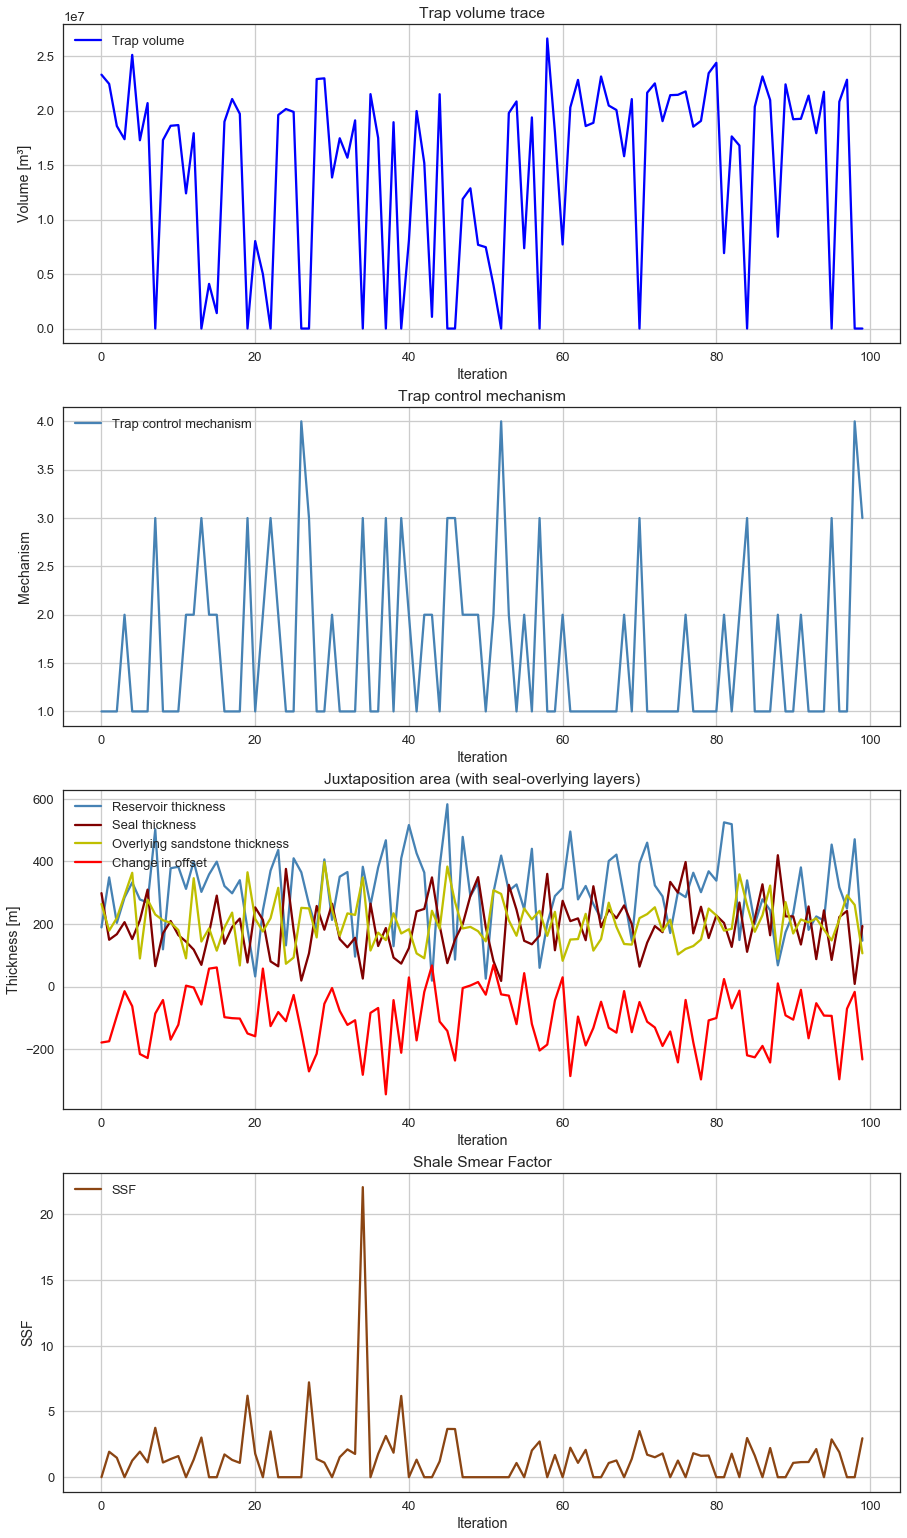

In [29]:
figsize(15,27)
fig, ax = plt.subplots(4, 1)

ax[0].plot(max_volume_trace, color='b', label='Trap volume')
ax[0].set_title('Trap volume trace')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Volume [m³]')
ax[0].legend(loc="upper left")
ax[0].grid()

ax[1].plot(trap_control_trace, color='steelblue', label='Trap control mechanism')
ax[1].set_title('Trap control mechanism')
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Mechanism')
ax[1].legend(loc="upper left")
ax[1].grid()

ax[2].plot(fw_res_th_trace, color='steelblue', label='Reservoir thickness')
ax[2].plot(fw_seal_th_trace, color='maroon', label='Seal thickness')
ax[2].plot(fw_sec_res_th_trace, color='y', label='Overlying sandstone thickness')
ax[2].plot(offset_unc_trace*rescale_f, color='r', label='Change in offset')
ax[2].set_title('Juxtaposition area (with seal-overlying layers)')
ax[2].set_xlabel('Iteration')
ax[2].set_ylabel('Thickness [m]')
ax[2].legend(loc="upper left")
ax[2].grid()

ax[3].plot(SSF_trace, color='saddlebrown', label='SSF')
ax[3].set_title('Shale Smear Factor')
ax[3].set_xlabel('Iteration')
ax[3].set_ylabel('SSF')
ax[3].legend(loc="upper left")
ax[3].grid()

#ax[4].plot(over_jux_area_trace, color='g', label='Juxtaposition area')
#ax[4].set_title('Juxtaposition area (with seal-overlying layers)')
#ax[4].set_xlabel('Iteration')
#ax[4].set_ylabel('Area [m²]')
#ax[4].legend(loc="upper left")
#ax[4].grid()

C:\Users\Fabian\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


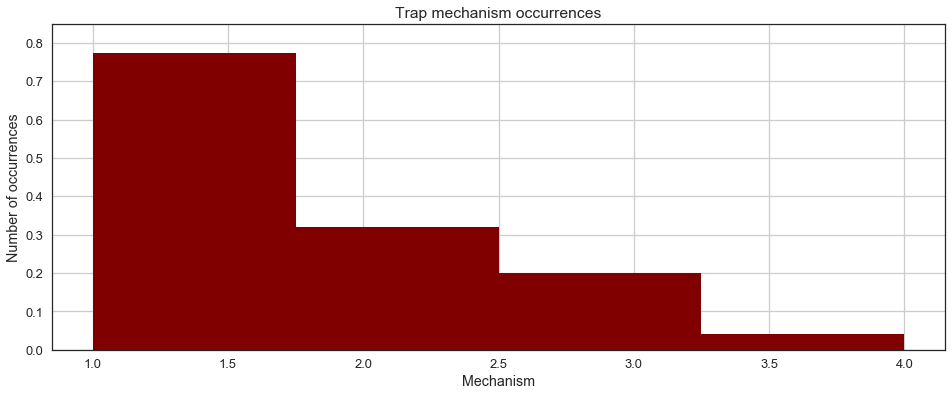

In [30]:
figsize(16, 6)
_hist1 = plt.hist(trap_control_trace, bins=4, normed=True, 
                  histtype="stepfilled", color = "maroon")
plt.title("Trap mechanism occurrences")
plt.legend(loc="upper right")
#plt.xticks(np.arange(0, np.max(_hist1[0])+1, np.max(_hist1[0])/10))
plt.grid()
plt.ylim(0, 1.1 * np.max(_hist1[0]))
plt.ylabel("Number of occurrences")
plt.xlabel("Mechanism")

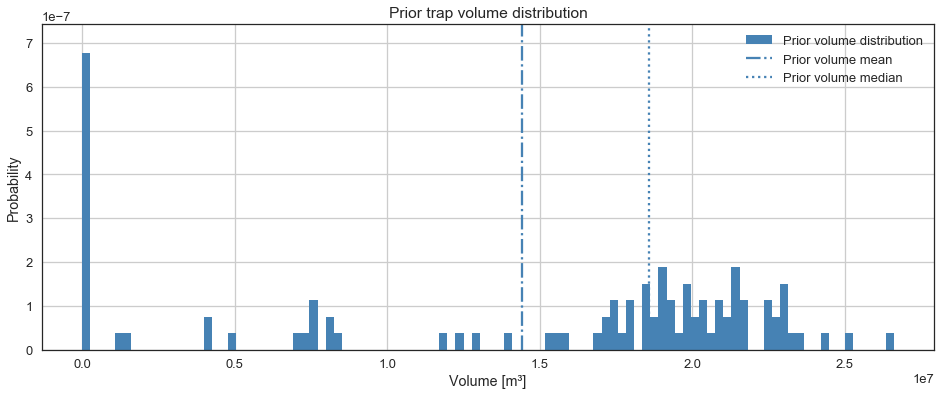

In [31]:
figsize(16, 6)

# Possibly mask away complete failures:
#volumes = max_volume_trace
#mask = volumes == 0
#masked_trace = volumes[~mask]

_hist1 = plt.hist(max_volume_trace, bins=100, normed=True, 
                  histtype="stepfilled",label="Prior volume distribution", color = "steelblue")
plt.vlines(max_volume_trace.mean(), 0, 1.1 * np.max(_hist1[0]), label="Prior volume mean", linestyles="-.", color = "steelblue")
plt.vlines(np.median(max_volume_trace), 0, 1.1 * np.max(_hist1[0]), label="Prior volume median", linestyles=":", color = "steelblue")
plt.title("Prior trap volume distribution")
plt.legend(loc="upper right")
#plt.xticks(np.arange(0, np.max(_hist1[0])+1, np.max(_hist1[0])/10))
plt.grid()
plt.ylim(0, 1.1 * np.max(_hist1[0]))
plt.xlabel("Volume [m³]")
plt.ylabel("Probability")

In [32]:
export = False

if export:
    counter = 0
    for i in structural_model_trace[:]:
        counter+=1
        #print(np.ascontiguousarray(i[3]))
        gp.export_vtk_rectilinear(geo_data, np.ascontiguousarray(i[3]), path="./output_data/trap_volumes/21_10B-TRAP_25iterUNC_LIKELIHOOD_%s" % (counter))
        gp.export_vtk_rectilinear(geo_data, np.ascontiguousarray(i[0][0]), path="./output_data/lith_blocks/21_10B-LITH_25iterUNC_LIKELIHOOD_%s" % (counter))

In [35]:
# INFORMATION ENTROPY FUNCTIONS
def compute_prob_lith(lith_blocks):
    """Blocks must be just the lith blocks!"""
    lith_id = np.unique(lith_blocks)
    lith_count = np.zeros_like(lith_blocks[0:len(lith_id)])
    for i, l_id in enumerate(lith_id):
        lith_count[i] = np.sum(lith_blocks == l_id, axis=0)
    lith_prob = lith_count / len(lith_blocks)
    return lith_prob


def calculate_ie_masked(lith_prob):
    ie = np.zeros_like(lith_prob[0])
    for l in lith_prob:
        pm = np.ma.masked_equal(l, 0)  # mask where layer prob is 0
        ie -= (pm * np.ma.log2(pm)).filled(0)
    return ie


def calculate_ie_total(ie, absolute=False):
    if absolute:
        return np.sum(ie)
    else:
        return np.sum(ie) / np.size(ie)

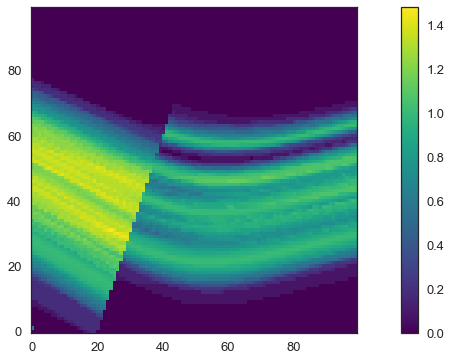

In [34]:
lith_blocks = []
for i in structural_model_trace[:]:
    #print(i[0][0])
    lith_blocks.append(i[0][0].astype(int))

lith_prob = compute_prob_lith(lith_blocks)
i_entropy = calculate_ie_masked(lith_prob)

plt.imshow(i_entropy.reshape(resolution,resolution,resolution)[:,0,:].T, origin="lower", cmap="viridis")
plt.colorbar()

In [36]:
#LOSS FUNCTIONS
estimates_s = np.arange(0,60000000, 10000)

#weight factors
ov = 1.25
ov_b = 2
uv_b = 1.5

#risk parameters
risks_s = np.arange(0.5, 1.6, 0.25)

#risk neutral
def volume_loss4(estimate_s, true_s):
        loss_s = np.zeros_like(true_s)
        underest = (estimate_s < true_s) 
        underest_bad = (estimate_s <= 0) & (true_s > 0)
        overest = (estimate_s > true_s) 
        overest_bad = (estimate_s > 0) & (true_s <= 0)
        loss_s[underest] = (true_s[underest] - estimate_s)
        loss_s[underest_bad] = (true_s[underest_bad] - estimate_s)*uv_b
        loss_s[overest] = (estimate_s - true_s[overest])*ov
        loss_s[overest_bad] = (estimate_s - true_s[overest_bad])*ov_b
        return loss_s

#including risk
def volume_lossR(estimate_s, true_s, risk_s):
        loss_s = np.zeros_like(true_s)
        underest = (estimate_s < true_s) 
        underest_bad = (estimate_s == 0) & (true_s > 0)
        overest = (estimate_s > true_s) 
        overest_bad = (estimate_s > 0) & (true_s == 0)
        loss_s[underest] = (true_s[underest] - estimate_s)
        loss_s[underest_bad] = (true_s[underest_bad] - estimate_s)*(uv_b*(risk_s**-0.5))
        loss_s[overest] = (estimate_s - true_s[overest])*(ov*risk_s)
        loss_s[overest_bad] = np.abs((true_s[overest_bad]-estimate_s))*(ov_b*risk_s)
        return loss_s
    
#def volume_lossR(estimate_s, true_s, risk_s):
#        loss_s = np.zeros_like(true_s)
#        underest = (estimate_s < true_s) 
#        underest_bad = (estimate_s <= 0) & (true_s > 0)
#        overest = (estimate_s > true_s) 
#        overest_bad = (estimate_s > 0) & (true_s <= 0)
#        loss_s[underest] = (true_s[underest] - estimate_s)
#        loss_s[underest_bad] = (true_s[underest_bad] - estimate_s)*(uv_b*(risk_s**-0.5))
#        loss_s[overest] = (estimate_s - true_s[overest])*(ov*risk_s)
#        loss_s[overest_bad] = (estimate_s - true_s[overest_bad])*(ov_b*risk_s)
#        return loss_s

Bayes action (minimum) at risk r 0.50: 19048000.00 --- expected loss: 5855210.00
Bayes action (minimum) at risk r 0.75: 17920000.00 --- expected loss: 8183920.00
Bayes action (minimum) at risk r 1.00: 16792000.00 --- expected loss: 10300800.00
Bayes action (minimum) at risk r 1.25: 12400000.00 --- expected loss: 11980835.00
Bayes action (minimum) at risk r 1.50: 7712000.00 --- expected loss: 12946380.00


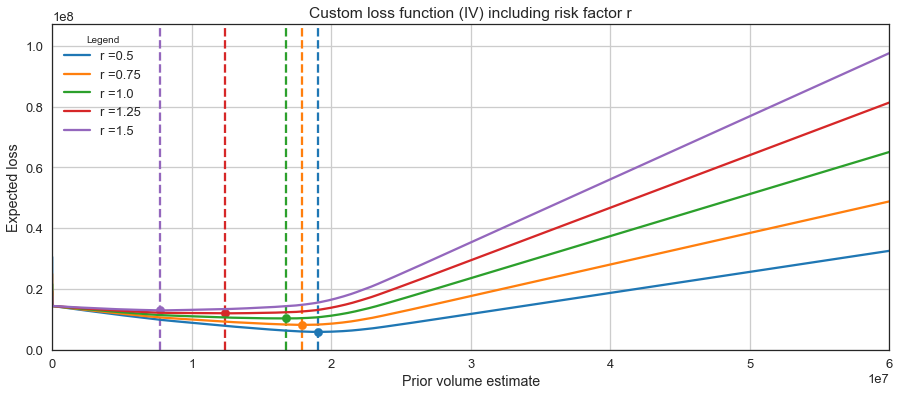

In [36]:
figsize(15, 6)

ax = plt.subplot(111)
expected_loss_s = lambda estimate_s, risk_s: volume_lossR(estimate_s, max_volume_trace, risk_s).mean()

for r in risks_s:
    _color = next(ax._get_lines.prop_cycler)
    loss = [expected_loss_s(e, r) for e in estimates_s]
    _min_vol = sop.fmin(expected_loss_s, -40, args=(r,),disp = False)
    if _min_vol < 0:
        _min_vol = 0
    plt.plot(estimates_s, loss, label = "r ="+str(r), color=_color['color'])
    plt.scatter(_min_vol, expected_loss_s(_min_vol,r), s = 70, color=_color['color'])#, label = "Bayes action r "+str(r))
    plt.vlines(_min_vol, 0, 10 * np.max(loss), color=_color['color'], linestyles="--")
    print("Bayes action (minimum) at risk r %.2f: %.2f --- expected loss: %.2f" % (r, _min_vol,\
                                                                              expected_loss_s(_min_vol,r)))
    
plt.title("""Custom loss function (IV) including risk factor r""")    
plt.legend(loc="upper left", scatterpoints=1, title="Legend")
#plt.vlines(0, 0, 1.1 * np.max(loss), label="zero score", linestyles="-")
#plt.vlines(res_score.mean(), 0, 1.1 * np.max(loss), label="posterior's mean", linestyles="-.")
#plt.vlines(np.median(res_score), 0, 1.1 * np.max(loss), label="score median", linestyles=":")
plt.xlabel("Prior volume estimate")
plt.ylabel("Expected loss")
plt.xlim(estimates_s[0], estimates_s[-1])
plt.ylim(0,1.1 * np.max(loss))
plt.grid()

In [41]:
# THICKNESS LIKELIHOOD FUNCTIONS
#Additional information, updating with likelihoods

#return fw_res_th, fw_seal_th, fw_sec_res_th, fw_rb_z, fw_sb_z, fw_r2b_z, fw_ob_z

std1 = 30
std2 = 10
std3 = 40

#@pymc.stochastic
#def sec_res_th_likelihood(value = 0, sec_res_th=sec_res_th):
#    return pymc.normal_like(sec_res_th, 120., 1./np.square(std1))
#
#@pymc.stochastic
#def seal_th_likelihood(value = 0, seal_th=seal_th):
#    return pymc.normal_like(seal_th, 400., 1./np.square(std2))
#
#@pymc.stochastic
#def res_th_likelihood(value = 0, res_th=res_th):
#    return pymc.normal_like(res_th, 250., 1./np.square(std3))

@pymc.stochastic
def sec_res_th_likelihood(value = 0, sec_res_th=sec_res_th):
    return pymc.normal_like(sec_res_th, 300., 1./np.square(std1))

@pymc.stochastic
def seal_th_likelihood(value = 0, seal_th=seal_th):
    return pymc.normal_like(seal_th, 50., 1./np.square(std2))

@pymc.stochastic
def res_th_likelihood(value = 0, res_th=res_th):
    return pymc.normal_like(res_th, 400., 1./np.square(std3))

In [42]:
# JUXTAPOSITION AREA LIKELIHOOD (not used)
#jux_mean = 150000
#jux_std = jux_mean/4
#
#@pymc.stochastic
#def jux_area_likelihood(value = 0, oja= over_jux_area):
#    return pymc.normal_like(over_jux_area, 150000., 1/np.square(jux_std))

In [43]:
#model = pymc.Model([pos_unc_model, z_unc_res_top, fault_sealing, fw_th, hw_th, 
#                    res_th_likelihood, seal_th_likelihood, sec_res_th_likelihood])
#model_L = pymc.Model([interp_unc, z_unc_res_top, z_unc_base_top, z_unc_seal_top, z_unc_secres_top, offset_unc,
                    #fault_sealing, structural_model, 
                    #res_th, seal_th, sec_res_th, over_jux_area, 
                    #res_th_likelihood, seal_th_likelihood, sec_res_th_likelihood])
model_L = pymc.Model([interp_unc, z_unc_res_top, z_unc_base_top, z_unc_seal_top, z_unc_secres_top, offset_unc,
                    fault_sealing, structural_model, 
                    res_th, seal_th, sec_res_th, res_th_likelihood, seal_th_likelihood, sec_res_th_likelihood])

In [44]:
iterations=1050

In [45]:
#M_L = pymc.MCMC(model_L)
M_L = pymc.MCMC(model_L,db= "hdf5" , dbname= "D:/PyMC_DataBase/post_model_300_30-050_10-400_40_1000iter50burn.hdf5")
M_L.sample(iter=iterations, burn=50)

Z variations top to bottom: 23.1749019422 3.16041067435 16.0351710206 49.6225915734
Fault offset variation: -161.952589258
Z variations top to bottom: 23.1749019422 3.16041067435 16.0351710206 38.6798835781
Fault offset variation: -312.837709098
Z variations top to bottom: 23.1749019422 3.16041067435 16.0351710206 38.6798835781
Fault offset variation: -161.952589258
Z variations top to bottom: 23.1749019422 -23.734056451 16.0351710206 38.6798835781
Fault offset variation: -161.952589258
Z variations top to bottom: 23.1749019422 -23.734056451 

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:80: UserWarning: Boolean Series key will be reindexed to m

37.2552948131 38.6798835781
Fault offset variation: -161.952589258
Z variations top to bottom: -19.5815482504 -23.734056451 37.2552948131 38.6798835781
Fault offset variation: -161.952589258
Z variations top to bottom: 23.1749019422 -23.734056451 37.2552948131 -78.8987997062
Fault offset variation: -161.952589258
Z variations top to bottom: 23.1749019422 -23.734056451 37.2552948131 -78.8987997062
Fault offset variation: -165.495921961
Z variations top to bottom: 23.1749019422 -83.1768894757 37.2552948131 -78.8987997062
Fault offset variation: -165.495921961
Z variations top to bottom: 23.1749019422 -83.1768894757 89.7751796181 -78.8987997062
Fault offset variation: -165.495921961
Z variations top to bottom: 38.9357750007 -83.1768894757 89.7751796181 -78.8987997062
Fault offset variation: -165.495921961
Z variations top to bottom: 38.9357750007 -83.1768894757 89.7751796181 -218.878274185
Fault offset variation: -165.495921961
Z variations top to bottom: 38.9357750007 -83.1768894757 89.7

Z variations top to bottom: 53.8386083481 -53.5843448928 96.8918641846 86.0286215923
Fault offset variation: 71.8963014215
Z variations top to bottom: 39.520890508 -53.5843448928 96.8918641846 86.0286215923
Fault offset variation: 71.8963014215
Z variations top to bottom: 39.520890508 -53.5843448928 96.8918641846 156.637747085
Fault offset variation: 71.8963014215
Z variations top to bottom: 39.520890508 -53.5843448928 96.8918641846 86.0286215923
Fault offset variation: 90.3023967684
Z variations top to bottom: 39.520890508 -12.008267508 96.8918641846 86.0286215923
Fault offset variation: 90.3023967684
Z variations top to bottom: 39.520890508 -53.5843448928 71.004033007 86.0286215923
Fault offset variation: 90.3023967684
Z variations top to bottom: 77.3568498452 -53.5843448928 96.8918641846 86.0286215923
Fault offset variation: 90.3023967684
Z variations top to bottom: 77.3568498452 -53.5843448928 96.8918641846 90.8629632084
Fault offset variation: 90.3023967684
Z variations top to bot

Z variations top to bottom: 64.1109093109 -59.6380945118 104.660081814 -33.060622747
Fault offset variation: -112.447958887
Z variations top to bottom: 64.1109093109 61.5774231591 104.660081814 -33.060622747
Fault offset variation: -112.447958887
Z variations top to bottom: 64.1109093109 -59.6380945118 113.41604096 -33.060622747
Fault offset variation: -112.447958887
Z variations top to bottom: 71.6779165813 -59.6380945118 104.660081814 -33.060622747
Fault offset variation: -112.447958887
 [-                 2%                  ] 28 of 1050 complete in 4.7 secZ variations top to bottom: 71.6779165813 -59.6380945118 104.660081814 -131.062693629
Fault offset variation: -112.447958887
Z variations top to bottom: 71.6779165813 -59.6380945118 104.660081814 -33.060622747
Fault offset variation: -164.157016456
Z variations top to bottom: 71.6779165813 5.90954439041 104.660081814 -33.060622747
Fault offset variation: -164.157016456
Z variations top to bottom: 71.6779165813 -59.6380945118 99.60

 [-                 3%                  ] 40 of 1050 complete in 6.9 secZ variations top to bottom: 38.3199050178 -38.103923309 112.669672939 -105.269623043
Fault offset variation: -29.7365765356
Z variations top to bottom: 38.3199050178 -38.103923309 112.669672939 -62.406715177
Fault offset variation: 79.2139949582
Z variations top to bottom: 38.3199050178 -30.7808608993 112.669672939 -62.406715177
Fault offset variation: 79.2139949582
Z variations top to bottom: 38.3199050178 -30.7808608993 123.559948692 -62.406715177
Fault offset variation: 79.2139949582
Z variations top to bottom: 5.41456032302 -30.7808608993 123.559948692 -62.406715177
Fault offset variation: 79.2139949582
Z variations top to bottom: 38.3199050178 -30.7808608993 123.559948692 -43.8747156442
Fault offset variation: 79.2139949582
Z variations top to bottom: 38.3199050178 -30.7808608993 123.559948692 -43.8747156442
Fault offset variation: -48.8079828063
Z variations top to bottom: 38.3199050178 -107.778103623 123.559

C:\Users\Fabian\Anaconda3\lib\site-packages\pymc\database\hdf5.py:485: UserWarning: 
Error tallying interp_unc, will not try to tally it again this chain.
Did you make all the samevariables and step methods tallyable
as were tallyable last time you used the database file?

Error:

Traceback (most recent call last):
  File "C:\Users\Fabian\Anaconda3\lib\site-packages\pymc\database\hdf5.py", line 475, in tally
    self._traces[name].tally(chain)
  File "C:\Users\Fabian\Anaconda3\lib\site-packages\pymc\database\hdf5.py", line 64, in tally
    self._vlarrays[chain].append(self._getfunc())
  File "C:\Users\Fabian\Anaconda3\lib\site-packages\tables\vlarray.py", line 519, in append
    sequence = atom.toarray(sequence)
  File "C:\Users\Fabian\Anaconda3\lib\site-packages\tables\atom.py", line 1086, in toarray
    buffer_ = self._tobuffer(object_)
  File "C:\Users\Fabian\Anaconda3\lib\site-packages\tables\atom.py", line 1220, in _tobuffer
    return six.moves.cPickle.dumps(object_, six.moves.cP

Z variations top to bottom: 49.5201182164 21.9812859617 109.852895269 30.9303310626
Fault offset variation: 11.5402691294
Z variations top to bottom: 49.5201182164 -46.0747276519 246.707004099 30.9303310626
Fault offset variation: 11.5402691294
Z variations top to bottom: 15.1613380523 -46.0747276519 109.852895269 30.9303310626
Fault offset variation: 11.5402691294
SPILL POINT AT: [ 1393.93945312   949.49493408   951.38408766]
LEAK POINT AT: [ 707.07067871  969.69696045  977.68833224]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [144.07237707900958] / [44.072377079009584] = [3.2689949267026748]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-                 4%                  ] 52 of 1050 complete in 25.8 secZ variations top to bottom: 15.1613380523 -46.0747276519 109.852895269 32.3469643357
Fault offset variation:

SPILL POINT AT: [ 1373.73742676   949.49493408   951.93493669]
LEAK POINT AT: [ 666.66668701  949.49493408  858.12846416]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 200.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [243.40390289979382] / [43.40390289979382] = [5.6078805507822214]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [--                5%                  ] 59 of 1050 complete in 86.7 secZ variations top to bottom: -5.35865297452 -46.0747276519 110.521369448 16.2337184652
Fault offset variation: -116.103951688
Z variations top to bottom: -5.35865297452 -46.0747276519 110.521369448 16.2337184652
Fault offset variation: -17.3943313484
Z variations top to bottom: -5.35865297452 90.374524187 110.521369448 16.2337184652
Fault offset variation: -17.3943313484
Z variations top to bottom: -5.35865297452 -46.0747276519 84.676160758 16.2337184652
Fault offset variat

SPILL POINT AT: [ 1373.73742676   949.49493408   921.4849316 ]
LEAK POINT AT: [ 666.66668701  969.69696045  901.83414722]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [170.1405248528979] / [70.140524852897897] = [2.4257093201073823]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 16536000.0 m³
 [--                6%                  ] 66 of 1050 complete in 147.8 secZ variations top to bottom: 16.9024271568 -50.2612025113 79.5982726358 63.8256946051
Fault offset variation: -34.2727533038
Z variations top to bottom: 16.9024271568 -50.2612025113 79.5982726358 31.1080682425
Fault offset variation: 1.0005300232
Z variations top to bottom: 16.9024271568 -118.303089308 79.5982726358 31.1080682425
Fault offset variation: 1.0005300232
Z variations top to bottom: 16.9024271568 -50.2612025113 36.8181478095 31.1080682425
Fault offset variation: 

NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [207.86816795516211] / [47.868167955162107] = [4.3425135499205076]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [--                6%                  ] 73 of 1050 complete in 208.7 secZ variations top to bottom: -14.5984969105 -72.5335594091 79.5982726358 -17.4554518923
Fault offset variation: -62.7954177323
Z variations top to bottom: -14.5984969105 -72.5335594091 79.5982726358 -17.4554518923
Fault offset variation: -311.735259894
Z variations top to bottom: -14.5984969105 -145.78918581 79.5982726358 -17.4554518923
Fault offset variation: -62.7954177323
Z variations top to bottom: -14.5984969105 -72.5335594091 42.3290745238 -17.4554518923
Fault offset variation: -62.7954177323
Z variations top to bottom: 51.2368584597 -72.5335594091 79.5982726358 -17.4554518923
Fault of

NUMBER OF TRAPS 2
Checking Section: 11
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [148.20130209670106] / [48.201302096701056] = [3.0746327516086769]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [--                7%                  ] 80 of 1050 complete in 269.6 secZ variations top to bottom: 11.6437729535 -76.8369814603 74.961716443 -158.40104067
Fault offset variation: -2.52679617125
Z variations top to bottom: 11.6437729535 -76.8369814603 74.961716443 -141.88945024
Fault offset variation: -69.1509603026
Z variations top to bottom: 11.6437729535 -1.70396318588 74.961716443 -141.88945024
Fault offset variation: -69.1509603026
Z variations top to bottom: 11.6437729535 -76.8369814603 153.938740987 -141.88945024
Fault offset variation: -69.1509603026
Z variations top to bottom: 15.5428515832 -76.8369814603 74.961716443 -141.88945024
Fault offset variati

SPILL POINT AT: [ 1373.73742676   949.49493408   916.73703386]
LEAK POINT AT: [ 626.26263428  949.49493408  767.92746921]
NUMBER OF TRAPS 2
Checking Section: 11
Unable to calculate an adjacency area.
Adding 280.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [331.94384853679662] / [51.943848536796622] = [6.3904361707363702]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [---               8%                  ] 87 of 1050 complete in 331.3 secZ variations top to bottom: -13.3384263796 -73.0944350202 74.961716443 -0.439024520293
Fault offset variation: -175.882391149
Z variations top to bottom: -13.3384263796 -73.0944350202 74.961716443 -0.439024520293
Fault offset variation: -330.974578951
Z variations top to bottom: -13.3384263796 -181.497142997 74.961716443 -0.439024520293
Fault offset variation: -175.882391149
Z variations top to

SPILL POINT AT: [ 1373.73742676   949.49493408   931.12255512]
LEAK POINT AT: [ 666.66668701  969.69696045  883.06052811]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [210.85981925093301] / [50.859819250933015] = [4.1459018603780198]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [---               8%                  ] 94 of 1050 complete in 392.4 secZ variations top to bottom: 35.2776677262 -59.7294496789 89.4107310702 -8.86863366829
Fault offset variation: -65.247049155
Z variations top to bottom: 35.2776677262 -59.7294496789 89.4107310702 -8.86863366829
Fault offset variation: -15.2603424224
Z variations top to bottom: 35.2776677262 -44.5782726807 89.4107310702 -8.86863366829
Fault offset variation: -65.247049155
Z variations top to bottom: 35.2776677262 -44.5782726807 90.5953018234 -8.86863366829
Fault offset var

SPILL POINT AT: [ 1373.73742676   949.49493408   907.89366476]
LEAK POINT AT: [ 626.26263428  949.49493408  733.5680471 ]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 280.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [342.1819795568988] / [62.181979556898796] = [5.5029122905903902]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [---               9%                  ] 101 of 1050 complete in 453.3 secZ variations top to bottom: 32.6415830416 -71.7063348538 66.1116855893 -21.5298993136
Fault offset variation: -203.678280981
Z variations top to bottom: 32.6415830416 -71.7063348538 66.1116855893 -21.5298993136
Fault offset variation: -225.870588814
Z variations top to bottom: 32.6415830416 -74.3761265785 66.1116855893 -21.5298993136
Fault offset variation: -203.678280981
Z variations top to bottom: 32.6415830416 -74.3761265785 23.7184299598 -21.5298993136
Fault offset v

SPILL POINT AT: [ 1373.73742676   949.49493408   904.65082181]
LEAK POINT AT: [ 666.66668701  969.69696045  889.45722568]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [191.24851301208923] / [31.248513012089234] = [6.120243639692557]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [---              10%                  ] 108 of 1050 complete in 514.3 secZ variations top to bottom: 39.5429428243 -105.855452632 62.8960343563 -6.52300396536
Fault offset variation: -37.2848800118
Z variations top to bottom: 39.5429428243 -105.855452632 62.8960343563 -6.52300396536
Fault offset variation: -204.912383986
Z variations top to bottom: 39.5429428243 -124.299611591 62.8960343563 -6.52300396536
Fault offset variation: -204.912383986
Z variations top to bottom: 39.5429428243 -105.855452632 3.13746329762 -6.52300396536
Fault offset v

Fault offset variation: -416.583479868
Z variations top to bottom: -10.0991118426 -111.633350355 51.854170655 -92.8000572373
Fault offset variation: -260.508668245
Z variations top to bottom: -10.0991118426 -105.855452632 98.5938546806 -92.8000572373
Fault offset variation: -260.508668245
Z variations top to bottom: -11.5912670547 -105.855452632 51.854170655 -92.8000572373
Fault offset variation: -260.508668245
SPILL POINT AT: [ 1373.73742676   949.49493408   893.5178653 ]
LEAK POINT AT: [ 606.06060791  949.49493408  676.02699575]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 320.0 to throw, adjacency between 8 and 5
Adding 60.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [422.29037671337937] / [42.290376713379374] = [9.9854957447040125]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [----             10%                  ] 115 of 1050 complete in 576.3 secZ variation

 [----             11%                  ] 121 of 1050 complete in 628.9 secZ variations top to bottom: 22.2834953255 -105.855452632 33.2754700833 -54.2343717725
Fault offset variation: -102.600123936
Z variations top to bottom: 22.2834953255 -105.855452632 33.2754700833 -54.2343717725
Fault offset variation: 33.31924711
Z variations top to bottom: 22.2834953255 -283.519934983 33.2754700833 -54.2343717725
Fault offset variation: -102.600123936
Z variations top to bottom: 22.2834953255 -105.855452632 -35.4414767023 -54.2343717725
Fault offset variation: -102.600123936
Z variations top to bottom: 11.0331110946 -105.855452632 33.2754700833 -54.2343717725
Fault offset variation: -102.600123936
SPILL POINT AT: [ 1373.73742676   949.49493408   875.3302213 ]
LEAK POINT AT: [ 646.46466064  949.49493408  792.28214527]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 200.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [260.86907728516212] / [60.86907728516212] = [4

 [----             12%                  ] 128 of 1050 complete in 689.7 secZ variations top to bottom: 1.01512826936 -125.706178637 24.1510784761 -51.6931069425
Fault offset variation: -77.7314806246
Z variations top to bottom: 1.01512826936 -125.706178637 24.1510784761 -51.6931069425
Fault offset variation: -128.810960928
Z variations top to bottom: 1.01512826936 -48.8262754778 24.1510784761 -51.6931069425
Fault offset variation: -128.810960928
Z variations top to bottom: 1.01512826936 -125.706178637 2.55914479244 -51.6931069425
Fault offset variation: -128.810960928
Z variations top to bottom: -0.285198580967 -125.706178637 24.1510784761 -51.6931069425
Fault offset variation: -128.810960928
SPILL POINT AT: [ 1353.53540039   949.49493408   866.05633917]
LEAK POINT AT: [ 626.26263428  949.49493408  760.4931406 ]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 220.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [270.14274288732327] / [50.142742887323266]

SPILL POINT AT: [ 1353.53540039   949.49493408   860.61824174]
LEAK POINT AT: [ 666.66668701  969.69696045  850.46153034]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [195.80485124345455] / [55.80485124345455] = [3.5087424637911]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [----             12%                  ] 135 of 1050 complete in 750.5 secZ variations top to bottom: 21.7717991273 -125.706178637 18.48897012 -52.4706762421
Fault offset variation: -30.4478970856
Z variations top to bottom: 21.7717991273 -125.706178637 18.48897012 -52.4706762421
Fault offset variation: -55.9066845495
Z variations top to bottom: 21.7717991273 -131.365126793 18.48897012 -52.4706762421
Fault offset variation: -55.9066845495
Z variations top to bottom: 21.7717991273 -131.365126793 -5.25257189319 -52.4706762421
Fault offset variation

NUMBER OF TRAPS 1
Checking Section: 11
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 11
Maximum trap volume: 1232000.0 m³
 [-----            13%                  ] 142 of 1050 complete in 811.0 secZ variations top to bottom: -18.4834440405 -130.359081623 -6.020645223 -160.596147849
Fault offset variation: 86.162170994
Z variations top to bottom: -18.4834440405 -130.359081623 -6.020645223 -95.3412211399
Fault offset variation: 216.359958934
Z variations top to bottom: -18.4834440405 -130.359081623 -6.020645223 -95.3412211399
Fault offset variation: 86.162170994
Z variations top to bottom: -18.4834440405 -177.124197385 -6.020645223 -95.3412211399
Fault offset variation: 86.162170994
Z variations top to bottom: -18.4834440405 -177.124197385 -44.6038781423 -95.3412211399
Fault offset variation: 86.162170994
Z variations top to bottom: 19.4463602401 -177.124197385 -44.6038781423 -95.3412211399
Fault offset variation: 86.162170994
SPILL POINT AT: [ 1353.5354003

SPILL POINT AT: [ 1353.53540039   949.49493408   834.77036213]
LEAK POINT AT: [ 686.86871338  969.69696045  929.33966522]
NUMBER OF TRAPS 1
Checking Section: 11
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [71.509672876073637] / [51.509672876073637] = [1.3882765873531697]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Maximum trap volume: 2688000.0 m³
 [-----            14%                  ] 150 of 1050 complete in 873.8 secZ variations top to bottom: -52.105197634 -155.846508222 -7.35618109759 -72.4528238824
Fault offset variation: 76.1710418614
Z variations top to bottom: -52.105197634 -155.846508222 -7.35618109759 -98.5989990516
Fault offset variation: -153.34450683
Z variations top to bottom: -52.105197634 -311.249657435 -7.35618109759 -98.5989990516
Fault offset variation: -153.34450683
Z variations top to bottom: -52.105197634 -155.846508222 -0.938592702835 -98.5989990516
Fault offset variation: -153.344506

SPILL POINT AT: [ 1353.53540039   949.49493408   829.85885693]
LEAK POINT AT: [ 606.06060791  949.49493408  699.35237179]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 240.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [296.20130600547395] / [56.201306005473953] = [5.2703633964773742]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----            14%                  ] 157 of 1050 complete in 935.3 secZ variations top to bottom: -50.1786880669 -155.846508222 -12.047814227 -109.124062584
Fault offset variation: -160.28367191
Z variations top to bottom: -50.1786880669 -155.846508222 -12.047814227 -109.124062584
Fault offset variation: 7.66648756657
Z variations top to bottom: -50.1786880669 -164.119626992 -12.047814227 -109.124062584
Fault offset variation: -160.28367191
Z variations top to bottom: -50.1786880669 -164.119626992 11.1624749188 -109.124062584
Fault offset

SPILL POINT AT: [ 1353.53540039   949.49493408   829.72366806]
LEAK POINT AT: [ 606.06060791  949.49493408  690.85307775]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 260.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [307.92818723504797] / [47.928187235047972] = [6.4247826800733323]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----            15%                  ] 164 of 1050 complete in 996.1 secZ variations top to bottom: -27.7559062466 -164.119626992 -12.047814227 -182.653545467
Fault offset variation: -169.746469457
Z variations top to bottom: -27.7559062466 -164.119626992 -12.047814227 -128.517565039
Fault offset variation: -156.081146354
Z variations top to bottom: -27.7559062466 -61.050554966 -12.047814227 -128.517565039
Fault offset variation: -156.081146354
Z variations top to bottom: -27.7559062466 -164.119626992 -75.8983088947 -128.517565039
Fault off

SPILL POINT AT: [ 1373.73742676   949.49493408   865.74993442]
LEAK POINT AT: [ 646.46466064  969.69696045  791.07514095]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [233.7917389661834] / [73.791738966183402] = [3.1682643916729396]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [------           16%                  ] 171 of 1050 complete in 1057.4 secZ variations top to bottom: -41.4510247854 -102.620308091 23.5879529429 -30.5529205648
Fault offset variation: -92.6333656892
Z variations top to bottom: -41.4510247854 -102.620308091 23.5879529429 -30.5529205648
Fault offset variation: -191.16391581
Z variations top to bottom: -41.4510247854 -185.512767014 23.5879529429 -30.5529205648
Fault offset variation: -92.6333656892
Z variations top to bottom: -41.4510247854 -102.620308091 9.24988896017 -30.5529205648
Fault offs

NUMBER OF TRAPS 2
Checking Section: 11
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [153.55032585552863] / [73.550325855528627] = [2.0876906263765598]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 14048000.0 m³
 [------           16%                  ] 178 of 1050 complete in 1118.3 secZ variations top to bottom: 45.993367596 -57.2775829174 69.1720912271 -10.4814478987
Fault offset variation: 9.84330999683
Z variations top to bottom: 45.993367596 -57.2775829174 69.1720912271 -10.4814478987
Fault offset variation: 55.9158452879
Z variations top to bottom: 45.993367596 1.0616573456 69.1720912271 -10.4814478987
Fault offset variation: 55.9158452879
Z variations top to bottom: 45.993367596 -57.2775829174 72.8315032858 -10.4814478987
Fault offset variation: 55.9158452879
Z variations top to bottom: 47.1086258829 -57.2775829174 72.8315032858 -10.4814478987
Fault offset variatio

NUMBER OF TRAPS 1
Checking Section: 11
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 11
Maximum trap volume: 640000.0 m³
 [------           17%                  ] 185 of 1050 complete in 1179.1 secZ variations top to bottom: -5.80581677174 -57.2775829174 72.8315032858 50.7185014287
Fault offset variation: 99.4496908584
Z variations top to bottom: -5.80581677174 -57.2775829174 72.8315032858 50.7185014287
Fault offset variation: -25.6247356473
Z variations top to bottom: -5.80581677174 7.88421618394 72.8315032858 50.7185014287
Fault offset variation: -25.6247356473
Z variations top to bottom: -5.80581677174 -57.2775829174 27.5887957932 50.7185014287
Fault offset variation: -25.6247356473
Z variations top to bottom: -53.1053897639 -57.2775829174 72.8315032858 50.7185014287
Fault offset variation: -25.6247356473
Z variations top to bottom: -5.80581677174 -57.2775829174 72.8315032858 50.7185014287
Fault offset variation: -25.6247356473
SPILL POINT AT: [ 1373.7

NUMBER OF TRAPS 2
Checking Section: 11
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [152.5977642203984] / [52.597764220398403] = [2.901221496430415]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 15968000.0 m³
 [------           18%                  ] 192 of 1050 complete in 1240.4 secZ variations top to bottom: 25.3199851317 -80.2721915219 172.325572698 128.953867116
Fault offset variation: -21.3661210653
Z variations top to bottom: 25.3199851317 -80.2721915219 172.325572698 51.3440681571
Fault offset variation: -125.92234738
Z variations top to bottom: 25.3199851317 -104.217500367 172.325572698 51.3440681571
Fault offset variation: -125.92234738
Z variations top to bottom: 25.3199851317 -80.2721915219 211.63517927 51.3440681571
Fault offset variation: -125.92234738
Z variations top to bottom: 52.0344408533 -80.2721915219 172.325572698 51.3440681571
Fault offset variatio

SPILL POINT AT: [ 1373.73742676   949.49493408   911.89807199]
LEAK POINT AT: [ 686.86871338  969.69696045  937.3246712 ]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [142.8960639436882] / [62.896063943688205] = [2.2719396888114525]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 14120000.0 m³
 [-------          18%                  ] 199 of 1050 complete in 1301.5 secZ variations top to bottom: 36.1670986239 -67.1033700817 70.0005659746 -55.1386693229
Fault offset variation: 13.3622967261
Z variations top to bottom: 36.1670986239 -67.1033700817 70.0005659746 -55.1386693229
Fault offset variation: -319.897912209
Z variations top to bottom: 36.1670986239 -46.0792058051 70.0005659746 -55.1386693229
Fault offset variation: 13.3622967261
Z variations top to bottom: 36.1670986239 -67.1033700817 30.3336252728 -55.1386693229
Fault offset vari

SPILL POINT AT: [ 1373.73742676   949.49493408   922.78690537]
LEAK POINT AT: [ 666.66668701  969.69696045  877.67928989]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [211.91091761716098] / [51.910917617160976] = [4.0822032694545625]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-------          19%                  ] 206 of 1050 complete in 1362.6 secZ variations top to bottom: 34.4074646799 -67.1033700817 80.9857123012 16.8522219778
Fault offset variation: -61.4955283673
Z variations top to bottom: 34.4074646799 -67.1033700817 80.9857123012 -20.0967327412
Fault offset variation: -26.5330220917
Z variations top to bottom: 34.4074646799 -75.0255051731 80.9857123012 -20.0967327412
Fault offset variation: -26.5330220917
Z variations top to bottom: 34.4074646799 -67.1033700817 65.8084360273 -20.0967327412
Fault offset 

SPILL POINT AT: [ 1373.73742676   949.49493408   905.15083972]
LEAK POINT AT: [ 626.26263428  949.49493408  758.31532767]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 260.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [311.69489781046309] / [51.69489781046309] = [6.0295098938637572]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-------          20%                  ] 213 of 1050 complete in 1423.5 secZ variations top to bottom: 64.1767644027 -84.9300183076 63.3750838819 -120.458711273
Fault offset variation: -171.552425375
Z variations top to bottom: 64.1767644027 -84.9300183076 63.3750838819 -30.8012376007
Fault offset variation: -84.0362954138
Z variations top to bottom: 64.1767644027 -115.94725242 63.3750838819 -30.8012376007
Fault offset variation: -84.0362954138
Z variations top to bottom: 64.1767644027 -84.9300183076 107.652642426 -30.8012376007
Fault offset v

NUMBER OF TRAPS 2
Checking Section: 11
Adding 220.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [271.69489781046309] / [51.69489781046309] = [5.2557391409616407]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-------          20%                  ] 220 of 1050 complete in 1484.2 secZ variations top to bottom: 18.6526944459 -84.9300183076 63.3750838819 19.4586485511
Fault offset variation: -114.387659018
Z variations top to bottom: 18.6526944459 -84.9300183076 63.3750838819 19.4586485511
Fault offset variation: -117.758150356
Z variations top to bottom: 18.6526944459 -117.659226561 63.3750838819 19.4586485511
Fault offset variation: -117.758150356
Z variations top to bottom: 18.6526944459 -84.9300183076 41.6098144381 19.4586485511
Fault offset variation: -117.758150356
Z variations top to bottom: -7.42322535522 -84.9300183076 63.3750838819 19.4586485511
Fault offset v

SPILL POINT AT: [ 1373.73742676   949.49493408   905.3068825 ]
LEAK POINT AT: [ 666.66668701  949.49493408  855.69377997]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [218.39469595162541] / [58.394695951625408] = [3.7399748794401666]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [--------         21%                  ] 227 of 1050 complete in 1545.2 secZ variations top to bottom: -17.4137110482 -78.2302201665 63.3750838819 -119.47488732
Fault offset variation: -67.9533410381
Z variations top to bottom: -17.4137110482 -78.2302201665 63.3750838819 -119.47488732
Fault offset variation: -78.1369619412
Z variations top to bottom: -17.4137110482 -86.1580211663 63.3750838819 -119.47488732
Fault offset variation: -78.1369619412
Z variations top to bottom: -17.4137110482 -86.1580211663 120.190268745 -119.47488732
Fault offset

Z variations top to bottom: 39.0035588007 -88.5858530754 68.8366181276 -40.518972952
Fault offset variation: -109.561877056
Z variations top to bottom: 8.27200887218 -88.5858530754 68.8366181276 -40.518972952
Fault offset variation: -109.561877056
SPILL POINT AT: [ 1373.73742676   949.49493408   910.55272222]
LEAK POINT AT: [ 646.46466064  949.49493408  823.11189063]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 220.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [262.57752879700524] / [42.577528797005243] = [6.1670448289491624]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [--------         22%                  ] 234 of 1050 complete in 1605.8 secZ variations top to bottom: 8.27200887218 -88.5858530754 68.8366181276 -93.5420852803
Fault offset variation: -109.561877056
Z variations top to bottom: 8.27200887218 -88.5858530754 68.8366181276 -40.518972952
Fault offset va

SPILL POINT AT: [ 1373.73742676   949.49493408   902.7282674 ]
LEAK POINT AT: [ 666.66668701  969.69696045  879.71758985]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [210.64623003142128] / [50.646230031421283] = [4.1591690023272188]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [--------         22%                  ] 241 of 1050 complete in 1667.0 secZ variations top to bottom: 28.1002748068 -88.5858530754 60.7679168932 -96.7044836721
Fault offset variation: -39.420947348
Z variations top to bottom: 28.1002748068 -88.5858530754 60.7679168932 -69.3430605767
Fault offset variation: -122.374955657
Z variations top to bottom: 28.1002748068 -209.23393133 60.7679168932 -69.3430605767
Fault offset variation: -122.374955657
Z variations top to bottom: 28.1002748068 -88.5858530754 15.7279640759 -69.3430605767
Fault offset v

SPILL POINT AT: [ 1373.73742676   949.49493408   900.09364621]
LEAK POINT AT: [ 686.86871338  969.69696045  912.03726972]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [148.13808397598518] / [48.138083975985182] = [3.0773572967691725]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [--------         23%                  ] 248 of 1050 complete in 1727.9 secZ variations top to bottom: -5.1998426884 -93.691512388 58.170403636 -110.639382805
Fault offset variation: -7.0446743661
Z variations top to bottom: -5.1998426884 -93.691512388 58.170403636 -40.4074605736
Fault offset variation: -75.5464427219
Z variations top to bottom: -5.1998426884 -155.426364941 58.170403636 -40.4074605736
Fault offset variation: -75.5464427219
Z variations top to bottom: -5.1998426884 -93.691512388 127.076879433 -40.4074605736
Fault offset variat

SPILL POINT AT: [ 1373.73742676   949.49493408   901.71694356]
LEAK POINT AT: [ 666.66668701  969.69696045  884.82090694]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [206.47934428336998] / [46.479344283369983] = [4.4423893552484346]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [---------        24%                  ] 255 of 1050 complete in 1788.8 secZ variations top to bottom: -10.6750964276 -93.691512388 59.8291433286 -58.6147172306
Fault offset variation: -35.5628814408
Z variations top to bottom: -10.6750964276 -93.691512388 59.8291433286 -58.6147172306
Fault offset variation: -224.990321771
Z variations top to bottom: -10.6750964276 -83.5397833844 59.8291433286 -58.6147172306
Fault offset variation: -224.990321771
Z variations top to bottom: -10.6750964276 -83.5397833844 39.5611813776 -58.6147172306
Fault offs

Z variations top to bottom: 2.74756728724 -83.5397833844 59.8291433286 25.3523729728
Fault offset variation: -253.642729899
Z variations top to bottom: 2.74756728724 -44.3543373957 59.8291433286 25.3523729728
Fault offset variation: -253.642729899
Z variations top to bottom: 2.74756728724 -83.5397833844 -42.097598925 25.3523729728
Fault offset variation: -253.642729899
Z variations top to bottom: -12.0883488751 -83.5397833844 59.8291433286 25.3523729728
Fault offset variation: -253.642729899
SPILL POINT AT: [ 1373.73742676   949.49493408   901.50476987]
LEAK POINT AT: [ 606.06060791  949.49493408  687.14812792]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 320.0 to throw, adjacency between 8 and 5
Adding 40.0 to throw, adjacency between 8 and 6
Adding 180.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [596.63107328696378] / [56.631073286963783] = [10.535401126227738]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
N

 [---------        25%                  ] 268 of 1050 complete in 1902.7 secZ variations top to bottom: -23.5876795211 -83.5397833844 59.8291433286 12.6639111383
Fault offset variation: -58.6690708336
Z variations top to bottom: -23.5876795211 -83.5397833844 59.8291433286 12.6639111383
Fault offset variation: -43.989265803
Z variations top to bottom: -23.5876795211 -164.950213992 59.8291433286 12.6639111383
Fault offset variation: -43.989265803
Z variations top to bottom: -23.5876795211 -83.5397833844 88.978590288 12.6639111383
Fault offset variation: -43.989265803
Z variations top to bottom: -17.5863030831 -83.5397833844 59.8291433286 12.6639111383
Fault offset variation: -43.989265803
SPILL POINT AT: [ 1373.73742676   949.49493408   901.72159036]
LEAK POINT AT: [ 666.66668701  969.69696045  872.13957858]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [196.63107328696378] / [56.631073286963783] = [3.

NUMBER OF TRAPS 2
Checking Section: 11
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [145.37513434955463] / [45.375134349554628] = [3.2038502239934754]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [---------        26%                  ] 275 of 1050 complete in 1963.6 secZ variations top to bottom: -1.35371295226 -94.7957223218 59.8291433286 -26.3327686507
Fault offset variation: -17.1535398366
Z variations top to bottom: -1.35371295226 -94.7957223218 59.8291433286 -26.3327686507
Fault offset variation: -14.4742737028
Z variations top to bottom: -1.35371295226 -195.995109647 59.8291433286 -26.3327686507
Fault offset variation: -14.4742737028
Z variations top to bottom: -1.35371295226 -94.7957223218 114.4319428 -26.3327686507
Fault offset variation: -14.4742737028
Z variations top to bottom: -7.08330154155 -94.7957223218 59.8291433286 -26.3327686507
Fault 

SPILL POINT AT: [ 1373.73742676   949.49493408   877.26449397]
LEAK POINT AT: [ 626.26263428  949.49493408  777.40048259]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 220.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [282.6869347030115] / [62.686934703011502] = [4.5095032328870772]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [----------       26%                  ] 282 of 1050 complete in 2024.5 secZ variations top to bottom: -7.19539166692 -102.083380864 35.229684433 -30.8700201814
Fault offset variation: -121.297485783
Z variations top to bottom: -7.19539166692 -102.083380864 35.229684433 -30.8700201814
Fault offset variation: -173.144697782
Z variations top to bottom: -7.19539166692 -199.534166659 35.229684433 -30.8700201814
Fault offset variation: -121.297485783
Z variations top to bottom: -7.19539166692 -102.083380864 65.1572011065 -30.8700201814
Fault offset

SPILL POINT AT: [ 1373.73742676   949.49493408   918.44515111]
LEAK POINT AT: [ 646.46466064  949.49493408  795.09960325]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 260.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [301.1296437337287] / [41.129643733728699] = [7.3214746444979513]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [----------       27%                  ] 289 of 1050 complete in 2085.4 secZ variations top to bottom: 8.24527581246 -82.0963557752 76.7740004911 -67.4331450067
Fault offset variation: -149.812472279
Z variations top to bottom: 8.24527581246 -82.0963557752 76.7740004911 -67.4331450067
Fault offset variation: -267.076186581
Z variations top to bottom: 8.24527581246 -70.8123155466 76.7740004911 -67.4331450067
Fault offset variation: -267.076186581
Z variations top to bottom: 8.24527581246 -70.8123155466 37.0697830094 -67.4331450067
Fault offset 

 [----------       28%                  ] 295 of 1050 complete in 2138.6 secZ variations top to bottom: -9.51924510328 -66.7263682818 76.7740004911 -92.9786489201
Fault offset variation: -128.708652623
Z variations top to bottom: -9.51924510328 -66.7263682818 76.7740004911 -92.9786489201
Fault offset variation: -142.719917914
Z variations top to bottom: -9.51924510328 -45.857026456 76.7740004911 -92.9786489201
Fault offset variation: -142.719917914
Z variations top to bottom: -9.51924510328 -66.7263682818 91.3768737471 -92.9786489201
Fault offset variation: -142.719917914
Z variations top to bottom: -2.79544546151 -66.7263682818 91.3768737471 -92.9786489201
Fault offset variation: -142.719917914
SPILL POINT AT: [ 1393.93945312   949.49493408   933.03760943]
LEAK POINT AT: [ 646.46466064  949.49493408  814.5455426 ]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 260.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [301.89675797102882] / [41.8967579710288

 [----------       28%                  ] 302 of 1050 complete in 2200.1 secZ variations top to bottom: 19.6724721673 -54.3408824988 91.3768737471 -98.9845061534
Fault offset variation: -243.544621307
Z variations top to bottom: 19.6724721673 -54.3408824988 91.3768737471 -32.813804756
Fault offset variation: -378.857058794
Z variations top to bottom: 19.6724721673 -54.3408824988 91.3768737471 -32.813804756
Fault offset variation: -243.544621307
Z variations top to bottom: 19.6724721673 -138.829137595 91.3768737471 -32.813804756
Fault offset variation: -243.544621307
Z variations top to bottom: 19.6724721673 -54.3408824988 75.9868301925 -32.813804756
Fault offset variation: -243.544621307
Z variations top to bottom: 58.3188867334 -54.3408824988 91.3768737471 -32.813804756
Fault offset variation: -243.544621307
Z variations top to bottom: 19.6724721673 -54.3408824988 91.3768737471 -32.813804756
Fault offset variation: -243.544621307
SPILL POINT AT: [ 1373.73742676   949.49493408   932.98

SPILL POINT AT: [ 1373.73742676   949.49493408   909.23483754]
LEAK POINT AT: [ 606.06060791  949.49493408  676.82990012]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 340.0 to throw, adjacency between 8 and 5
Adding 100.0 to throw, adjacency between 8 and 6
Adding 160.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [644.18263319822677] / [44.182633198226767] = [14.579996405105174]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------      29%                  ] 309 of 1050 complete in 2262.6 secZ variations top to bottom: -17.0129305651 -88.1429813326 67.6743854692 30.3263797079
Fault offset variation: -278.415111729
Z variations top to bottom: -17.0129305651 -88.1429813326 67.6743854692 30.3263797079
Fault offset variation: -376.5727704
Z variations top to bottom: -17.0129305651 -94.5672410937 67.6743854692 30.3263797079
Fault offset variation: -278.415111729
Z 

Z variations top to bottom: -18.388958182 -75.1084225649 86.3652703131 -50.4427028807
Fault offset variation: -246.421327974
Z variations top to bottom: -18.388958182 12.583946221 86.3652703131 -50.4427028807
Fault offset variation: -71.0499578394
Z variations top to bottom: -18.388958182 -75.1084225649 108.807737003 -50.4427028807
Fault offset variation: -71.0499578394
Z variations top to bottom: -44.7775536823 -75.1084225649 86.3652703131 -50.4427028807
Fault offset variation: -71.0499578394
Z variations top to bottom: -18.388958182 -75.1084225649 86.3652703131 -50.4427028807
Fault offset variation: -71.0499578394
SPILL POINT AT: [ 1373.73742676   949.49493408   927.99025884]
LEAK POINT AT: [ 666.66668701  969.69696045  877.6451817 ]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 200.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [238.52630712201812] / [38.526307122018125] = [6.1912579985040468]
SSF threshold exceeded, shale smear assumed to be inco

Z variations top to bottom: -10.0557318444 -70.1556770522 76.7233020445 10.2109542673
Fault offset variation: -4.36179738318
Z variations top to bottom: -10.0557318444 -73.3737210523 76.7233020445 10.2109542673
Fault offset variation: -4.36179738318
Z variations top to bottom: -10.0557318444 -73.3737210523 95.7920446403 10.2109542673
Fault offset variation: -4.36179738318
Z variations top to bottom: -12.1954808035 -73.3737210523 76.7233020445 10.2109542673
Fault offset variation: -4.36179738318
Z variations top to bottom: -10.0557318444 -73.3737210523 76.7233020445 10.2109542673
Fault offset variation: -4.36179738318
SPILL POINT AT: [ 1373.73742676   949.49493408   918.49792359]
LEAK POINT AT: [ 686.86871338  969.69696045  928.2924149 ]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [149.90297690313491] / [49.902976903134913] = [3.0038884693012768]
SSF threshold exceeded, shale smear assumed to be inc

 [-----------      31%                  ] 329 of 1050 complete in 2432.1 secZ variations top to bottom: -11.231530089 -92.9307560515 76.6283061603 8.09888526951
Fault offset variation: 98.650787528
Z variations top to bottom: -11.231530089 -92.9307560515 76.6283061603 8.09888526951
Fault offset variation: 105.556238005
Z variations top to bottom: -11.231530089 -71.9891829091 76.6283061603 8.09888526951
Fault offset variation: 105.556238005
Z variations top to bottom: -11.231530089 -71.9891829091 91.1280333437 8.09888526951
Fault offset variation: 105.556238005
Z variations top to bottom: -12.5796952836 -71.9891829091 91.1280333437 8.09888526951
Fault offset variation: 105.556238005
SPILL POINT AT: [ 1373.73742676   949.49493408   932.7524947 ]
LEAK POINT AT: [  727.27270508   969.69696045  1048.5752809 ]
NUMBER OF TRAPS 1
Checking Section: 11
Adding 20.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [56.882783747291114] / [36.882783747291114] = [1.542

SPILL POINT AT: [ 1373.73742676   949.49493408   931.13273162]
LEAK POINT AT: [ 686.86871338  969.69696045  934.22990055]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [178.49503845556251] / [38.495038455562508] = [4.6368323196146877]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [------------     32%                  ] 337 of 1050 complete in 2500.1 secZ variations top to bottom: 40.5935659997 -71.9891829091 89.5157786354 46.5708203646
Fault offset variation: -13.1405634145
Z variations top to bottom: 40.5935659997 -71.9891829091 89.5157786354 12.865222333
Fault offset variation: -138.932925309
Z variations top to bottom: 40.5935659997 -17.1170020679 89.5157786354 12.865222333
Fault offset variation: -138.932925309
Z variations top to bottom: 40.5935659997 -71.9891829091 17.0764375373 12.865222333
Fault offset variat

SPILL POINT AT: [ 1393.93945312   949.49493408   964.66228237]
LEAK POINT AT: [ 686.86871338  949.49493408  955.57648215]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [180.36581671126623] / [40.365816711266234] = [4.4682811201717998]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [------------     32%                  ] 344 of 1050 complete in 2559.8 secZ variations top to bottom: 8.90355662579 -76.179821152 164.185995559 17.6604202971
Fault offset variation: -38.8851682237
Z variations top to bottom: 8.90355662579 -76.179821152 164.185995559 30.7449973856
Fault offset variation: -90.5686806207
Z variations top to bottom: 8.90355662579 -104.725587189 164.185995559 30.7449973856
Fault offset variation: -90.5686806207
Z variations top to bottom: 8.90355662579 -104.725587189 157.467681486 30.7449973856
Fault offset varia

SPILL POINT AT: [ 1373.73742676   969.69696045   928.3903865 ]
LEAK POINT AT: [ 646.46466064  949.49493408  849.54625484]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 180.0 to throw, adjacency between 8 and 5
Adding 20.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [250.84946098078422] / [50.849460980784215] = [4.9331783689030475]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [------------     33%                  ] 351 of 1050 complete in 2619.6 secZ variations top to bottom: -20.5761402983 -112.666789908 138.182671073 -49.5563296433
Fault offset variation: -117.517603875
Z variations top to bottom: -20.5761402983 -112.666789908 138.182671073 40.6390473463
Fault offset variation: -116.367518795
Z variations top to bottom: -20.5761402983 -69.9896758763 138.182671073 40.6390473463
Fault offset variation: -116.367518795
Z variations top to bottom: -20.5761402983 -112.6

SPILL POINT AT: [ 1373.73742676   949.49493408   882.75733588]
LEAK POINT AT: [ 666.66668701  969.69696045  874.60906827]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [186.52844022408681] / [46.528440224086808] = [4.0089123840331293]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [------------     34%                  ] 358 of 1050 complete in 2679.1 secZ variations top to bottom: 3.04906875976 -112.666789908 40.8047698679 -13.8025110686
Fault offset variation: -25.1855382343
Z variations top to bottom: 3.04906875976 -112.666789908 40.8047698679 -13.8025110686
Fault offset variation: 171.347181615
Z variations top to bottom: 3.04906875976 -208.555613841 40.8047698679 -13.8025110686
Fault offset variation: -25.1855382343
Z variations top to bottom: 3.04906875976 -112.666789908 -4.78210711349 -13.8025110686
Fault offset

SPILL POINT AT: [ 1373.73742676   949.49493408   882.80840416]
LEAK POINT AT: [ 646.46466064  949.49493408  827.82529312]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [197.4441393640443] / [57.444139364044304] = [3.437150274160595]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-------------    34%                  ] 365 of 1050 complete in 2737.8 secZ variations top to bottom: -15.6664863308 -101.751090768 40.8047698679 -117.187036532
Fault offset variation: -72.8572155756
Z variations top to bottom: -15.6664863308 -101.751090768 40.8047698679 -38.7942883224
Fault offset variation: 57.1178900758
Z variations top to bottom: -15.6664863308 -101.751090768 40.8047698679 -38.7942883224
Fault offset variation: -72.8572155756
Z variations top to bottom: -15.6664863308 -185.685374143 40.8047698679 -38.7942883224
Fault offse

Fault offset variation: -104.044698651
Z variations top to bottom: -91.3360536928 -105.153397194 133.630475244 1.0925506431
Fault offset variation: -104.044698651
Z variations top to bottom: -50.7718550623 -105.153397194 133.630475244 1.0925506431
Fault offset variation: -104.044698651
SPILL POINT AT: [ 1393.93945312   949.49493408   935.89961711]
LEAK POINT AT: [ 666.66668701  949.49493408  865.9586959 ]
NUMBER OF TRAPS 2
Checking Section: 11
Unable to calculate an adjacency area.
Adding 200.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [238.78387243815155] / [38.783872438151548] = [6.1567826373949384]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-------------    35%                  ] 372 of 1050 complete in 2796.0 secZ variations top to bottom: -50.7718550623 -105.153397194 133.630475244 55.7195490795
Fault offset variation

 [-------------    36%                  ] 378 of 1050 complete in 2848.1 secZ variations top to bottom: -47.772229765 -105.153397194 64.700683619 6.4940622392
Fault offset variation: -145.703509215
Z variations top to bottom: -47.772229765 -105.153397194 64.700683619 6.4940622392
Fault offset variation: 24.9627727674
Z variations top to bottom: -47.772229765 -142.914412849 64.700683619 6.4940622392
Fault offset variation: -145.703509215
Z variations top to bottom: -47.772229765 -105.153397194 39.3560754202 6.4940622392
Fault offset variation: -145.703509215
Z variations top to bottom: -56.1715924429 -105.153397194 39.3560754202 6.4940622392
Fault offset variation: -145.703509215
SPILL POINT AT: [ 1373.73742676   949.49493408   881.21623357]
LEAK POINT AT: [ 626.26263428  949.49493408  760.42096266]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 240.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [295.49052738596356] / [55.49052738596356] = [5.325062516

SPILL POINT AT: [ 1373.73742676   949.49493408   873.592562  ]
LEAK POINT AT: [ 585.85858154  949.49493408  662.77796142]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 320.0 to throw, adjacency between 8 and 5
Adding 40.0 to throw, adjacency between 8 and 6
Adding 60.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [475.05271870113893] / [55.052718701138929] = [8.629051024346797]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-------------    36%                  ] 385 of 1050 complete in 2908.7 secZ variations top to bottom: -47.9911319147 -113.152373615 31.7949076843 -9.90245151743
Fault offset variation: -258.146551785
Z variations top to bottom: -47.9911319147 -113.152373615 31.7949076843 -9.90245151743
Fault offset variation: -89.6828971264
Z variations top to bottom: -47.9911319147 -84.8766776689 31.7949076843 -9.90245151743
Fault offset variation: -89.6828971264


SPILL POINT AT: [ 1373.73742676   949.49493408   872.93386625]
LEAK POINT AT: [ 626.26263428  949.49493408  757.46808264]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 220.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [275.79838811718491] / [55.798388117184913] = [4.9427662236042966]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [--------------   37%                  ] 392 of 1050 complete in 2968.1 secZ variations top to bottom: 20.5100790215 -113.152373615 31.0492382683 4.70042148608
Fault offset variation: -138.539431838
Z variations top to bottom: 20.5100790215 -113.152373615 31.0492382683 4.70042148608
Fault offset variation: -200.326158803
Z variations top to bottom: 20.5100790215 -32.2788851604 31.0492382683 4.70042148608
Fault offset variation: -138.539431838
Z variations top to bottom: 20.5100790215 -113.152373615 68.5107772516 4.70042148608
Fault offset var

SPILL POINT AT: [ 1373.73742676   949.49493408   886.60435531]
LEAK POINT AT: [ 646.46466064  949.49493408  799.33224003]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 200.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [263.5357262014079] / [63.535726201407897] = [4.1478352724890737]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [--------------   38%                  ] 399 of 1050 complete in 3028.1 secZ variations top to bottom: -2.30580054149 -91.8275432929 44.6367305057 -11.4079298166
Fault offset variation: -104.411762258
Z variations top to bottom: -2.30580054149 -91.8275432929 44.6367305057 -11.4079298166
Fault offset variation: 116.114021623
Z variations top to bottom: -2.30580054149 91.8097131236 44.6367305057 -11.4079298166
Fault offset variation: -104.411762258
Z variations top to bottom: -2.30580054149 -91.8275432929 82.1101981476 -11.4079298166
Fault offse

SPILL POINT AT: [ 1373.73742676   949.49493408   909.59706585]
LEAK POINT AT: [ 646.46466064  949.49493408  799.91908095]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 220.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [269.34255157768462] / [49.342551577684617] = [5.4586263370193437]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [--------------   38%                  ] 406 of 1050 complete in 3087.7 secZ variations top to bottom: 23.1792753817 -82.8432940295 67.8141543929 -73.3829310471
Fault offset variation: -130.257210022
Z variations top to bottom: 23.1792753817 -82.8432940295 67.8141543929 -73.3829310471
Fault offset variation: -206.357559405
Z variations top to bottom: 23.1792753817 -118.268354347 67.8141543929 -73.3829310471
Fault offset variation: -206.357559405
Z variations top to bottom: 23.1792753817 -82.8432940295 117.892812143 -73.3829310471
Fault offset

SPILL POINT AT: [ 1373.73742676   949.49493408   919.32199825]
LEAK POINT AT: [ 686.86871338  969.69696045  935.02388287]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [149.68147298541135] / [49.681472985411347] = [3.0128227685472284]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [--------------   39%                  ] 413 of 1050 complete in 3147.2 secZ variations top to bottom: 34.1450037491 -72.8556577249 77.4628692897 2.64420147443
Fault offset variation: 1.19536597206
Z variations top to bottom: 34.1450037491 -72.8556577249 77.4628692897 2.64420147443
Fault offset variation: 63.4203971866
Z variations top to bottom: 34.1450037491 -91.4903229721 77.4628692897 2.64420147443
Fault offset variation: 1.19536597206
Z variations top to bottom: 34.1450037491 -72.8556577249 119.978436993 2.64420147443
Fault offset variat

SPILL POINT AT: [ 1373.73742676   949.49493408   912.56704127]
LEAK POINT AT: [ 686.86871338  969.69696045  950.42792487]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [127.06303486955881] / [47.063034869558805] = [2.6998478789506497]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 9720000.0 m³
 [---------------  40%                  ] 420 of 1050 complete in 3206.7 secZ variations top to bottom: -2.82500480264 -82.1192274451 70.8177376853 60.2421932398
Fault offset variation: 22.5566895498
Z variations top to bottom: -2.82500480264 -82.1192274451 70.8177376853 31.2395082307
Fault offset variation: 20.7008441244
Z variations top to bottom: -2.82500480264 -146.782886678 70.8177376853 31.2395082307
Fault offset variation: 20.7008441244
Z variations top to bottom: -2.82500480264 -82.1192274451 68.7297725653 31.2395082307
Fault offset varia

SPILL POINT AT: [ 1373.73742676   949.49493408   899.20710365]
LEAK POINT AT: [ 646.46466064  949.49493408  796.43159985]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 200.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [274.21808540840789] / [74.218085408407887] = [3.6947609723349553]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [---------------  40%                  ] 427 of 1050 complete in 3266.2 secZ variations top to bottom: 22.6193578634 -68.6684187926 57.113495799 -123.517005718
Fault offset variation: -120.487102017
Z variations top to bottom: 22.6193578634 -68.6684187926 57.113495799 -95.8786938567
Fault offset variation: -129.353519114
Z variations top to bottom: 22.6193578634 23.965444274 57.113495799 -95.8786938567
Fault offset variation: -129.353519114
Z variations top to bottom: 22.6193578634 -68.6684187926 18.9088177718 -95.8786938567
Fault offset vari

SPILL POINT AT: [ 1373.73742676   949.49493408   901.90421415]
LEAK POINT AT: [ 585.85858154  949.49493408  616.92927185]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 380.0 to throw, adjacency between 8 and 5
Adding 100.0 to throw, adjacency between 8 and 6
Adding 180.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [713.13244458345616] / [53.132444583456163] = [13.421788705078781]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [---------------  41%                  ] 434 of 1050 complete in 3326.5 secZ variations top to bottom: 38.7862388946 -86.6447903907 60.2227650258 -26.0432573739
Fault offset variation: -338.199249011
Z variations top to bottom: 38.7862388946 -86.6447903907 60.2227650258 -26.0432573739
Fault offset variation: -550.189130811
Z variations top to bottom: 38.7862388946 -45.1784384932 60.2227650258 -26.0432573739
Fault offset variation: -338.199249011


 [---------------  41%                  ] 440 of 1050 complete in 3378.7 secZ variations top to bottom: 43.9232077127 -77.4844907805 60.2227650258 0.646865290923
Fault offset variation: -332.808202988
Z variations top to bottom: 43.9232077127 -77.4844907805 60.2227650258 0.646865290923
Fault offset variation: -404.19601573
Z variations top to bottom: 43.9232077127 -163.113860726 60.2227650258 0.646865290923
Fault offset variation: -332.808202988
Z variations top to bottom: 43.9232077127 -77.4844907805 12.2024235164 0.646865290923
Fault offset variation: -332.808202988
Z variations top to bottom: 74.3363453972 -77.4844907805 60.2227650258 0.646865290923
Fault offset variation: -332.808202988
Z variations top to bottom: 43.9232077127 -77.4844907805 60.2227650258 0.646865290923
Fault offset variation: -332.808202988
SPILL POINT AT: [ 1373.73742676   949.49493408   901.9480977 ]
LEAK POINT AT: [ 585.85858154  949.49493408  619.92997444]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 340.0 t

SPILL POINT AT: [ 1373.73742676   949.49493408   903.09279818]
LEAK POINT AT: [ 646.46466064  949.49493408  788.17199353]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 220.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [281.22219198565381] / [61.222191985653808] = [4.5934681994325288]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [---------------- 42%                  ] 447 of 1050 complete in 3439.1 secZ variations top to bottom: 18.4020871194 -77.4844907805 61.2933172339 41.0348607297
Fault offset variation: -138.550683571
Z variations top to bottom: 18.4020871194 -77.4844907805 61.2933172339 41.0348607297
Fault offset variation: 24.9593043016
Z variations top to bottom: 18.4020871194 -117.301568322 61.2933172339 41.0348607297
Fault offset variation: 24.9593043016
Z variations top to bottom: 18.4020871194 -77.4844907805 1.78774317121 41.0348607297
Fault offset varia

SPILL POINT AT: [ 1373.73742676   949.49493408   924.15510013]
LEAK POINT AT: [ 626.26263428  949.49493408  741.34176214]
NUMBER OF TRAPS 2
Checking Section: 11
Unable to calculate an adjacency area.
Adding 280.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [319.85839060375542] / [39.858390603755424] = [8.0248696888834896]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [---------------- 43%                  ] 454 of 1050 complete in 3499.0 secZ variations top to bottom: 35.0844770708 -77.4844907805 82.6571186158 -98.1811555521
Fault offset variation: -214.836826795
Z variations top to bottom: 35.0844770708 -77.4844907805 82.6571186158 5.51880418614
Fault offset variation: -299.967048498
Z variations top to bottom: 35.0844770708 -77.4844907805 82.6571186158 5.51880418614
Fault offset variation: -214.836826795
Z variations top to bo

 [---------------- 43%                  ] 460 of 1050 complete in 3550.8 secZ variations top to bottom: 30.2721132687 -77.4844907805 73.1036451008 97.7337215064
Fault offset variation: -260.307750534
Z variations top to bottom: 30.2721132687 -77.4844907805 73.1036451008 14.098723485
Fault offset variation: -124.930178164
Z variations top to bottom: 30.2721132687 -99.2899750304 73.1036451008 14.098723485
Fault offset variation: -124.930178164
Z variations top to bottom: 30.2721132687 -77.4844907805 84.6574463494 14.098723485
Fault offset variation: -124.930178164
Z variations top to bottom: 49.9655152643 -77.4844907805 73.1036451008 14.098723485
Fault offset variation: -124.930178164
SPILL POINT AT: [ 1373.73742676   949.49493408   914.80274036]
LEAK POINT AT: [ 646.46466064  949.49493408  809.38810075]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 220.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [269.4118641187456] / [49.411864118745598] = [5.45237

 [---------------- 44%                  ] 467 of 1050 complete in 3608.7 secZ variations top to bottom: 34.5143594508 -57.471362162 67.8796157795 117.807038949
Fault offset variation: -81.0486676738
Z variations top to bottom: 34.5143594508 -57.471362162 67.8796157795 33.8921667663
Fault offset variation: 3.59476813026
Z variations top to bottom: 34.5143594508 -23.0684644839 67.8796157795 33.8921667663
Fault offset variation: 3.59476813026
Z variations top to bottom: 34.5143594508 -57.471362162 79.3185048975 33.8921667663
Fault offset variation: 3.59476813026
Z variations top to bottom: -9.93044761838 -57.471362162 79.3185048975 33.8921667663
Fault offset variation: 3.59476813026
SPILL POINT AT: [ 1373.73742676   949.49493408   921.16270533]
LEAK POINT AT: [ 686.86871338  969.69696045  937.25079479]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [163.21013294054433] / [63.210132940544327] = [2.5820248

 [-----------------45%                  ] 475 of 1050 complete in 3666.8 secZ variations top to bottom: 19.3984668701 -47.5748647759 120.72240509 -8.7738229334
Fault offset variation: 103.083950861
Z variations top to bottom: 19.3984668701 -47.5748647759 120.72240509 -8.7738229334
Fault offset variation: 157.597878002
Z variations top to bottom: 19.3984668701 4.4547066237 120.72240509 -8.7738229334
Fault offset variation: 103.083950861
Z variations top to bottom: 19.3984668701 -47.5748647759 84.1877587805 -8.7738229334
Fault offset variation: 103.083950861
Z variations top to bottom: 52.7632332241 -47.5748647759 84.1877587805 -8.7738229334
Fault offset variation: 103.083950861
SPILL POINT AT: [ 1373.73742676   929.29290771   926.16681357]
LEAK POINT AT: [  727.27270508   969.69696045  1039.21711193]
NUMBER OF TRAPS 1
Checking Section: 11
No JP with any layer over seal.
TRAP: 11
Maximum trap volume: 1176000.0 m³
 [-----------------45%                  ] 476 of 1050 complete in 3675.2 se

NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [227.24183650009149] / [67.241836500091495] = [3.3794710009114977]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------46%                  ] 483 of 1050 complete in 3734.9 secZ variations top to bottom: 31.8999371537 -47.5748647759 85.183298724 66.2710888477
Fault offset variation: -67.5501971829
Z variations top to bottom: 31.8999371537 -47.5748647759 85.183298724 25.6637350153
Fault offset variation: 3.05476869299
Z variations top to bottom: 31.8999371537 -40.1382451871 85.183298724 25.6637350153
Fault offset variation: 3.05476869299
Z variations top to bottom: 31.8999371537 -47.5748647759 106.3898955 25.6637350153
Fault offset variation: 3.05476869299
Z variations top to bottom: 57.5623490529 -47.5748647759 106.3898955 25.6637350153
Fault offset variation: 

NUMBER OF TRAPS 2
Checking Section: 11
Adding 200.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [246.17168168259241] / [46.171681682592407] = [5.3316594222168812]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------46%                  ] 490 of 1050 complete in 3793.6 secZ variations top to bottom: -49.2721356674 -124.412902842 29.4154154755 -47.5608694895
Fault offset variation: -94.2827461285
Z variations top to bottom: -49.2721356674 -124.412902842 29.4154154755 -47.5608694895
Fault offset variation: 112.196571158
Z variations top to bottom: -49.2721356674 -72.7340171672 29.4154154755 -47.5608694895
Fault offset variation: -94.2827461285
Z variations top to bottom: -49.2721356674 -124.412902842 -2.34171216019 -47.5608694895
Fault offset variation: -94.2827461285
Z variations top to bottom: -30.2634006146 -124.412902842 29.4154154755 -47.5608694895
Faul

Fault offset variation: -169.078242407
Z variations top to bottom: -19.7861505235 -124.412902842 28.1213212164 -59.0197428062
Fault offset variation: -169.078242407
Z variations top to bottom: -52.1033415954 -124.412902842 28.1213212164 -59.0197428062
Fault offset variation: -169.078242407
SPILL POINT AT: [ 1353.53540039   949.49493408   869.91297565]
LEAK POINT AT: [ 626.26263428  949.49493408  732.03896592]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 280.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [327.46577594163205] / [47.465775941632046] = [6.8989871006072212]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------47%                  ] 497 of 1050 complete in 3852.2 secZ variations top to bottom: -19.7861505235 -124.412902842 28.1213212164 -123.330089551
Fault offset variation: -169.078242407
Z variations top to bottom: -19.7861505235 -124.41290284

SPILL POINT AT: [ 1353.53540039   949.49493408   870.32857259]
LEAK POINT AT: [ 666.66668701  969.69696045  860.38935124]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [204.27757332923807] / [64.277573329238066] = [3.1780536001709625]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------48%                  ] 504 of 1050 complete in 3909.9 secZ variations top to bottom: -17.2795598753 -107.601105454 28.1213212164 -157.061190709
Fault offset variation: -25.0856963164
Z variations top to bottom: -17.2795598753 -107.601105454 28.1213212164 -116.786144161
Fault offset variation: -219.595629036
Z variations top to bottom: -17.2795598753 -104.304251886 28.1213212164 -116.786144161
Fault offset variation: -219.595629036
Z variations top to bottom: -17.2795598753 -107.601105454 1.65965182358 -116.786144161
Fault of

SPILL POINT AT: [ 1373.73742676   949.49493408   887.3847339 ]
LEAK POINT AT: [ 646.46466064  969.69696045  796.4669091 ]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 200.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [258.39328278816561] / [58.393282788165607] = [4.4250514862393286]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------48%                  ] 511 of 1050 complete in 3969.2 secZ variations top to bottom: 17.0744331951 -96.2248174556 45.3818997562 -68.8259296028
Fault offset variation: -110.170942287
Z variations top to bottom: 17.0744331951 -96.2248174556 45.3818997562 -68.8259296028
Fault offset variation: 27.4039872314
Z variations top to bottom: 17.0744331951 -152.589805161 45.3818997562 -68.8259296028
Fault offset variation: 27.4039872314
Z variations top to bottom: 17.0744331951 -96.2248174556 95.363412264 -68.8259296028
Fault offset va

 [-----------------49%                  ] 518 of 1050 complete in 4028.9 secZ variations top to bottom: -8.47673298923 -92.0869609579 67.5078775154 75.3141356477
Fault offset variation: 8.13659086923
Z variations top to bottom: -8.47673298923 -92.0869609579 67.5078775154 -11.2884237209
Fault offset variation: 57.8308822805
Z variations top to bottom: -8.47673298923 -36.124558381 67.5078775154 -11.2884237209
Fault offset variation: 57.8308822805
Z variations top to bottom: -8.47673298923 -92.0869609579 59.700140802 -11.2884237209
Fault offset variation: 57.8308822805
Z variations top to bottom: 12.9675882151 -92.0869609579 59.700140802 -11.2884237209
Fault offset variation: 57.8308822805
SPILL POINT AT: [ 1373.73742676   949.49493408   901.63169473]
LEAK POINT AT: [ 707.07067871  969.69696045  974.75032801]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [88.212898240131153] / [48.212898240131153] = [1.8

 [-----------------50%                  ] 525 of 1050 complete in 4088.6 secZ variations top to bottom: 25.2462223811 -70.585008976 69.9675000126 30.2324260603
Fault offset variation: -15.5031549746
Z variations top to bottom: 25.2462223811 -70.585008976 69.9675000126 15.8205683156
Fault offset variation: -200.792125641
Z variations top to bottom: 25.2462223811 -70.585008976 69.9675000126 15.8205683156
Fault offset variation: -15.5031549746
Z variations top to bottom: 25.2462223811 -129.534860542 69.9675000126 15.8205683156
Fault offset variation: -15.5031549746
Z variations top to bottom: 25.2462223811 -70.585008976 142.560924561 15.8205683156
Fault offset variation: -15.5031549746
Z variations top to bottom: 76.5779026577 -70.585008976 69.9675000126 15.8205683156
Fault offset variation: -15.5031549746
Z variations top to bottom: 25.2462223811 -70.585008976 69.9675000126 15.8205683156
Fault offset variation: -15.5031549746
SPILL POINT AT: [ 1373.73742676   949.49493408   911.82336174]

SPILL POINT AT: [ 1373.73742676   949.49493408   911.81131422]
LEAK POINT AT: [ 666.66668701  949.49493408  866.74661394]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [219.44749101140906] / [59.447491011409056] = [3.6914508464165978]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------50%                  ] 532 of 1050 complete in 4148.5 secZ variations top to bottom: 15.5769862015 -70.585008976 69.9675000126 0.0539250342785
Fault offset variation: -58.7056430441
Z variations top to bottom: 15.5769862015 -70.585008976 69.9675000126 0.0539250342785
Fault offset variation: -178.39881778
Z variations top to bottom: 15.5769862015 29.7223147187 69.9675000126 0.0539250342785
Fault offset variation: -58.7056430441
Z variations top to bottom: 15.5769862015 -70.585008976 91.2450573196 0.0539250342785
Fault offset 

SPILL POINT AT: [ 1373.73742676   949.49493408   916.00285639]
LEAK POINT AT: [ 646.46466064  949.49493408  837.70849438]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [222.4449904580033] / [62.444990458003304] = [3.5622551757391374]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------51%                  ] 539 of 1050 complete in 4208.3 secZ variations top to bottom: -14.3985943146 -63.4013309037 74.1536786383 -49.5592275988
Fault offset variation: -97.4867400138
Z variations top to bottom: -14.3985943146 -63.4013309037 74.1536786383 -49.5592275988
Fault offset variation: -159.973516065
Z variations top to bottom: -14.3985943146 -21.5689818785 74.1536786383 -49.5592275988
Fault offset variation: -97.4867400138
Z variations top to bottom: -14.3985943146 -63.4013309037 160.487460997 -49.5592275988
Fault off

NUMBER OF TRAPS 2
Checking Section: 11
Adding 220.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [271.25371192854368] / [51.25371192854368] = [5.292372039447935]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------52%                  ] 546 of 1050 complete in 4267.9 secZ variations top to bottom: 22.3990330023 -74.4956947979 74.2505932735 37.9356163179
Fault offset variation: -146.447961516
Z variations top to bottom: 22.3990330023 -74.4956947979 74.2505932735 -16.9708065557
Fault offset variation: -61.9013434448
Z variations top to bottom: 22.3990330023 -70.5952639989 74.2505932735 -16.9708065557
Fault offset variation: -61.9013434448
Z variations top to bottom: 22.3990330023 -70.5952639989 7.07641552317 -16.9708065557
Fault offset variation: -61.9013434448
Z variations top to bottom: 0.600660960076 -70.5952639989 74.2505932735 -16.9708065557
Fault offse

 [-----------------52%                  ] 553 of 1050 complete in 4327.8 secZ variations top to bottom: 2.28908786792 -69.3805343708 74.9497108378 -7.4918579051
Fault offset variation: -63.9993326306
Z variations top to bottom: 2.28908786792 -69.3805343708 74.9497108378 -7.4918579051
Fault offset variation: 21.6220739691
Z variations top to bottom: 2.28908786792 -61.6404120022 74.9497108378 -7.4918579051
Fault offset variation: -63.9993326306
Z variations top to bottom: 2.28908786792 -69.3805343708 105.389529934 -7.4918579051
Fault offset variation: -63.9993326306
Z variations top to bottom: 21.1123918652 -69.3805343708 74.9497108378 -7.4918579051
Fault offset variation: -63.9993326306
SPILL POINT AT: [ 1373.73742676   949.49493408   916.7728118 ]
LEAK POINT AT: [ 666.66668701  949.49493408  867.45677895]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [215.6697547914232] / [55.669754791423202] = [3.87

SPILL POINT AT: [ 1373.73742676   949.49493408   916.68351152]
LEAK POINT AT: [ 626.26263428  949.49493408  735.59603294]
NUMBER OF TRAPS 2
Checking Section: 11
Unable to calculate an adjacency area.
Adding 280.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [335.6697547914232] / [55.669754791423202] = [6.0296610978271881]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------53%                  ] 560 of 1050 complete in 4388.3 secZ variations top to bottom: 24.0269608864 -69.3805343708 74.9497108378 -43.7877341499
Fault offset variation: -211.364808107
Z variations top to bottom: 24.0269608864 -69.3805343708 74.9497108378 -43.7877341499
Fault offset variation: -23.165123766
Z variations top to bottom: 24.0269608864 -80.5094933016 74.9497108378 -43.7877341499
Fault offset variation: -23.165123766
Z variations top to bot

SPILL POINT AT: [ 1373.73742676   949.49493408   903.98241969]
LEAK POINT AT: [ 646.46466064  949.49493408  824.42588798]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 220.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [267.87392852185735] / [47.873928521857351] = [5.5954031096394496]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------54%                  ] 567 of 1050 complete in 4449.1 secZ variations top to bottom: -32.4522350815 -89.9694232322 62.156648246 -141.286953356
Fault offset variation: -101.144692312
Z variations top to bottom: -32.4522350815 -89.9694232322 62.156648246 -98.2484428238
Fault offset variation: -97.4235116619
Z variations top to bottom: -32.4522350815 -162.790519652 62.156648246 -98.2484428238
Fault offset variation: -97.4235116619
Z variations top to bottom: -32.4522350815 -89.9694232322 48.4527267548 -98.2484428238
Fault offse

SPILL POINT AT: [ 1373.73742676   949.49493408   877.90424641]
LEAK POINT AT: [ 646.46466064  949.49493408  809.03745872]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [222.98762087805471] / [62.987620878054713] = [3.5401816701374256]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------54%                  ] 574 of 1050 complete in 4509.1 secZ variations top to bottom: 34.8204728747 -101.191313524 35.8210655976 -44.3486478722
Fault offset variation: -83.3918449521
Z variations top to bottom: 34.8204728747 -101.191313524 35.8210655976 -44.3486478722
Fault offset variation: -94.2248252931
Z variations top to bottom: 34.8204728747 -174.761379709 35.8210655976 -44.3486478722
Fault offset variation: -94.2248252931
Z variations top to bottom: 34.8204728747 -101.191313524 -49.4439516439 -44.3486478722
Fault offse

SPILL POINT AT: [ 1373.73742676   949.49493408   891.15103848]
LEAK POINT AT: [ 666.66668701  969.69696045  862.07138878]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 180.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [216.61071075947916] / [36.610710759479161] = [5.9165939766245819]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------55%-                 ] 581 of 1050 complete in 4569.8 secZ variations top to bottom: 1.32270423098 -114.042950581 49.3463386596 -27.6933978766
Fault offset variation: -48.2767777753
Z variations top to bottom: 1.32270423098 -114.042950581 49.3463386596 -27.6933978766
Fault offset variation: -128.130072417
Z variations top to bottom: 1.32270423098 -220.599393334 49.3463386596 -27.6933978766
Fault offset variation: -128.130072417
Z variations top to bottom: 1.32270423098 -114.042950581 -20.4750557396 -27.6933978766
Fault offse

NUMBER OF TRAPS 2
Checking Section: 11
Adding 240.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [285.33332969900948] / [45.333329699009482] = [6.2941180714824903]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------56%-                 ] 588 of 1050 complete in 4629.2 secZ variations top to bottom: -15.5749236327 -114.042950581 40.62371972 -113.334242733
Fault offset variation: -126.858649742
Z variations top to bottom: -15.5749236327 -114.042950581 40.62371972 -64.519561363
Fault offset variation: 51.6646511622
Z variations top to bottom: -15.5749236327 -114.042950581 40.62371972 -64.519561363
Fault offset variation: -126.858649742
Z variations top to bottom: -15.5749236327 -180.478332957 40.62371972 -64.519561363
Fault offset variation: -126.858649742
Z variations top to bottom: -15.5749236327 -114.042950581 -44.3501655655 -64.519561363
Fault offset var

Z variations top to bottom: 35.9691688452 -90.0403460858 40.8300126056 -23.1823528584
Fault offset variation: -140.484814951
Z variations top to bottom: 35.9691688452 -78.0632149775 40.8300126056 -23.1823528584
Fault offset variation: -140.484814951
Z variations top to bottom: 35.9691688452 -90.0403460858 73.8523030086 -23.1823528584
Fault offset variation: -140.484814951
Z variations top to bottom: 18.9014423404 -90.0403460858 73.8523030086 -23.1823528584
Fault offset variation: -140.484814951
SPILL POINT AT: [ 1373.73742676   949.49493408   915.45418272]
LEAK POINT AT: [ 646.46466064  949.49493408  799.92519959]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 260.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [296.10735090561434] / [36.107350905614339] = [8.2007498052030332]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------56%-                 ] 595 of 

 [-----------------57%-                 ] 601 of 1050 complete in 4742.3 secZ variations top to bottom: -13.1973333061 -90.0403460858 73.026934868 -4.10675062473
Fault offset variation: -271.435877188
Z variations top to bottom: -13.1973333061 -90.0403460858 73.026934868 -4.10675062473
Fault offset variation: -418.140684832
Z variations top to bottom: -13.1973333061 -149.569001002 73.026934868 -4.10675062473
Fault offset variation: -271.435877188
Z variations top to bottom: -13.1973333061 -90.0403460858 117.850406219 -4.10675062473
Fault offset variation: -271.435877188
Z variations top to bottom: -30.6689533602 -90.0403460858 73.026934868 -4.10675062473
Fault offset variation: -271.435877188
SPILL POINT AT: [ 1373.73742676   949.49493408   914.50226546]
LEAK POINT AT: [ 606.06060791  949.49493408  687.13033071]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 340.0 to throw, adjacency between 8 and 5
Adding 100.0 to throw, adjacency between 8 and 6
Adding 120.0 to throw, adjacency betwee

 [-----------------57%--                ] 608 of 1050 complete in 4804.0 secZ variations top to bottom: -18.8085048012 -78.6471358296 65.700075399 -28.7330227005
Fault offset variation: -61.9621865289
Z variations top to bottom: -18.8085048012 -78.6471358296 65.700075399 -28.7330227005
Fault offset variation: 52.5807111418
Z variations top to bottom: -18.8085048012 -5.08455443185 65.700075399 -28.7330227005
Fault offset variation: -61.9621865289
Z variations top to bottom: -18.8085048012 -78.6471358296 1.23721805999 -28.7330227005
Fault offset variation: -61.9621865289
Z variations top to bottom: -34.6030380687 -78.6471358296 65.700075399 -28.7330227005
Fault offset variation: -61.9621865289
Z variations top to bottom: -18.8085048012 -78.6471358296 65.700075399 -28.7330227005
Fault offset variation: -61.9621865289
SPILL POINT AT: [ 1373.73742676   949.49493408   907.5623433 ]
LEAK POINT AT: [ 666.66668701  969.69696045  860.39091169]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 

NUMBER OF TRAPS 2
Checking Section: 11
Adding 220.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [267.95183483598089] / [47.95183483598089] = [5.5879370571013469]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------58%--                ] 615 of 1050 complete in 4865.2 secZ variations top to bottom: 19.4777272003 -86.348089765 65.700075399 62.1320753446
Fault offset variation: -120.303361668
Z variations top to bottom: 19.4777272003 -86.348089765 65.700075399 -22.3431189495
Fault offset variation: -46.5065076758
Z variations top to bottom: 19.4777272003 -20.9098709998 65.700075399 -22.3431189495
Fault offset variation: -46.5065076758
Z variations top to bottom: 19.4777272003 -86.348089765 79.047737417 -22.3431189495
Fault offset variation: -46.5065076758
Z variations top to bottom: 18.3457025234 -86.348089765 79.047737417 -22.3431189495
Fault offset variati

 [-----------------59%--                ] 622 of 1050 complete in 4925.0 secZ variations top to bottom: -14.9908033276 -74.9236887067 82.8366816526 -25.8703153839
Fault offset variation: 0.374438584502
Z variations top to bottom: -14.9908033276 -74.9236887067 82.8366816526 -25.8703153839
Fault offset variation: 10.5571819268
Z variations top to bottom: -14.9908033276 -98.5693140361 82.8366816526 -25.8703153839
Fault offset variation: 10.5571819268
Z variations top to bottom: -14.9908033276 -74.9236887067 29.8946636884 -25.8703153839
Fault offset variation: 10.5571819268
Z variations top to bottom: 0.900997154894 -74.9236887067 82.8366816526 -25.8703153839
Fault offset variation: 10.5571819268
SPILL POINT AT: [ 1373.73742676   949.49493408   924.5573829 ]
LEAK POINT AT: [ 686.86871338  969.69696045  952.31488793]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [122.2396296406489] / [42.2396296406489] = [

SPILL POINT AT: [ 1373.73742676   949.49493408   925.27728217]
LEAK POINT AT: [ 646.46466064  949.49493408  805.00844264]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 220.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [280.82361353007832] / [60.823613530078319] = [4.6170162742995569]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------59%--                ] 629 of 1050 complete in 4984.4 secZ variations top to bottom: 16.3000082208 -55.6988918193 83.4774946506 -20.8600479738
Fault offset variation: -138.450807903
Z variations top to bottom: 16.3000082208 -55.6988918193 83.4774946506 -20.8600479738
Fault offset variation: 67.905083167
Z variations top to bottom: 16.3000082208 -92.3466960363 83.4774946506 -20.8600479738
Fault offset variation: 67.905083167
Z variations top to bottom: 16.3000082208 -55.6988918193 39.9297147256 -20.8600479738
Fault offset var

SPILL POINT AT: [ 1373.73742676   949.49493408   920.92176129]
LEAK POINT AT: [ 646.46466064  949.49493408  836.5502579 ]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 220.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [252.29702027127905] / [32.297020271279052] = [7.8117739083082105]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------60%---               ] 636 of 1050 complete in 5043.8 secZ variations top to bottom: 18.9552372377 -88.3993482226 79.3036315061 -152.081304856
Fault offset variation: -110.509405313
Z variations top to bottom: 18.9552372377 -88.3993482226 79.3036315061 -58.8422534445
Fault offset variation: -267.852304049
Z variations top to bottom: 18.9552372377 -88.3993482226 79.3036315061 -58.8422534445
Fault offset variation: -110.509405313
Z variations top to bottom: 18.9552372377 -210.85311672 79.3036315061 -58.8422534445
Fault offset 

NUMBER OF TRAPS 2
Checking Section: 11
Adding 220.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [277.4098947202192] / [57.409894720219199] = [4.832092029991446]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------61%---               ] 643 of 1050 complete in 5103.1 secZ variations top to bottom: 39.124422652 -44.2306156986 98.3594895812 -31.431333919
Fault offset variation: -142.115330335
Z variations top to bottom: 39.124422652 -44.2306156986 98.3594895812 -31.431333919
Fault offset variation: -112.381372063
Z variations top to bottom: 39.124422652 -144.537934398 98.3594895812 -31.431333919
Fault offset variation: -112.381372063
Z variations top to bottom: 39.124422652 -44.2306156986 37.4819250015 -31.431333919
Fault offset variation: -112.381372063
Z variations top to bottom: 27.7650534434 -44.2306156986 98.3594895812 -31.431333919
Fault offset variati

 [-----------------61%---               ] 650 of 1050 complete in 5162.3 secZ variations top to bottom: 4.16561422521 -60.8525024826 89.0279710076 40.9622408183
Fault offset variation: -2.8864843115
Z variations top to bottom: 4.16561422521 -60.8525024826 89.0279710076 40.9622408183
Fault offset variation: 23.5382913315
Z variations top to bottom: 4.16561422521 8.2603310811 89.0279710076 40.9622408183
Fault offset variation: 23.5382913315
Z variations top to bottom: 4.16561422521 -60.8525024826 76.6873380088 40.9622408183
Fault offset variation: 23.5382913315
Z variations top to bottom: -10.3412609364 -60.8525024826 89.0279710076 40.9622408183
Fault offset variation: 23.5382913315
SPILL POINT AT: [ 1373.73742676   949.49493408   930.68008214]
LEAK POINT AT: [ 686.86871338  969.69696045  970.21793005]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [130.11952650977992] / [50.119526509779917] = [2.5961842

 [-----------------62%---               ] 657 of 1050 complete in 5221.7 secZ variations top to bottom: 29.6480084531 -28.9919340291 107.563535531 -37.564917163
Fault offset variation: -95.0092012692
Z variations top to bottom: 29.6480084531 -28.9919340291 107.563535531 -37.564917163
Fault offset variation: 7.56107443132
Z variations top to bottom: 29.6480084531 -89.2856738389 107.563535531 -37.564917163
Fault offset variation: 7.56107443132
Z variations top to bottom: 29.6480084531 -28.9919340291 32.5687762734 -37.564917163
Fault offset variation: 7.56107443132
Z variations top to bottom: 33.7464166326 -28.9919340291 107.563535531 -37.564917163
Fault offset variation: 7.56107443132
SPILL POINT AT: [ 1393.93945312   929.29290771   949.36220475]
LEAK POINT AT: [ 707.07067871  969.69696045  972.65017175]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [163.4445304399826] / [63.4445304399826] = [2.5761800

 [-----------------63%----              ] 664 of 1050 complete in 5282.2 secZ variations top to bottom: 28.113776279 -47.1571216246 103.349435373 -15.0037911897
Fault offset variation: -44.2823764391
Z variations top to bottom: 28.113776279 -47.1571216246 103.349435373 -15.0037911897
Fault offset variation: -13.1464488108
Z variations top to bottom: 28.113776279 -70.0382747974 103.349435373 -15.0037911897
Fault offset variation: -44.2823764391
Z variations top to bottom: 28.113776279 -47.1571216246 157.256639603 -15.0037911897
Fault offset variation: -44.2823764391
Z variations top to bottom: -26.3626056975 -47.1571216246 103.349435373 -15.0037911897
Fault offset variation: -44.2823764391
Z variations top to bottom: 28.113776279 -47.1571216246 103.349435373 -15.0037911897
Fault offset variation: -44.2823764391
SPILL POINT AT: [ 1373.73742676   949.49493408   944.98371611]
LEAK POINT AT: [ 686.86871338  969.69696045  917.95429696]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 140.0 to t

SPILL POINT AT: [ 1373.73742676   949.49493408   944.82694971]
LEAK POINT AT: [ 646.46466064  949.49493408  790.65456717]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 260.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [312.73025576655527] / [52.730255766555274] = [5.9307555258419162]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------63%----              ] 671 of 1050 complete in 5341.8 secZ variations top to bottom: 70.9453896122 -43.9203088608 103.349435373 87.7015593461
Fault offset variation: -182.639706692
Z variations top to bottom: 70.9453896122 -43.9203088608 103.349435373 43.5812935262
Fault offset variation: -134.935163015
Z variations top to bottom: 70.9453896122 -17.7648798167 103.349435373 43.5812935262
Fault offset variation: -134.935163015
Z variations top to bottom: 70.9453896122 -43.9203088608 50.4650793565 43.5812935262
Fault offset var

SPILL POINT AT: [ 1373.73742676   929.29290771   936.47536438]
LEAK POINT AT: [ 707.07067871  969.69696045  984.65986877]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [133.46378671162051] / [53.463786711620514] = [2.4963399512180788]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 6376000.0 m³
 [-----------------64%----              ] 678 of 1050 complete in 5401.2 secZ variations top to bottom: 21.6883288744 -51.8490171965 94.6871960919 -36.909542091
Fault offset variation: 36.1718083667
Z variations top to bottom: 21.6883288744 -51.8490171965 94.6871960919 -36.909542091
Fault offset variation: 40.3026416032
Z variations top to bottom: 21.6883288744 -167.152724191 94.6871960919 -36.909542091
Fault offset variation: 40.3026416032
Z variations top to bottom: 21.6883288744 -51.8490171965 178.884267361 -36.909542091
Fault offset variation

SPILL POINT AT: [ 1393.93945312   949.49493408   944.7015603 ]
LEAK POINT AT: [ 686.86871338  969.69696045  927.60362457]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [185.12226265287336] / [45.12226265287336] = [4.1026812878827315]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------65%----              ] 685 of 1050 complete in 5460.8 secZ variations top to bottom: 38.5500331211 -51.8490171965 103.028720151 -113.342362269
Fault offset variation: -33.8250718587
Z variations top to bottom: 38.5500331211 -51.8490171965 103.028720151 -70.7204399724
Fault offset variation: -68.1347700968
Z variations top to bottom: 38.5500331211 5.38359805181 103.028720151 -70.7204399724
Fault offset variation: -68.1347700968
Z variations top to bottom: 38.5500331211 -51.8490171965 56.5805801333 -70.7204399724
Fault offset v

SPILL POINT AT: [ 1393.93945312   949.49493408   944.4784499 ]
LEAK POINT AT: [ 666.66668701  949.49493408  850.91326132]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 200.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [244.48707479312475] / [44.487074793124748] = [5.4956878133715588]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------65%-----             ] 692 of 1050 complete in 5520.5 secZ variations top to bottom: 26.3955065994 -52.4842050563 103.028720151 102.343980034
Fault offset variation: -117.887142455
Z variations top to bottom: 26.3955065994 -52.4842050563 103.028720151 76.930239104
Fault offset variation: -192.773561221
Z variations top to bottom: 26.3955065994 -22.2854676039 103.028720151 76.930239104
Fault offset variation: -192.773561221
Z variations top to bottom: 26.3955065994 -52.4842050563 112.628304119 76.930239104
Fault offset variat

 [-----------------66%-----             ] 698 of 1050 complete in 5572.4 secZ variations top to bottom: 21.333142622 -52.4842050563 103.028720151 -88.5641504981
Fault offset variation: -208.005353513
Z variations top to bottom: 21.333142622 -52.4842050563 103.028720151 -47.0540068409
Fault offset variation: -235.504240013
Z variations top to bottom: 21.333142622 23.3448487875 103.028720151 -47.0540068409
Fault offset variation: -235.504240013
Z variations top to bottom: 21.333142622 -52.4842050563 130.444461605 -47.0540068409
Fault offset variation: -235.504240013
Z variations top to bottom: 30.3256129876 -52.4842050563 103.028720151 -47.0540068409
Fault offset variation: -235.504240013
SPILL POINT AT: [ 1393.93945312   949.49493408   944.45803137]
LEAK POINT AT: [ 626.26263428  949.49493408  740.59708428]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 320.0 to throw, adjacency between 8 and 5
Adding 20.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [

SPILL POINT AT: [ 1373.73742676   949.49493408   941.37934349]
LEAK POINT AT: [ 626.26263428  949.49493408  750.93844024]
NUMBER OF TRAPS 2
Checking Section: 11
Unable to calculate an adjacency area.
Adding 300.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [347.61765899143529] / [47.617658991435292] = [7.3001837207906259]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------67%-----             ] 705 of 1050 complete in 5632.6 secZ variations top to bottom: 50.7683030506 -52.4842050563 99.8981359523 36.4726771542
Fault offset variation: -221.432159459
Z variations top to bottom: 50.7683030506 -52.4842050563 99.8981359523 36.4726771542
Fault offset variation: -270.427103035
Z variations top to bottom: 50.7683030506 -41.0954876466 99.8981359523 36.4726771542
Fault offset variation: -221.432159459
Z variations top to bot

Z variations top to bottom: 75.3746591343 -42.9842884112 88.7022973926 -1.40494737931
Fault offset variation: -41.0877989786
Z variations top to bottom: 30.8273982337 -42.9842884112 88.7022973926 -1.40494737931
Fault offset variation: -41.0877989786
SPILL POINT AT: [ 1373.73742676   929.29290771   930.54337436]
LEAK POINT AT: [ 666.66668701  969.69696045  905.43362558]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [208.31341419623459] / [68.313414196234589] = [3.049377880570296]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------67%-----             ] 712 of 1050 complete in 5692.3 secZ variations top to bottom: 30.8273982337 -42.9842884112 88.7022973926 25.2581939588
Fault offset variation: -41.0877989786
Z variations top to bottom: 30.8273982337 -42.9842884112 88.7022973926 25.2581939588
Fault offset va

SPILL POINT AT: [ 1393.93945312   969.69696045   958.82534142]
LEAK POINT AT: [ 585.85858154  929.29290771  615.2034669 ]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 320.0 to throw, adjacency between 8 and 5
Adding 200.0 to throw, adjacency between 8 and 6
Adding 260.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [825.73147349242049] / [45.731473492420491] = [18.056087207189524]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------68%------            ] 719 of 1050 complete in 5752.0 secZ variations top to bottom: 17.794760019 -81.841671607 163.889801885 151.969187717
Fault offset variation: -407.872531288
Z variations top to bottom: 17.794760019 -81.841671607 163.889801885 44.6397737033
Fault offset variation: -320.42112915
Z variations top to bottom: 17.794760019 -44.2023185177 163.889801885 44.6397737033
Fault offset variation: -320.42112915
Z variatio

 [-----------------69%------            ] 725 of 1050 complete in 5804.4 secZ variations top to bottom: 31.3961151487 -81.841671607 164.521374202 121.160693531
Fault offset variation: -371.666165154
Z variations top to bottom: 31.3961151487 -81.841671607 164.521374202 121.160693531
Fault offset variation: -453.61811628
Z variations top to bottom: 31.3961151487 -199.170186866 164.521374202 121.160693531
Fault offset variation: -371.666165154
Z variations top to bottom: 31.3961151487 -81.841671607 268.751351612 121.160693531
Fault offset variation: -371.666165154
Z variations top to bottom: 33.5455056497 -81.841671607 164.521374202 121.160693531
Fault offset variation: -371.666165154
Z variations top to bottom: 31.3961151487 -81.841671607 164.521374202 121.160693531
Fault offset variation: -371.666165154
SPILL POINT AT: [ 1373.73742676   969.69696045   958.92847038]
LEAK POINT AT: [ 585.85858154  929.29290771  647.27015928]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 300.0 to throw, ad

SPILL POINT AT: [ 1373.73742676   949.49493408   905.74744823]
LEAK POINT AT: [ 606.06060791  949.49493408  683.97255573]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 260.0 to throw, adjacency between 8 and 5
Adding 20.0 to throw, adjacency between 8 and 6
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [351.29819736196191] / [71.298197361961911] = [4.9271680120959402]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------69%------            ] 732 of 1050 complete in 5865.3 secZ variations top to bottom: 27.1147230374 -64.7607070564 63.9410955816 -37.3958395767
Fault offset variation: -256.639185565
Z variations top to bottom: 27.1147230374 -64.7607070564 63.9410955816 -37.3958395767
Fault offset variation: -296.67355335
Z variations top to bottom: 27.1147230374 10.2316519188 63.9410955816 -37.3958395767
Fault offset variation: -296.67355335
Z variations t

SPILL POINT AT: [ 1373.73742676   949.49493408   928.47476847]
LEAK POINT AT: [ 666.66668701  949.49493408  851.09235614]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 220.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [268.47407104484978] / [48.474071044849779] = [5.538508841076065]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------70%------            ] 739 of 1050 complete in 5925.3 secZ variations top to bottom: 31.8332591218 -64.7607070564 86.7652218987 -130.618094299
Fault offset variation: -99.5771282398
Z variations top to bottom: 31.8332591218 -64.7607070564 86.7652218987 -47.651333755
Fault offset variation: -161.426538472
Z variations top to bottom: 31.8332591218 43.8030204506 86.7652218987 -47.651333755
Fault offset variation: -161.426538472
Z variations top to bottom: 31.8332591218 -64.7607070564 163.734948229 -47.651333755
Fault offset vari

SPILL POINT AT: [ 1393.93945312   949.49493408   940.74710646]
LEAK POINT AT: [ 666.66668701  969.69696045  907.68280885]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 180.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [216.11054058219952] / [36.110540582199519] = [5.9846941391049118]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------71%------            ] 746 of 1050 complete in 5985.5 secZ variations top to bottom: 13.5176454217 -64.7607070564 99.1287523614 -5.81607458513
Fault offset variation: -54.7083371148
Z variations top to bottom: 13.5176454217 -64.7607070564 99.1287523614 -5.81607458513
Fault offset variation: -65.4352616555
Z variations top to bottom: 13.5176454217 -16.0666513987 99.1287523614 -5.81607458513
Fault offset variation: -65.4352616555
Z variations top to bottom: 13.5176454217 -64.7607070564 99.1230339429 -5.81607458513
Fault offset

 [-----------------71%-------           ] 753 of 1050 complete in 6045.8 secZ variations top to bottom: -2.38630321582 -70.0843287325 82.5838033532 36.618079756
Fault offset variation: -29.0861872955
Z variations top to bottom: -2.38630321582 -70.0843287325 82.5838033532 36.618079756
Fault offset variation: 63.3763161712
Z variations top to bottom: -2.38630321582 -107.644426999 82.5838033532 36.618079756
Fault offset variation: -29.0861872955
Z variations top to bottom: -2.38630321582 -70.0843287325 44.3268169236 36.618079756
Fault offset variation: -29.0861872955
Z variations top to bottom: -3.79886804674 -70.0843287325 82.5838033532 36.618079756
Fault offset variation: -29.0861872955
SPILL POINT AT: [ 1373.73742676   949.49493408   924.2502287 ]
LEAK POINT AT: [ 686.86871338  969.69696045  913.1597095 ]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [187.33186791432922] / [47.331867914329223] = [3.9

 [-----------------72%-------           ] 760 of 1050 complete in 6105.5 secZ variations top to bottom: -1.73701574213 -68.5150429543 71.03574891 -89.9992505917
Fault offset variation: 57.877750677
Z variations top to bottom: -1.73701574213 -68.5150429543 71.03574891 -89.9992505917
Fault offset variation: 201.3009624
Z variations top to bottom: -1.73701574213 62.0599505728 71.03574891 -89.9992505917
Fault offset variation: 57.877750677
Z variations top to bottom: -1.73701574213 -68.5150429543 65.1739948346 -89.9992505917
Fault offset variation: 57.877750677
Z variations top to bottom: 31.3854908566 -68.5150429543 65.1739948346 -89.9992505917
Fault offset variation: 57.877750677
SPILL POINT AT: [ 1373.73742676   929.29290771   907.32550694]
LEAK POINT AT: [ 707.07067871  969.69696045  978.77211087]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [106.31096221117537] / [66.310962211175365] = [1.6032185126

 [-----------------73%-------           ] 767 of 1050 complete in 6165.1 secZ variations top to bottom: -14.8961364728 -85.6751398062 64.0064118051 -22.0177111517
Fault offset variation: -182.501742638
Z variations top to bottom: -14.8961364728 -85.6751398062 64.0064118051 -22.0177111517
Fault offset variation: -241.866662578
Z variations top to bottom: -14.8961364728 -43.495338376 64.0064118051 -22.0177111517
Fault offset variation: -241.866662578
Z variations top to bottom: -14.8961364728 -85.6751398062 64.1895678829 -22.0177111517
Fault offset variation: -241.866662578
Z variations top to bottom: -42.2197201581 -85.6751398062 64.1895678829 -22.0177111517
Fault offset variation: -241.866662578
SPILL POINT AT: [ 1373.73742676   949.49493408   905.84244435]
LEAK POINT AT: [ 606.06060791  949.49493408  703.26937843]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 320.0 to throw, adjacency between 8 and 5
Adding 80.0 to throw, adjacency between 8 and 6
Unable to calculate an adjacency area

NUMBER OF TRAPS 2
Checking Section: 11
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [100.57095210465377] / [60.57095210465377] = [1.6603825531896621]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 5032000.0 m³
 [-----------------73%--------          ] 774 of 1050 complete in 6225.1 secZ variations top to bottom: -9.09112486725 -76.9297665284 62.4992813669 21.5552355011
Fault offset variation: 56.6923347834
Z variations top to bottom: -9.09112486725 -76.9297665284 62.4992813669 -55.4025119854
Fault offset variation: -157.925416112
Z variations top to bottom: -9.09112486725 -99.6825125026 62.4992813669 -55.4025119854
Fault offset variation: -157.925416112
Z variations top to bottom: -9.09112486725 -99.6825125026 34.3335556269 -55.4025119854
Fault offset variation: -157.925416112
Z variations top to bottom: 22.2436346872 -99.6825125026 34.3335556269 -55.4025119854
Fault offse

SPILL POINT AT: [ 1333.33337402   868.68688965   901.28068872]
LEAK POINT AT: [ 464.64645386  444.44445801  695.96676679]
NUMBER OF TRAPS 2
Checking Section: 15
Adding 380.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [418.19075488744238] / [38.190754887442381] = [10.950052077262001]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 17
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------74%--------          ] 781 of 1050 complete in 6287.4 secZ variations top to bottom: -15.4024208837 -99.6825125026 62.12673261 -35.2892567018
Fault offset variation: -408.986744108
Z variations top to bottom: -15.4024208837 -99.6825125026 62.12673261 -35.2892567018
Fault offset variation: -386.169217203
Z variations top to bottom: -15.4024208837 -140.069422366 62.12673261 -35.2892567018
Fault offset variation: -386.169217203
Z variations top to bottom: -15.4024208837 -99.6825125026 144.731146451 -35.2892567018
Fault offset v

Z variations top to bottom: -12.1447893196 -93.7484552684 109.644457883 -22.745208259
Fault offset variation: -278.542201191
Z variations top to bottom: -38.6496497921 -93.7484552684 62.12673261 -22.745208259
Fault offset variation: -278.542201191
Z variations top to bottom: -12.1447893196 -93.7484552684 62.12673261 -22.745208259
Fault offset variation: -278.542201191
SPILL POINT AT: [ 1373.73742676   949.49493408   903.71553874]
LEAK POINT AT: [ 606.06060791  949.49493408  672.32157585]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 340.0 to throw, adjacency between 8 and 5
Adding 80.0 to throw, adjacency between 8 and 6
Adding 60.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [524.12481212168564] / [44.124812121685636] = [11.878233286892536]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------75%--------          ] 788 of 1050 complete in 6348.8 secZ vari

 [-----------------75%--------          ] 794 of 1050 complete in 6400.7 secZ variations top to bottom: -6.31351066778 -93.7484552684 82.0034064866 -87.7457071688
Fault offset variation: -41.3431292017
Z variations top to bottom: -6.31351066778 -93.7484552684 82.0034064866 -31.1464819777
Fault offset variation: -20.732241685
Z variations top to bottom: -6.31351066778 25.4884830047 82.0034064866 -31.1464819777
Fault offset variation: -20.732241685
Z variations top to bottom: -6.31351066778 -93.7484552684 27.2925309592 -31.1464819777
Fault offset variation: -20.732241685
Z variations top to bottom: -19.3407827751 -93.7484552684 82.0034064866 -31.1464819777
Fault offset variation: -20.732241685
SPILL POINT AT: [ 1373.73742676   949.49493408   923.55558786]
LEAK POINT AT: [ 686.86871338  969.69696045  923.06229063]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [184.24813824502621] / [24.248138245026212] 

 [-----------------76%--------          ] 801 of 1050 complete in 6461.2 secZ variations top to bottom: 29.9627221038 -82.0907938901 82.850007299 -64.9484449535
Fault offset variation: -154.12712549
Z variations top to bottom: 29.9627221038 -82.0907938901 82.850007299 -64.9484449535
Fault offset variation: -0.513766277502
Z variations top to bottom: 29.9627221038 -65.9772175563 82.850007299 -64.9484449535
Fault offset variation: -0.513766277502
Z variations top to bottom: 29.9627221038 -65.9772175563 82.2582363539 -64.9484449535
Fault offset variation: -0.513766277502
Z variations top to bottom: 1.70482521671 -65.9772175563 82.2582363539 -64.9484449535
Fault offset variation: -0.513766277502
SPILL POINT AT: [ 1373.73742676   929.29290771   924.1094145 ]
LEAK POINT AT: [ 686.86871338  969.69696045  939.56956641]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [151.76454608981271] / [51.764546089812711] 

NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [205.02099058946328] / [45.020990589463281] = [4.5538978131113454]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------76%---------         ] 808 of 1050 complete in 6522.0 secZ variations top to bottom: 39.6181772534 -72.7207730567 82.2582363539 23.1721273079
Fault offset variation: -46.8748206079
Z variations top to bottom: 39.6181772534 -72.7207730567 82.2582363539 23.1721273079
Fault offset variation: -142.62938579
Z variations top to bottom: 39.6181772534 -140.828625801 82.2582363539 23.1721273079
Fault offset variation: -142.62938579
Z variations top to bottom: 39.6181772534 -72.7207730567 89.5680413927 23.1721273079
Fault offset variation: -142.62938579
Z variations top to bottom: 50.799384824 -72.7207730567 82.2582363539 23.1721273079
Fault offset varia

NUMBER OF TRAPS 2
Checking Section: 11
Unable to calculate an adjacency area.
Adding 260.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [316.99794647197064] / [56.997946471970636] = [5.5615678474988188]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------77%---------         ] 815 of 1050 complete in 6582.7 secZ variations top to bottom: -3.23516031823 -60.7438171742 82.2582363539 18.4194776767
Fault offset variation: -163.422195371
Z variations top to bottom: -3.23516031823 -60.7438171742 82.2582363539 18.4194776767
Fault offset variation: -277.081749681
Z variations top to bottom: -3.23516031823 -24.8819515298 82.2582363539 18.4194776767
Fault offset variation: -163.422195371
Z variations top to bottom: -3.23516031823 -60.7438171742 91.0642922472 18.4194776767
Fault offset variation: -163.422195371
Z variations top 

SPILL POINT AT: [ 1373.73742676   949.49493408   925.2414163 ]
LEAK POINT AT: [ 626.26263428  949.49493408  773.26709903]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 260.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [319.42211772043743] / [59.422117720437427] = [5.3754751593206267]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------78%---------         ] 822 of 1050 complete in 6643.4 secZ variations top to bottom: 45.2347879283 -57.1287576646 83.4491246149 -127.266560471
Fault offset variation: -176.914158402
Z variations top to bottom: 45.2347879283 -57.1287576646 83.4491246149 -65.7769775394
Fault offset variation: -279.451931575
Z variations top to bottom: 45.2347879283 -122.509922135 83.4491246149 -65.7769775394
Fault offset variation: -279.451931575
Z variations top to bottom: 45.2347879283 -57.1287576646 57.0334060059 -65.7769775394
Fault offset

SPILL POINT AT: [ 1373.73742676   949.49493408   921.31270694]
LEAK POINT AT: [ 666.66668701  969.69696045  885.51876554]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [200.55625786861287] / [40.556257868612875] = [4.9451371602957117]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------78%----------        ] 829 of 1050 complete in 6704.1 secZ variations top to bottom: 0.367930689126 -79.856597919 79.5871442124 -122.779571752
Fault offset variation: -55.8628574967
Z variations top to bottom: 0.367930689126 -79.856597919 79.5871442124 -52.7776055537
Fault offset variation: -10.7266640604
Z variations top to bottom: 0.367930689126 -1.22652188655 79.5871442124 -52.7776055537
Fault offset variation: -10.7266640604
Z variations top to bottom: 0.367930689126 -79.856597919 55.7831180497 -52.7776055537
Fault offse

SPILL POINT AT: [ 1373.73742676   949.49493408   910.70842755]
LEAK POINT AT: [ 686.86871338  969.69696045  961.02737628]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [131.28130301032229] / [51.28130301032229] = [2.560022762758134]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 5760000.0 m³
 [-----------------79%----------        ] 836 of 1050 complete in 6764.8 secZ variations top to bottom: 26.3779257404 -79.856597919 68.8620990706 52.2020019422
Fault offset variation: 34.8403724359
Z variations top to bottom: 26.3779257404 -79.856597919 68.8620990706 4.50333163669
Fault offset variation: 120.762770497
Z variations top to bottom: 26.3779257404 -79.856597919 68.8620990706 4.50333163669
Fault offset variation: 34.8403724359
Z variations top to bottom: 26.3779257404 -94.1478731572 68.8620990706 4.50333163669
Fault offset variation: 34.

SPILL POINT AT: [ 1373.73742676   949.49493408   915.96525881]
LEAK POINT AT: [ 626.26263428  949.49493408  730.60518635]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 280.0 to throw, adjacency between 8 and 5
Adding 40.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [365.78452956493402] / [45.784529564934019] = [7.9892604126500686]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------80%----------        ] 843 of 1050 complete in 6825.4 secZ variations top to bottom: -13.1847106429 -79.856597919 74.358872516 -64.6215320835
Fault offset variation: -221.955047311
Z variations top to bottom: -13.1847106429 -79.856597919 74.358872516 -30.1941839454
Fault offset variation: -175.191016496
Z variations top to bottom: -13.1847106429 92.7696366084 74.358872516 -30.1941839454
Fault offset variation: -175.191016496
Z variations top to bottom: -13.1847106429 -79.856597

SPILL POINT AT: [ 1373.73742676   949.49493408   899.25965736]
LEAK POINT AT: [ 626.26263428  949.49493408  764.41182883]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 260.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [299.77707484710072] / [39.777074847100721] = [7.5364283572740121]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------80%----------        ] 850 of 1050 complete in 6885.3 secZ variations top to bottom: 4.15873612146 -102.662114342 57.5608108111 -62.0169970556
Fault offset variation: -163.39145169
Z variations top to bottom: 4.15873612146 -102.662114342 57.5608108111 -62.0169970556
Fault offset variation: -77.4222536623
Z variations top to bottom: 4.15873612146 -155.875919732 57.5608108111 -62.0169970556
Fault offset variation: -77.4222536623
Z variations top to bottom: 4.15873612146 -102.662114342 143.279288207 -62.0169970556
Fault offset 

SPILL POINT AT: [ 1373.73742676   949.49493408   897.72616987]
LEAK POINT AT: [ 646.46466064  949.49493408  830.81524772]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 200.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [241.35843988447732] / [41.35843988447732] = [5.8357723492143654]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------81%-----------       ] 857 of 1050 complete in 6944.3 secZ variations top to bottom: -23.1955280467 -102.662114342 55.9794457737 -50.3091985601
Fault offset variation: -89.2172649207
Z variations top to bottom: -23.1955280467 -102.662114342 55.9794457737 -50.3091985601
Fault offset variation: -105.093216476
Z variations top to bottom: -23.1955280467 -132.429066299 55.9794457737 -50.3091985601
Fault offset variation: -105.093216476
Z variations top to bottom: -23.1955280467 -102.662114342 109.548664958 -50.3091985601
Fault off

SPILL POINT AT: [ 1373.73742676   949.49493408   903.24304507]
LEAK POINT AT: [ 666.66668701  969.69696045  872.82923472]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [208.93569700095964] / [48.935697000959635] = [4.269596834328576]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------82%-----------       ] 864 of 1050 complete in 7003.2 secZ variations top to bottom: 29.009594386 -89.7234242998 61.3408786993 -8.36582413965
Fault offset variation: -47.3473394698
Z variations top to bottom: 29.009594386 -89.7234242998 61.3408786993 -8.36582413965
Fault offset variation: -124.44054949
Z variations top to bottom: 29.009594386 -140.539399798 61.3408786993 -8.36582413965
Fault offset variation: -124.44054949
Z variations top to bottom: 29.009594386 -89.7234242998 63.5861724683 -8.36582413965
Fault offset variat

SPILL POINT AT: [ 1373.73742676   949.49493408   906.54412666]
LEAK POINT AT: [ 626.26263428  949.49493408  760.34521373]
NUMBER OF TRAPS 2
Checking Section: 11
Unable to calculate an adjacency area.
Adding 220.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [283.64000634575609] / [63.640006345756092] = [4.4569449727069514]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------82%-----------       ] 871 of 1050 complete in 7063.9 secZ variations top to bottom: -23.6311579 -71.6010780818 64.7589155724 7.27613790506
Fault offset variation: -170.973307201
Z variations top to bottom: -23.6311579 -71.6010780818 64.7589155724 7.27613790506
Fault offset variation: -184.432329908
Z variations top to bottom: -23.6311579 -79.2072240266 64.7589155724 7.27613790506
Fault offset variation: -184.432329908
Z variations top to bottom: -

SPILL POINT AT: [ 1373.73742676   949.49493408   901.54106813]
LEAK POINT AT: [ 666.66668701  969.69696045  893.00880952]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [161.23115097035884] / [61.23115097035884] = [2.6331556473339628]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 17080000.0 m³
 [-----------------83%-----------       ] 878 of 1050 complete in 7124.1 secZ variations top to bottom: 35.2317837615 -79.2072240266 59.5616250031 5.52568870641
Fault offset variation: -23.3738768524
Z variations top to bottom: 35.2317837615 -79.2072240266 59.5616250031 5.52568870641
Fault offset variation: 15.2179455128
Z variations top to bottom: 35.2317837615 -71.8659561864 59.5616250031 5.52568870641
Fault offset variation: 15.2179455128
Z variations top to bottom: 35.2317837615 -79.2072240266 104.165948252 5.52568870641
Fault offset variati

SPILL POINT AT: [ 1373.73742676   929.29290771   899.36209602]
LEAK POINT AT: [ 686.86871338  969.69696045  969.26224035]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [101.91780115951428] / [61.917801159514283] = [1.646017772771855]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 4408000.0 m³
 [-----------------84%------------      ] 885 of 1050 complete in 7182.8 secZ variations top to bottom: 60.0413592455 -80.8158588666 57.2663399739 -84.1567481484
Fault offset variation: 54.6251719782
Z variations top to bottom: 60.0413592455 -80.8158588666 57.2663399739 -84.1567481484
Fault offset variation: 0.266067652242
Z variations top to bottom: 60.0413592455 -70.6713150413 57.2663399739 -84.1567481484
Fault offset variation: 0.266067652242
Z variations top to bottom: 60.0413592455 -80.8158588666 57.723846303 -84.1567481484
Fault offset varia

 [-----------------84%------------      ] 892 of 1050 complete in 7241.9 secZ variations top to bottom: 16.183449519 -66.7413345575 99.0389329409 -67.994795135
Fault offset variation: -0.0435511230364
Z variations top to bottom: 16.183449519 -66.7413345575 99.0389329409 -35.4921003338
Fault offset variation: -181.400865422
Z variations top to bottom: 16.183449519 -62.1441870628 99.0389329409 -35.4921003338
Fault offset variation: -181.400865422
Z variations top to bottom: 16.183449519 -62.1441870628 84.6894016016 -35.4921003338
Fault offset variation: -181.400865422
Z variations top to bottom: 28.0007676029 -62.1441870628 84.6894016016 -35.4921003338
Fault offset variation: -181.400865422
SPILL POINT AT: [ 1373.73742676   949.49493408   926.36951794]
LEAK POINT AT: [ 626.26263428  949.49493408  772.03105781]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 280.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [333.16641133555891] / [53.166411335558905] = [

NUMBER OF TRAPS 2
Checking Section: 11
Adding 260.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [308.16380207837437] / [48.163802078374374] = [6.3982449221287787]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------85%------------      ] 899 of 1050 complete in 7301.3 secZ variations top to bottom: 36.7500895653 -62.1441870628 89.6920108588 -14.4987506099
Fault offset variation: -171.203930157
Z variations top to bottom: 36.7500895653 -62.1441870628 89.6920108588 -14.4987506099
Fault offset variation: -131.460051996
Z variations top to bottom: 36.7500895653 -5.65775968611 89.6920108588 -14.4987506099
Fault offset variation: -131.460051996
Z variations top to bottom: 36.7500895653 -62.1441870628 86.8101820638 -14.4987506099
Fault offset variation: -131.460051996
Z variations top to bottom: 50.5837641245 -62.1441870628 86.8101820638 -14.4987506099
Fault off

SPILL POINT AT: [ 1373.73742676   949.49493408   928.44164291]
LEAK POINT AT: [ 646.46466064  949.49493408  792.53256823]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 260.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [311.04563087336987] / [51.045630873369873] = [6.0934819601894681]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------86%------------      ] 906 of 1050 complete in 7361.1 secZ variations top to bottom: 10.4992155908 -62.1441870628 86.8101820638 -27.4134262684
Fault offset variation: -162.046292881
Z variations top to bottom: 10.4992155908 -62.1441870628 86.8101820638 -27.4134262684
Fault offset variation: -269.769312248
Z variations top to bottom: 10.4992155908 -24.0290692882 86.8101820638 -27.4134262684
Fault offset variation: -162.046292881
Z variations top to bottom: 10.4992155908 -62.1441870628 39.6431631149 -27.4134262684
Fault offset

SPILL POINT AT: [ 1373.73742676   949.49493408   916.97533119]
LEAK POINT AT: [ 606.06060791  949.49493408  694.67567305]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 320.0 to throw, adjacency between 8 and 5
Adding 40.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [426.73187440440051] / [66.731874404400514] = [6.3947233344349224]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------86%-------------     ] 913 of 1050 complete in 7420.8 secZ variations top to bottom: 18.1758444287 -58.0513399584 75.2167856372 -0.768607866037
Fault offset variation: -257.969422143
Z variations top to bottom: 18.1758444287 -58.0513399584 75.2167856372 -0.768607866037
Fault offset variation: -174.746775205
Z variations top to bottom: 18.1758444287 -58.7784572485 75.2167856372 -0.768607866037
Fault offset variation: -174.746775205
Z variations top to bottom: 18.1758444287 -58.7

SPILL POINT AT: [ 1373.73742676   949.49493408   914.13997341]
LEAK POINT AT: [ 646.46466064  949.49493408  815.4769443 ]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 220.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [256.75320162192429] / [36.753201621924291] = [6.9858730747626616]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------87%-------------     ] 920 of 1050 complete in 7480.4 secZ variations top to bottom: 12.8421111393 -90.6915292849 72.5552690932 -54.2202321839
Fault offset variation: -122.444028636
Z variations top to bottom: 12.8421111393 -90.6915292849 72.5552690932 -54.2202321839
Fault offset variation: -178.733898645
Z variations top to bottom: 12.8421111393 -40.1522399527 72.5552690932 -54.2202321839
Fault offset variation: -178.733898645
Z variations top to bottom: 12.8421111393 -90.6915292849 52.8471324987 -54.2202321839
Fault offset

Fault offset variation: -175.032232692
Z variations top to bottom: -15.5942623487 -103.781914185 55.7466896825 -42.3218792174
Fault offset variation: -175.032232692
SPILL POINT AT: [ 1373.73742676   949.49493408   897.41767876]
LEAK POINT AT: [ 626.26263428  949.49493408  751.2123813 ]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 260.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [300.47139613249851] / [40.471396132498512] = [7.4242903592648766]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------88%-------------     ] 927 of 1050 complete in 7539.1 secZ variations top to bottom: -15.5942623487 -103.781914185 55.7466896825 -18.2993971284
Fault offset variation: -175.032232692
Z variations top to bottom: -15.5942623487 -103.781914185 55.7466896825 -18.2993971284
Fault offset variation: -390.577063225
Z variations top to bottom: -15.5942623487 -179.26843445

 [-----------------88%-------------     ] 933 of 1050 complete in 7590.1 secZ variations top to bottom: 9.67891838532 -103.781914185 55.7466896825 50.562667691
Fault offset variation: -277.049569473
Z variations top to bottom: 9.67891838532 -103.781914185 55.7466896825 -14.3800587772
Fault offset variation: -327.124938784
Z variations top to bottom: 9.67891838532 -103.781914185 55.7466896825 -14.3800587772
Fault offset variation: -277.049569473
Z variations top to bottom: 9.67891838532 -155.561657433 55.7466896825 -14.3800587772
Fault offset variation: -277.049569473
Z variations top to bottom: 9.67891838532 -103.781914185 -21.9690665195 -14.3800587772
Fault offset variation: -277.049569473
Z variations top to bottom: 2.37236631777 -103.781914185 55.7466896825 -14.3800587772
Fault offset variation: -277.049569473
SPILL POINT AT: [ 1373.73742676   949.49493408   897.32155526]
LEAK POINT AT: [ 606.06060791  949.49493408  669.35380809]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 320.0 t

SPILL POINT AT: [ 1373.73742676   949.49493408   929.11720418]
LEAK POINT AT: [ 585.85858154  949.49493408  664.55659046]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 340.0 to throw, adjacency between 8 and 5
Adding 100.0 to throw, adjacency between 8 and 6
Adding 200.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [684.0827537126404] / [44.082753712640397] = [15.518149301015304]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------89%--------------    ] 940 of 1050 complete in 7650.4 secZ variations top to bottom: 41.3335750427 -68.269170727 87.6480755604 14.3267087962
Fault offset variation: -316.189160499
Z variations top to bottom: 41.3335750427 -68.269170727 87.6480755604 14.3267087962
Fault offset variation: -260.438808413
Z variations top to bottom: 41.3335750427 4.10433057727 87.6480755604 14.3267087962
Fault offset variation: -260.438808413
Z varia

SPILL POINT AT: [ 1373.73742676   949.49493408   923.44016271]
LEAK POINT AT: [ 686.86871338  969.69696045  913.29121145]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [190.10111969554328] / [50.101119695543275] = [3.7943487261513966]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------90%--------------    ] 947 of 1050 complete in 7709.7 secZ variations top to bottom: 12.001493206 -68.269170727 81.6297095775 -31.9359165005
Fault offset variation: -29.7452160666
Z variations top to bottom: 12.001493206 -68.269170727 81.6297095775 -31.9359165005
Fault offset variation: -47.7684760153
Z variations top to bottom: 12.001493206 -197.154219583 81.6297095775 -31.9359165005
Fault offset variation: -47.7684760153
Z variations top to bottom: 12.001493206 -68.269170727 -22.8063436993 -31.9359165005
Fault offset varia

SPILL POINT AT: [ 1373.73742676   949.49493408   914.56664142]
LEAK POINT AT: [ 626.26263428  949.49493408  729.42996754]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 300.0 to throw, adjacency between 8 and 5
Adding 20.0 to throw, adjacency between 8 and 6
JP with layer over seal, checking SSF.
SSF = [358.0878237186173] / [38.087823718617301] = [9.401635188297309]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------90%--------------    ] 954 of 1050 complete in 7768.9 secZ variations top to bottom: 18.0185489996 -88.9108762641 73.0013000173 11.1581271356
Fault offset variation: -223.361675655
Z variations top to bottom: 18.0185489996 -88.9108762641 73.0013000173 11.1581271356
Fault offset variation: -235.474906613
Z variations top to bottom: 18.0185489996 -161.419677904 73.0013000173 11.1581271356
Fault offset variation: -235.474906613
Z variations top to bottom: 18.0185489996 -88.910876264

SPILL POINT AT: [ 1373.73742676   949.49493408   902.03339055]
LEAK POINT AT: [ 646.46466064  949.49493408  797.96393263]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 220.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [270.88909610832684] / [50.889096108326839] = [5.3231265010423723]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------91%--------------    ] 961 of 1050 complete in 7828.5 secZ variations top to bottom: 14.2656901653 -88.9108762641 60.2000276276 -111.512972366
Fault offset variation: -125.333299012
Z variations top to bottom: 14.2656901653 -88.9108762641 60.2000276276 -34.8568763807
Fault offset variation: -65.4316391514
Z variations top to bottom: 14.2656901653 -62.2069973449 60.2000276276 -34.8568763807
Fault offset variation: -65.4316391514
Z variations top to bottom: 14.2656901653 -88.9108762641 16.5389924489 -34.8568763807
Fault offset

SPILL POINT AT: [ 1373.73742676   949.49493408   927.16524242]
LEAK POINT AT: [ 666.66668701  949.49493408  897.57250385]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [185.36473650151652] / [25.364736501516518] = [7.3079701218435229]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------92%---------------   ] 968 of 1050 complete in 7887.8 secZ variations top to bottom: -13.5833289909 -88.9108762641 85.7243872344 -49.2966861245
Fault offset variation: -53.4845879289
Z variations top to bottom: -13.5833289909 -88.9108762641 85.7243872344 -49.2966861245
Fault offset variation: -181.361598078
Z variations top to bottom: -13.5833289909 -13.3896735303 85.7243872344 -49.2966861245
Fault offset variation: -53.4845879289
Z variations top to bottom: -13.5833289909 -88.9108762641 75.0829386046 -49.2966861245
Fault of

SPILL POINT AT: [ 1373.73742676   949.49493408   903.27612426]
LEAK POINT AT: [ 646.46466064  949.49493408  844.03407471]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [213.68626500217965] / [53.686265002179653] = [3.9802781026674889]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------92%---------------   ] 975 of 1050 complete in 7947.4 secZ variations top to bottom: -19.2244056226 -84.9259190499 61.3878159479 -36.1387608619
Fault offset variation: -80.0307202982
Z variations top to bottom: -19.2244056226 -84.9259190499 61.3878159479 -36.1387608619
Fault offset variation: -102.112355109
Z variations top to bottom: -19.2244056226 -154.363965857 61.3878159479 -36.1387608619
Fault offset variation: -102.112355109
Z variations top to bottom: -19.2244056226 -84.9259190499 -53.1521049423 -36.1387608619
Fault o

SPILL POINT AT: [ 1373.73742676   949.49493408   904.45010613]
LEAK POINT AT: [ 666.66668701  969.69696045  855.13924336]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [212.47657776127221] / [52.47657776127221] = [4.0489793127874325]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------93%---------------   ] 982 of 1050 complete in 8006.5 secZ variations top to bottom: -19.0542035881 -84.9259190499 62.5975031888 -89.7275436943
Fault offset variation: -68.2249141808
Z variations top to bottom: -19.0542035881 -84.9259190499 62.5975031888 -34.3376541432
Fault offset variation: -111.272545594
Z variations top to bottom: -19.0542035881 -67.7365324702 62.5975031888 -34.3376541432
Fault offset variation: -111.272545594
Z variations top to bottom: -19.0542035881 -84.9259190499 37.8991559316 -34.3376541432
Fault off

 [-----------------94%---------------   ] 989 of 1050 complete in 8065.4 secZ variations top to bottom: -1.72080173667 -84.9259190499 63.4207055803 -73.1164742603
Fault offset variation: -173.494085843
Z variations top to bottom: -1.72080173667 -84.9259190499 63.4207055803 -73.1164742603
Fault offset variation: -223.244684983
Z variations top to bottom: -1.72080173667 -23.2776052892 63.4207055803 -73.1164742603
Fault offset variation: -173.494085843
Z variations top to bottom: -1.72080173667 -84.9259190499 11.4341406087 -73.1164742603
Fault offset variation: -173.494085843
Z variations top to bottom: 36.32214235 -84.9259190499 63.4207055803 -73.1164742603
Fault offset variation: -173.494085843
SPILL POINT AT: [ 1373.73742676   949.49493408   905.23206191]
LEAK POINT AT: [ 626.26263428  949.49493408  756.42512567]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 280.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [331.65337536976517] / [51.653375369765172

 [-----------------94%----------------  ] 996 of 1050 complete in 8124.4 secZ variations top to bottom: 25.4453787795 -92.131012832 64.3360747869 104.175150101
Fault offset variation: -139.840303307
Z variations top to bottom: 25.4453787795 -92.131012832 64.3360747869 -10.6592831135
Fault offset variation: -80.5789359734
Z variations top to bottom: 25.4453787795 -77.7432736813 64.3360747869 -10.6592831135
Fault offset variation: -80.5789359734
Z variations top to bottom: 25.4453787795 -77.7432736813 16.8850108107 -10.6592831135
Fault offset variation: -80.5789359734
Z variations top to bottom: 41.6284120801 -77.7432736813 64.3360747869 -10.6592831135
Fault offset variation: -80.5789359734
SPILL POINT AT: [ 1373.73742676   949.49493408   906.22378145]
LEAK POINT AT: [ 646.46466064  949.49493408  844.3470267 ]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 160.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [217.92065153177896] / [57.920651531778958] = [

 [-----------------95%----------------  ] 1003 of 1050 complete in 8183.7 secZ variations top to bottom: 44.1566011824 -65.9068033657 86.5061472889 -121.243981457
Fault offset variation: -151.150096022
Z variations top to bottom: 44.1566011824 -65.9068033657 86.5061472889 -28.6532221106
Fault offset variation: -106.511312313
Z variations top to bottom: 44.1566011824 -136.913947689 86.5061472889 -28.6532221106
Fault offset variation: -106.511312313
Z variations top to bottom: 44.1566011824 -65.9068033657 79.4713923941 -28.6532221106
Fault offset variation: -106.511312313
Z variations top to bottom: 63.6937158647 -65.9068033657 79.4713923941 -28.6532221106
Fault offset variation: -106.511312313
SPILL POINT AT: [ 1373.73742676   949.49493408   921.28840827]
LEAK POINT AT: [ 646.46466064  949.49493408  834.37449747]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 220.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [274.62180424022654] / [54.621804240226538]

 [-----------------96%----------------  ] 1010 of 1050 complete in 8243.1 secZ variations top to bottom: 31.7193772363 -60.1992082689 85.6350685316 25.5385070224
Fault offset variation: -62.8808883641
Z variations top to bottom: 31.7193772363 -60.1992082689 85.6350685316 -31.8950175141
Fault offset variation: -36.1307482859
Z variations top to bottom: 31.7193772363 -208.055123978 85.6350685316 -31.8950175141
Fault offset variation: -36.1307482859
Z variations top to bottom: 31.7193772363 -60.1992082689 144.623952409 -31.8950175141
Fault offset variation: -36.1307482859
Z variations top to bottom: 19.00496792 -60.1992082689 85.6350685316 -31.8950175141
Fault offset variation: -36.1307482859
SPILL POINT AT: [ 1373.73742676   949.49493408   927.42286229]
LEAK POINT AT: [ 666.66668701  969.69696045  909.89441959]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [194.16572319951206] / [54.165723199512058] = 

 [-----------------96%----------------  ] 1017 of 1050 complete in 8302.3 secZ variations top to bottom: 1.2434497641 -81.7679104985 87.0371876776 -152.679734269
Fault offset variation: 17.2838970666
Z variations top to bottom: 1.2434497641 -81.7679104985 87.0371876776 -48.1777514997
Fault offset variation: -177.673480015
Z variations top to bottom: 1.2434497641 -81.3648155557 87.0371876776 -48.1777514997
Fault offset variation: -177.673480015
Z variations top to bottom: 1.2434497641 -81.3648155557 129.646969523 -48.1777514997
Fault offset variation: -177.673480015
Z variations top to bottom: -20.9819265601 -81.3648155557 87.0371876776 -48.1777514997
Fault offset variation: -177.673480015
Z variations top to bottom: 1.2434497641 -81.3648155557 87.0371876776 -48.1777514997
Fault offset variation: -177.673480015
SPILL POINT AT: [ 1373.73742676   949.49493408   928.51703761]
LEAK POINT AT: [ 626.26263428  949.49493408  784.46807374]
NUMBER OF TRAPS 2
Checking Section: 11
Unable to calcula

 [-----------------97%----------------- ] 1024 of 1050 complete in 8361.5 secZ variations top to bottom: 17.0902134143 -64.5833509122 68.6964432351 2.64863243482
Fault offset variation: -238.161605993
Z variations top to bottom: 17.0902134143 -64.5833509122 68.6964432351 2.64863243482
Fault offset variation: -307.340497686
Z variations top to bottom: 17.0902134143 42.0331811156 68.6964432351 2.64863243482
Fault offset variation: -307.340497686
Z variations top to bottom: 17.0902134143 -64.5833509122 124.914587575 2.64863243482
Fault offset variation: -307.340497686
Z variations top to bottom: 32.9623789723 -64.5833509122 68.6964432351 2.64863243482
Fault offset variation: -307.340497686
SPILL POINT AT: [ 1373.73742676   949.49493408   910.42731641]
LEAK POINT AT: [ 585.85858154  949.49493408  650.55727015]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 340.0 to throw, adjacency between 8 and 5
Adding 80.0 to throw, adjacency between 8 and 6
Adding 160.0 to throw, adjacency between 7 and

SPILL POINT AT: [ 1373.73742676   949.49493408   923.80639054]
LEAK POINT AT: [ 626.26263428  949.49493408  741.19864206]
NUMBER OF TRAPS 2
Checking Section: 11
Unable to calculate an adjacency area.
Adding 280.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [332.59455464080884] / [52.594554640808838] = [6.3237450514077391]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------98%----------------- ] 1031 of 1050 complete in 8421.7 secZ variations top to bottom: 39.373819157 -65.2300082007 82.1754371585 34.4874289947
Fault offset variation: -210.67563085
Z variations top to bottom: 39.373819157 -65.2300082007 82.1754371585 0.403926607429
Fault offset variation: -157.719506022
Z variations top to bottom: 39.373819157 -76.9436829714 82.1754371585 0.403926607429
Fault offset variation: -157.719506022
Z variations top to bott

SPILL POINT AT: [ 1373.73742676   969.69696045   908.37277935]
LEAK POINT AT: [ 686.86871338  949.49493408  940.02456235]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [119.5229235467641] / [39.522923546764105] = [3.0241417592841486]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------98%----------------- ] 1038 of 1050 complete in 8480.8 secZ variations top to bottom: -42.507380634 -132.766882026 106.756041521 16.1687145285
Fault offset variation: 2.27695779551
Z variations top to bottom: -42.507380634 -132.766882026 106.756041521 16.1687145285
Fault offset variation: 42.6810200177
Z variations top to bottom: -42.507380634 -174.99447209 106.756041521 16.1687145285
Fault offset variation: 42.6810200177
Z variations top to bottom: -42.507380634 -132.766882026 86.3304240641 16.1687145285
Fault offset variatio

SPILL POINT AT: [ 1373.73742676   969.69696045   908.3384048 ]
LEAK POINT AT: [ 646.46466064  949.49493408  804.32287759]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 220.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [256.32674029847249] / [36.326740298472487] = [7.056144817630412]
SSF threshold exceeded, shale smear assumed to be incomplete.
Checking Section: 13
No trap found! =(
Maximum trap volume: 0.0 m³
 [-----------------99%----------------- ] 1045 of 1050 complete in 8539.8 secZ variations top to bottom: 18.7204401816 -132.766882026 103.559858272 129.434996798
Fault offset variation: -142.691150607
Z variations top to bottom: 18.7204401816 -132.766882026 103.559858272 38.0091667736
Fault offset variation: -18.5016113904
Z variations top to bottom: 18.7204401816 -186.30291683 103.559858272 38.0091667736
Fault offset variation: -18.5016113904
Z variations top to bottom: 18.7204401816 -132.766882026 184.140707613 38.0091667736
Fault offset vari

In [46]:
M_L.db.commit()

In [47]:
M_L.db.close()

In [ ]:
std1 = 30
std2 = 40
std3 = 10

@pymc.stochastic
def sec_res_th_likelihood(value = 0, sec_res_th=sec_res_th):
    return pymc.normal_like(sec_res_th, 300., 1./np.square(std1))

@pymc.stochastic
def seal_th_likelihood(value = 0, seal_th=seal_th):
    return pymc.normal_like(seal_th, 400., 1./np.square(std2))

@pymc.stochastic
def res_th_likelihood(value = 0, res_th=res_th):
    return pymc.normal_like(res_th, 50., 1./np.square(std3))

In [ ]:
M_L = pymc.MCMC(model_L,db= "hdf5" , dbname= "D:/PyMC_DataBase/post_model_300_30-400_40_050_10_1000iter50burn.hdf5")
M_L.sample(iter=iterations, burn=50)

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:98: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  # This is added back by InteractiveShellApp.init_path()


SPILL POINT AT: [ 1353.53540039   949.49493408   834.07599416]
LEAK POINT AT: [ 626.26263428  949.49493408  742.75072594]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [132.38234726572455] / [52.382347265724547] = [2.5272320576658576]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22424000.0 m³
Z variations top to bottom: 33.7781903037 -62.5450423168 85.0726104175 61.6762690656
Fault offset variation: -89.6354221739
Z variations top to bottom: 79.5562013899 -62.5450423168 85.0726104175 61.6762690656
Fault offset variation: -104.316488548
Z variations top to bottom: 33.7781903037 -62.5450423168 170.868931887 61.6762690656
Fault offset variation: -104.316488548
Z variations top to bottom: 33.7781903037 -117.915040467 85.0726104175 61.6762690656
Fault offset variation: -104.316488548
Z variations top to bottom: 33.7781903037 -62.545042316

C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:80: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:69: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:71: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\Fabian\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: UserWarning: Boolean Series key will be reindexed to m

Z variations top to bottom: 33.7781903037 -62.5450423168 85.0726104175 61.6762690656
Fault offset variation: -136.406433658
Z variations top to bottom: -6.74038741123 -62.5450423168 85.0726104175 61.6762690656
Fault offset variation: -104.316488548
Z variations top to bottom: 33.7781903037 -62.5450423168 201.008558955 61.6762690656
Fault offset variation: -104.316488548
Z variations top to bottom: 33.7781903037 -121.817389863 85.0726104175 61.6762690656
Fault offset variation: -104.316488548
Z variations top to bottom: 33.7781903037 -62.5450423168 85.0726104175 61.6762690656
Fault offset variation: -104.316488548
Z variations top to bottom: 33.7781903037 -62.5450423168 85.0726104175 157.651395095
Fault offset variation: -104.316488548
Z variations top to bottom: 33.7781903037 -62.5450423168 85.0726104175 157.651395095
Fault offset variation: -30.0430888157
Z variations top to bottom: 54.0488275796 -62.5450423168 85.0726104175 157.651395095
Fault offset variation: -30.0430888157
Z varia

 [                  1%                  ] 14 of 1050 complete in 10.6 secZ variations top to bottom: 65.2498088391 42.0575914497 67.1696192167 146.859797366
Fault offset variation: -70.7284041009
Z variations top to bottom: 74.9909516566 42.0575914497 67.1696192167 146.859797366
Fault offset variation: -70.7284041009
Z variations top to bottom: 74.9909516566 42.0575914497 182.498824116 146.859797366
Fault offset variation: -70.7284041009
Z variations top to bottom: 74.9909516566 -12.1159717049 67.1696192167 146.859797366
Fault offset variation: -70.7284041009
Z variations top to bottom: 74.9909516566 -12.1159717049 67.1696192167 32.0004069987
Fault offset variation: -70.7284041009
Z variations top to bottom: 74.9909516566 -12.1159717049 67.1696192167 146.859797366
Fault offset variation: -17.6933954151
Z variations top to bottom: 33.5832351378 -12.1159717049 67.1696192167 146.859797366
Fault offset variation: -17.6933954151
Z variations top to bottom: 74.9909516566 -12.1159717049 216.4

Z variations top to bottom: 110.693195104 -3.7577929891 72.9095539409 155.274875633
Fault offset variation: -112.451266762
Z variations top to bottom: 67.9851818007 -3.7577929891 94.3716043886 155.274875633
Fault offset variation: -112.451266762
Z variations top to bottom: 67.9851818007 -49.2847363139 72.9095539409 155.274875633
Fault offset variation: -112.451266762
Z variations top to bottom: 67.9851818007 -3.7577929891 72.9095539409 155.274875633
Fault offset variation: -112.451266762
Z variations top to bottom: 67.9851818007 -3.7577929891 72.9095539409 120.454227823
Fault offset variation: -112.451266762
Z variations top to bottom: 67.9851818007 -3.7577929891 72.9095539409 155.274875633
Fault offset variation: 52.4943933818
Z variations top to bottom: 62.1925868113 -3.7577929891 72.9095539409 155.274875633
Fault offset variation: 52.4943933818
Z variations top to bottom: 62.1925868113 -3.7577929891 175.750906816 155.274875633
Fault offset variation: 52.4943933818
Z variations top t

 [-                 3%                  ] 39 of 1050 complete in 15.1 secZ variations top to bottom: 98.2815119059 33.0589168841 49.6354530226 120.290727274
Fault offset variation: -176.72680782
Z variations top to bottom: 104.019309648 33.0589168841 49.6354530226 120.290727274
Fault offset variation: -176.72680782
Z variations top to bottom: 104.019309648 33.0589168841 75.2483208453 120.290727274
Fault offset variation: -176.72680782
Z variations top to bottom: 104.019309648 64.3641479013 49.6354530226 120.290727274
Fault offset variation: -176.72680782
Z variations top to bottom: 104.019309648 33.0589168841 49.6354530226 120.290727274
Fault offset variation: -176.72680782
Z variations top to bottom: 104.019309648 33.0589168841 49.6354530226 100.889892844
Fault offset variation: -176.72680782
Z variations top to bottom: 104.019309648 33.0589168841 49.6354530226 120.290727274
Fault offset variation: -118.938145498
Z variations top to bottom: 60.183761087 33.0589168841 49.6354530226 120

Z variations top to bottom: 74.6461437292 49.1339456291 49.6354530226 123.433875658
Fault offset variation: -65.1786065496
Z variations top to bottom: 74.6461437292 5.77251507938 49.6354530226 123.433875658
Fault offset variation: -65.1786065496
Z variations top to bottom: 74.6461437292 5.77251507938 49.6354530226 22.3522246375
Fault offset variation: -65.1786065496
Z variations top to bottom: 74.6461437292 5.77251507938 49.6354530226 123.433875658
Fault offset variation: -102.738003255
Z variations top to bottom: 86.9794584561 5.77251507938 49.6354530226 123.433875658
Fault offset variation: -102.738003255
Z variations top to bottom: 86.9794584561 5.77251507938 -22.9011223767 123.433875658
Fault offset variation: -102.738003255
Z variations top to bottom: 86.9794584561 -180.16939963 49.6354530226 123.433875658
Fault offset variation: -102.738003255
Z variations top to bottom: 86.9794584561 5.77251507938 49.6354530226 123.433875658
Fault offset variation: -102.738003255
Z variations to

C:\Users\Fabian\Anaconda3\lib\site-packages\pymc\database\hdf5.py:485: UserWarning: 
Error tallying interp_unc, will not try to tally it again this chain.
Did you make all the samevariables and step methods tallyable
as were tallyable last time you used the database file?

Error:

Traceback (most recent call last):
  File "C:\Users\Fabian\Anaconda3\lib\site-packages\pymc\database\hdf5.py", line 475, in tally
    self._traces[name].tally(chain)
  File "C:\Users\Fabian\Anaconda3\lib\site-packages\pymc\database\hdf5.py", line 64, in tally
    self._vlarrays[chain].append(self._getfunc())
  File "C:\Users\Fabian\Anaconda3\lib\site-packages\tables\vlarray.py", line 519, in append
    sequence = atom.toarray(sequence)
  File "C:\Users\Fabian\Anaconda3\lib\site-packages\tables\atom.py", line 1086, in toarray
    buffer_ = self._tobuffer(object_)
  File "C:\Users\Fabian\Anaconda3\lib\site-packages\tables\atom.py", line 1220, in _tobuffer
    return six.moves.cPickle.dumps(object_, six.moves.cP

SPILL POINT AT: [ 1373.73742676   929.29290771   891.89944595]
LEAK POINT AT: [ 646.46466064  949.49493408  799.99859864]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [236.13706205679637] / [156.13706205679637] = [1.5123703427370705]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19832000.0 m³
 [-                 4%                  ] 52 of 1050 complete in 33.0 secZ variations top to bottom: 86.9794584561 5.77251507938 49.6354530226 129.742273656
Fault offset variation: -29.2883186769
Z variations top to bottom: 139.69998089 5.77251507938 49.6354530226 129.742273656
Fault offset variation: -29.2883186769
Z variations top to bottom: 86.9794584561 5.77251507938 87.4800440111 129.742273656
Fault offset variation: -29.2883186769
Z variations top to bottom: 86.9794584561 114.105620274 49.6354530226 129.742273656
Fault offset variation: -2

SPILL POINT AT: [ 1373.73742676   929.29290771   896.81215041]
LEAK POINT AT: [ 686.86871338  969.69696045  963.17034785]
NUMBER OF TRAPS 2
Checking Section: 11
No JP with any layer over seal.
TRAP: 11
Checking Section: 13
Maximum trap volume: 3912000.0 m³
 [--                5%                  ] 59 of 1050 complete in 91.0 secZ variations top to bottom: 123.872643122 12.1872119828 54.4583079621 119.289968308
Fault offset variation: -29.9161213575
Z variations top to bottom: 114.248749014 12.1872119828 54.4583079621 119.289968308
Fault offset variation: -29.9161213575
Z variations top to bottom: 114.248749014 12.1872119828 -138.67947898 119.289968308
Fault offset variation: -29.9161213575
Z variations top to bottom: 114.248749014 8.83182188992 54.4583079621 119.289968308
Fault offset variation: -29.9161213575
Z variations top to bottom: 114.248749014 8.83182188992 54.4583079621 149.615194679
Fault offset variation: -29.9161213575
SPILL POINT AT: [ 1373.73742676   929.29290771   896.69

SPILL POINT AT: [ 1373.73742676   929.29290771   896.73479507]
LEAK POINT AT: [ 626.26263428  949.49493408  769.78146751]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [256.04613359601399] / [176.04613359601399] = [1.454426339084401]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21360000.0 m³
 [--                6%                  ] 66 of 1050 complete in 149.2 secZ variations top to bottom: 116.636284523 30.5044415581 54.4583079621 132.327961091
Fault offset variation: -14.517220948
Z variations top to bottom: 157.275673162 30.5044415581 54.4583079621 132.327961091
Fault offset variation: -14.517220948
Z variations top to bottom: 116.636284523 30.5044415581 128.411777167 132.327961091
Fault offset variation: -14.517220948
Z variations top to bottom: 116.636284523 -3.85938586786 54.4583079621 132.327961091
Fault offset variation: -14

SPILL POINT AT: [ 1373.73742676   929.29290771   896.8065617 ]
LEAK POINT AT: [ 666.66668701  949.49493408  890.72712428]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 21160000.0 m³
 [--                6%                  ] 73 of 1050 complete in 207.5 secZ variations top to bottom: 122.393946007 39.887287733 54.4583079621 132.327961091
Fault offset variation: 122.892357435
Z variations top to bottom: 73.7081722008 39.887287733 54.4583079621 132.327961091
Fault offset variation: -17.9724254521
Z variations top to bottom: 122.393946007 39.887287733 -94.5410030429 132.327961091
Fault offset variation: -17.9724254521
Z variations top to bottom: 122.393946007 -17.332968074 54.4583079621 132.327961091
Fault offset variation: -17.9724254521
Z variations top to bottom: 122.393946007 39.887287733 54.4583079621 132.327961091
Fault offset variation: -17.9724254521
Z variations top t

SPILL POINT AT: [ 1373.73742676   929.29290771   896.61078857]
LEAK POINT AT: [ 686.86871338  969.69696045  947.33477414]
NUMBER OF TRAPS 2
Checking Section: 11
No JP with any layer over seal.
TRAP: 11
Checking Section: 13
Maximum trap volume: 6592000.0 m³
 [--                7%                  ] 81 of 1050 complete in 273.2 secZ variations top to bottom: 77.8215383988 6.08977417086 54.4583079621 129.164342862
Fault offset variation: 106.108530842
Z variations top to bottom: 114.32651216 6.08977417086 54.4583079621 129.164342862
Fault offset variation: 106.108530842
Z variations top to bottom: 77.8215383988 6.08977417086 -55.6785151177 129.164342862
Fault offset variation: 106.108530842
Z variations top to bottom: 77.8215383988 120.776495285 54.4583079621 129.164342862
Fault offset variation: 106.108530842
Z variations top to bottom: 77.8215383988 6.08977417086 54.4583079621 129.164342862
Fault offset variation: 106.108530842
Z variations top to bottom: 77.8215383988 6.08977417086 54.

NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19488000.0 m³
 [---               8%                  ] 89 of 1050 complete in 338.7 secZ variations top to bottom: 91.4692086499 4.11519502606 48.714062265 129.164342862
Fault offset variation: 25.8102997857
Z variations top to bottom: 90.2914289639 4.11519502606 48.714062265 129.164342862
Fault offset variation: -3.86905247949
Z variations top to bottom: 90.2914289639 4.11519502606 187.455496017 129.164342862
Fault offset variation: -3.86905247949
Z variations top to bottom: 90.2914289639 -8.69228270627 48.714062265 129.164342862
Fault offset variation: -3.86905247949
Z variations top to bottom: 90.2914289639 4.11519502606 48.714062265 129.164342862
Fault offset variation: -3.86905247949
Z variations top to bottom: 90.2914289639 4.11519502606 48.714062265 174.624768097
Fault offset variation: -3.86905247949
SPILL POINT AT: [ 

 [---               9%                  ] 96 of 1050 complete in 396.9 secZ variations top to bottom: 93.6529931634 11.8414697906 58.1013537133 129.164342862
Fault offset variation: -127.903096929
Z variations top to bottom: 95.4033133984 11.8414697906 58.1013537133 129.164342862
Fault offset variation: -127.903096929
Z variations top to bottom: 95.4033133984 11.8414697906 143.477530651 129.164342862
Fault offset variation: -127.903096929
Z variations top to bottom: 95.4033133984 -29.6816009741 58.1013537133 129.164342862
Fault offset variation: -127.903096929
Z variations top to bottom: 95.4033133984 11.8414697906 58.1013537133 129.164342862
Fault offset variation: -127.903096929
Z variations top to bottom: 95.4033133984 11.8414697906 58.1013537133 143.800518003
Fault offset variation: -127.903096929
SPILL POINT AT: [ 1373.73742676   929.29290771   900.26881311]
LEAK POINT AT: [ 646.46466064  949.49493408  790.79732559]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 100.0 to throw, adj

SPILL POINT AT: [ 1373.73742676   929.29290771   900.37711794]
LEAK POINT AT: [ 646.46466064  949.49493408  786.20312677]
NUMBER OF TRAPS 2
Checking Section: 11
Adding 140.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [283.50865729931797] / [143.50865729931797] = [1.9755509014902153]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 11
Checking Section: 13
Maximum trap volume: 16064000.0 m³
 [---              10%                  ] 110 of 1050 complete in 513.7 secZ variations top to bottom: 112.124570559 1.61001101258 58.1013537133 129.164342862
Fault offset variation: -25.9638199709
Z variations top to bottom: 46.5864176275 1.61001101258 58.1013537133 129.164342862
Fault offset variation: -25.9638199709
Z variations top to bottom: 46.5864176275 1.61001101258 187.516299177 129.164342862
Fault offset variation: -25.9638199709
Z variations top to bottom: 46.5864176275 41.3035138573 58.1013537133 129.164342862
Fault offset variation

SPILL POINT AT: [ 1373.73742676   929.29290771   890.90882776]
LEAK POINT AT: [ 666.66668701  969.69696045  908.87813925]
NUMBER OF TRAPS 2
Checking Section: 11
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 11
Checking Section: 13
Maximum trap volume: 13672000.0 m³
 [----             11%                  ] 117 of 1050 complete in 572.2 secZ variations top to bottom: 76.7411218083 5.63554084494 48.4632179833 132.68582974
Fault offset variation: 101.41283031
Z variations top to bottom: 119.580070149 5.63554084494 48.4632179833 132.68582974
Fault offset variation: 3.56027765069
Z variations top to bottom: 76.7411218083 5.63554084494 33.145452247 132.68582974
Fault offset variation: 3.56027765069
Z variations top to bottom: 76.7411218083 146.223133671 48.4632179833 132.68582974
Fault offset variation: 3.56027765069
Z variations top to bottom: 76.7411218083 5.63554084494 48.4632179833 132.68582974
Fault offset variation: 3.56027765069
Z variations top to botto

 [----             11%                  ] 124 of 1050 complete in 631.1 secZ variations top to bottom: 121.988676245 33.4839516808 48.4632179833 132.68582974
Fault offset variation: -157.340373856
Z variations top to bottom: 88.0724655694 33.4839516808 48.4632179833 132.68582974
Fault offset variation: -157.340373856
Z variations top to bottom: 88.0724655694 33.4839516808 121.628895925 132.68582974
Fault offset variation: -157.340373856
Z variations top to bottom: 88.0724655694 40.9515734906 48.4632179833 132.68582974
Fault offset variation: -157.340373856
Z variations top to bottom: 88.0724655694 33.4839516808 48.4632179833 132.68582974
Fault offset variation: -157.340373856
Z variations top to bottom: 88.0724655694 33.4839516808 48.4632179833 44.2161726468
Fault offset variation: -157.340373856
SPILL POINT AT: [ 1373.73742676   929.29290771   890.92587274]
LEAK POINT AT: [ 626.26263428  949.49493408  752.30980396]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 120.0 to throw, adjacenc

 [----             12%                  ] 131 of 1050 complete in 691.8 secZ variations top to bottom: 118.57450049 30.0074418128 48.4632179833 118.734548971
Fault offset variation: -191.038256086
Z variations top to bottom: 96.5199554266 30.0074418128 48.4632179833 118.734548971
Fault offset variation: -191.038256086
Z variations top to bottom: 96.5199554266 30.0074418128 47.2014771933 118.734548971
Fault offset variation: -191.038256086
Z variations top to bottom: 96.5199554266 109.120183121 47.2014771933 118.734548971
Fault offset variation: -191.038256086
Z variations top to bottom: 96.5199554266 30.0074418128 47.2014771933 40.0420996333
Fault offset variation: -191.038256086
Z variations top to bottom: 96.5199554266 30.0074418128 47.2014771933 118.734548971
Fault offset variation: -191.038256086
SPILL POINT AT: [ 1373.73742676   929.29290771   889.50461523]
LEAK POINT AT: [ 626.26263428  949.49493408  727.0031754 ]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to throw, adja

Adding 20.0 to throw, adjacency between 8 and 6
Adding 40.0 to throw, adjacency between 7 and 5
JP with layer over seal, checking SSF.
SSF = [397.87328520406345] / [177.87328520406345] = [2.2368355357444885]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 19208000.0 m³
 [----             13%                  ] 138 of 1050 complete in 752.3 secZ variations top to bottom: 106.645140832 25.0747623974 47.2014771933 118.734548971
Fault offset variation: -296.892556834
Z variations top to bottom: 107.824465661 25.0747623974 47.2014771933 118.734548971
Fault offset variation: -296.892556834
Z variations top to bottom: 107.824465661 25.0747623974 -118.601413659 118.734548971
Fault offset variation: -296.892556834
Z variations top to bottom: 107.824465661 95.0683847661 47.2014771933 118.734548971
Fault offset variation: -296.892556834
Z variations top to bottom: 107.824465661 25.0747623974 47.2014771933 118.734548971
Fault offset

Fault offset variation: -307.534553977
Z variations top to bottom: 92.4935225039 35.4755971279 40.4648901666 123.525249209
Fault offset variation: -307.534553977
Z variations top to bottom: 92.4935225039 35.4755971279 149.662784715 123.525249209
Fault offset variation: -307.534553977
Z variations top to bottom: 92.4935225039 173.207723779 40.4648901666 123.525249209
Fault offset variation: -307.534553977
Z variations top to bottom: 92.4935225039 35.4755971279 40.4648901666 123.525249209
Fault offset variation: -307.534553977
Z variations top to bottom: 92.4935225039 35.4755971279 40.4648901666 122.551803005
Fault offset variation: -307.534553977
SPILL POINT AT: [ 1373.73742676   929.29290771   882.72871508]
LEAK POINT AT: [ 585.85858154  949.49493408  619.93057796]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
Adding 200.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
Adding 160.0 to throw, adjacency between 7 and 5
JP with l

Z variations top to bottom: 99.6022242337 17.4262430679 40.4648901666 107.458278418
Fault offset variation: -111.256869414
Z variations top to bottom: 99.6022242337 17.4262430679 40.4648901666 156.339895313
Fault offset variation: -111.256869414
SPILL POINT AT: [ 1373.73742676   929.29290771   882.77991164]
LEAK POINT AT: [ 646.46466064  949.49493408  789.97225589]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [256.96135290133975] / [176.96135290133975] = [1.452076109774104]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 16976000.0 m³
 [-----            14%                  ] 152 of 1050 complete in 869.4 secZ variations top to bottom: 99.6022242337 17.4262430679 40.4648901666 107.458278418
Fault offset variation: -8.33607911804
Z variations top to bottom: 109.837074963 17.4262430679 40.4648901666 107.458278418
Fault offset variation: 

 [-----            15%                  ] 159 of 1050 complete in 926.9 secZ variations top to bottom: 105.027784525 20.2985360625 24.3441854386 107.458278418
Fault offset variation: -258.703868298
Z variations top to bottom: 77.8817449587 20.2985360625 24.3441854386 107.458278418
Fault offset variation: -118.157588216
Z variations top to bottom: 77.8817449587 20.2985360625 -20.0616191744 107.458278418
Fault offset variation: -118.157588216
Z variations top to bottom: 77.8817449587 -52.2824196298 24.3441854386 107.458278418
Fault offset variation: -118.157588216
Z variations top to bottom: 77.8817449587 20.2985360625 24.3441854386 107.458278418
Fault offset variation: -118.157588216
Z variations top to bottom: 77.8817449587 20.2985360625 24.3441854386 85.2272955474
Fault offset variation: -118.157588216
SPILL POINT AT: [ 1373.73742676   929.29290771   866.91806819]
LEAK POINT AT: [ 626.26263428  949.49493408  767.2544238 ]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, ad

SPILL POINT AT: [ 1373.73742676   929.29290771   866.94442349]
LEAK POINT AT: [ 646.46466064  949.49493408  785.87751697]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [235.95435062389765] / [195.95435062389765] = [1.204129175354588]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18776000.0 m³
 [------           15%                  ] 166 of 1050 complete in 985.1 secZ variations top to bottom: 106.020237247 20.2985360625 24.3441854386 87.2905159279
Fault offset variation: -117.49100838
Z variations top to bottom: 126.110503535 20.2985360625 24.3441854386 87.2905159279
Fault offset variation: -117.49100838
Z variations top to bottom: 126.110503535 20.2985360625 12.6383848795 87.2905159279
Fault offset variation: -117.49100838
Z variations top to bottom: 126.110503535 19.1956955931 12.6383848795 87.2905159279
Fault offset variation: -11

Z variations top to bottom: 74.9262624281 -12.0955961743 20.385895162 107.270173508
Fault offset variation: -24.6985134927
Z variations top to bottom: 74.9262624281 -12.0955961743 20.385895162 77.3739908977
Fault offset variation: -24.6985134927
SPILL POINT AT: [ 1373.73742676   929.29290771   863.04517859]
LEAK POINT AT: [ 666.66668701  969.69696045  852.11831202]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 17848000.0 m³
 [------           16%                  ] 174 of 1050 complete in 1050.8 secZ variations top to bottom: 74.9262624281 -12.0955961743 20.385895162 107.270173508
Fault offset variation: -96.3671593568
Z variations top to bottom: 7.7460951284 -12.0955961743 20.385895162 107.270173508
Fault offset variation: -96.3671593568
Z variations top to bottom: 74.9262624281 -12.0955961743 61.4377814128 107.270173508
Fault offset variation: -96.3671593568
Z variations

SPILL POINT AT: [ 1373.73742676   929.29290771   863.07547358]
LEAK POINT AT: [ 646.46466064  949.49493408  788.38066607]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [247.51850866367022] / [167.51850866367022] = [1.4775591702563289]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18080000.0 m³
 [------           17%                  ] 187 of 1050 complete in 1160.3 secZ variations top to bottom: 60.7050552294 -12.0955961743 20.385895162 90.2728518015
Fault offset variation: -109.938436018
Z variations top to bottom: 76.6020207191 -12.0955961743 20.385895162 90.2728518015
Fault offset variation: -109.938436018
Z variations top to bottom: 76.6020207191 -12.0955961743 103.417359566 90.2728518015
Fault offset variation: -109.938436018
Z variations top to bottom: 76.6020207191 -8.71446598571 20.385895162 90.2728518015
Fault offset variatio

SPILL POINT AT: [ 1373.73742676   929.29290771   849.63927774]
LEAK POINT AT: [ 646.46466064  949.49493408  846.11717488]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 20128000.0 m³
 [-------          18%                  ] 194 of 1050 complete in 1219.0 secZ variations top to bottom: 31.7076300507 -8.71446598571 6.90261913353 77.3299349589
Fault offset variation: -169.529165803
Z variations top to bottom: 23.1672788802 -8.71446598571 6.90261913353 77.3299349589
Fault offset variation: -169.529165803
Z variations top to bottom: 31.7076300507 -8.71446598571 -101.126750891 77.3299349589
Fault offset variation: -169.529165803
Z variations top to bottom: 31.7076300507 53.7904486393 6.90261913353 77.3299349589
Fault offset variation: -169.529165803
Z variations top to bottom: 31.7076300507 -8.71446598571 6.90261913353 77.3299349589
Fault offset variation: -169.529165803
Z varia

SPILL POINT AT: [ 1353.53540039   929.29290771   836.06221036]
LEAK POINT AT: [ 666.66668701  949.49493408  882.12982868]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 7616000.0 m³
 [-------          19%                  ] 202 of 1050 complete in 1285.6 secZ variations top to bottom: 75.969079233 -17.6232427155 -6.83940693309 71.0071254357
Fault offset variation: -230.788709069
Z variations top to bottom: 102.649003698 -17.6232427155 -6.83940693309 71.0071254357
Fault offset variation: -230.788709069
Z variations top to bottom: 75.969079233 -17.6232427155 77.2979186879 71.0071254357
Fault offset variation: -230.788709069
Z variations top to bottom: 75.969079233 32.1720993715 -6.83940693309 71.0071254357
Fault offset variation: -230.788709069
Z variations top to bottom: 75.969079233 -17.6232427155 -6.83940693309 71.0071254357
Fault offset variation: -230.788709069
Z variations top to bottom: 75.969079233 -17.623

SPILL POINT AT: [ 1353.53540039   929.29290771   826.11831792]
LEAK POINT AT: [ 666.66668701  949.49493408  891.04035939]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 6136000.0 m³
 [-------          19%                  ] 209 of 1050 complete in 1344.1 secZ variations top to bottom: 125.570300986 30.4165856733 -16.9196415811 56.5945039396
Fault offset variation: 167.802803405
Z variations top to bottom: 80.2464190873 30.4165856733 -16.9196415811 56.5945039396
Fault offset variation: 37.9831128756
Z variations top to bottom: 80.2464190873 30.4165856733 -118.663512585 56.5945039396
Fault offset variation: 37.9831128756
Z variations top to bottom: 80.2464190873 104.212818121 -16.9196415811 56.5945039396
Fault offset variation: 37.9831128756
Z variations top to bottom: 80.2464190873 30.4165856733 -16.9196415811 56.5945039396
Fault offset variation: 37.9831128756
Z variations top to bottom: 80.2464190873 30.4165856

 [-------          20%                  ] 216 of 1050 complete in 1402.6 secZ variations top to bottom: 63.9557389226 1.77075044534 -16.9196415811 55.0910045276
Fault offset variation: -235.894237529
Z variations top to bottom: -12.3249633337 1.77075044534 -16.9196415811 55.0910045276
Fault offset variation: -235.894237529
Z variations top to bottom: 63.9557389226 1.77075044534 22.0189148315 55.0910045276
Fault offset variation: -235.894237529
Z variations top to bottom: 63.9557389226 -65.7190621306 -16.9196415811 55.0910045276
Fault offset variation: -235.894237529
Z variations top to bottom: 63.9557389226 1.77075044534 -16.9196415811 55.0910045276
Fault offset variation: -235.894237529
Z variations top to bottom: 63.9557389226 1.77075044534 -16.9196415811 63.5664510411
Fault offset variation: -235.894237529
SPILL POINT AT: [ 1373.73742676   929.29290771   825.88714637]
LEAK POINT AT: [ 585.85858154  949.49493408  625.84497173]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 140.0 to th

 [--------         21%                  ] 223 of 1050 complete in 1460.7 secZ variations top to bottom: 78.0234103344 1.77075044534 -36.4392662746 47.9300581175
Fault offset variation: -152.371897644
Z variations top to bottom: 56.5730842071 1.77075044534 -36.4392662746 47.9300581175
Fault offset variation: -152.371897644
Z variations top to bottom: 56.5730842071 1.77075044534 -43.0166900798 47.9300581175
Fault offset variation: -152.371897644
Z variations top to bottom: 56.5730842071 -65.5786446392 -36.4392662746 47.9300581175
Fault offset variation: -152.371897644
Z variations top to bottom: 56.5730842071 -65.5786446392 -36.4392662746 27.5164962154
Fault offset variation: -152.371897644
SPILL POINT AT: [ 1353.53540039   929.29290771   806.49254853]
LEAK POINT AT: [ 606.06060791  949.49493408  678.47600091]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [270.86062163543966] / [170.86062163543966] = [

Z variations top to bottom: 20.7979447654 -70.4846410733 159.000464157 35.0349466193
Fault offset variation: -11.9009888977
Z variations top to bottom: 20.7979447654 -75.033364709 -43.5576786774 35.0349466193
Fault offset variation: -11.9009888977
Z variations top to bottom: 20.7979447654 -75.033364709 -43.5576786774 -25.1740006294
Fault offset variation: -11.9009888977
SPILL POINT AT: [ 1353.53540039   929.29290771   799.60464727]
LEAK POINT AT: [ 646.46466064  949.49493408  807.55000236]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18840000.0 m³
 [--------         22%                  ] 238 of 1050 complete in 1584.8 secZ variations top to bottom: 20.7979447654 -75.033364709 -43.5576786774 35.0349466193
Fault offset variation: 82.0552369252
Z variations top to bottom: 47.184424662 -75.033364709 -43.5576786774 35.0349466193
Fault offset variation: -11.9009888977
Z variat

 [--------         23%                  ] 245 of 1050 complete in 1642.5 secZ variations top to bottom: 68.1707705036 -11.2477643421 -32.4565547775 35.3836221997
Fault offset variation: -120.406677623
Z variations top to bottom: 44.4403985534 -11.2477643421 -32.4565547775 35.3836221997
Fault offset variation: -120.406677623
Z variations top to bottom: 44.4403985534 -11.2477643421 -119.186205161 35.3836221997
Fault offset variation: -120.406677623
Z variations top to bottom: 44.4403985534 93.8092231641 -32.4565547775 35.3836221997
Fault offset variation: -120.406677623
Z variations top to bottom: 44.4403985534 -11.2477643421 -32.4565547775 35.3836221997
Fault offset variation: -120.406677623
Z variations top to bottom: 44.4403985534 -11.2477643421 -32.4565547775 -71.9917277651
Fault offset variation: -120.406677623
SPILL POINT AT: [ 1353.53540039   929.29290771   810.51913578]
LEAK POINT AT: [ 606.06060791  949.49493408  719.17486938]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 t

Z variations top to bottom: 92.6299430505 -100.522571566 -32.4565547775 41.1057592976
Fault offset variation: 24.3023708508
Z variations top to bottom: 92.6299430505 -14.1429940117 -32.4565547775 41.1057592976
Fault offset variation: 24.3023708508
Z variations top to bottom: 92.6299430505 -14.1429940117 -32.4565547775 56.6003610578
Fault offset variation: 24.3023708508
SPILL POINT AT: [ 1373.73742676   929.29290771   810.69604153]
LEAK POINT AT: [ 666.66668701  969.69696045  858.24347485]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 10832000.0 m³
 [---------        24%                  ] 253 of 1050 complete in 1708.7 secZ variations top to bottom: 92.6299430505 -14.1429940117 -32.4565547775 41.1057592976
Fault offset variation: -157.178244358
Z variations top to bottom: 75.081323123 -14.1429940117 -32.4565547775 41.1057592976
Fault offset variation: -157.178244358
Z variations top to bottom: 75.081323123 -14.

SPILL POINT AT: [ 1353.53540039   929.29290771   810.62199299]
LEAK POINT AT: [ 646.46466064  949.49493408  795.83195145]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22024000.0 m³
 [---------        24%                  ] 260 of 1050 complete in 1766.7 secZ variations top to bottom: 85.4441252429 -6.54289491656 -32.4565547775 36.5078245765
Fault offset variation: 75.8823965016
Z variations top to bottom: 139.225180342 -6.54289491656 -32.4565547775 36.5078245765
Fault offset variation: -43.6976626234
Z variations top to bottom: 85.4441252429 -6.54289491656 -119.316826614 36.5078245765
Fault offset variation: -43.6976626234
Z variations top to bottom: 85.4441252429 0.788150241242 -32.4565547775 36.5078245765
Fault offset variation: -43.6976626234
Z variations top to bottom: 85.4441252429 0.788150241242 -32.4565547775 4.68187324247
Fault offset variation: -43.6976626234
SPILL POINT AT: [ 1373.73742676   929.2929

SPILL POINT AT: [ 1353.53540039   929.29290771   800.22752385]
LEAK POINT AT: [ 626.26263428  949.49493408  770.71289009]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 18656000.0 m³
 [---------        25%                  ] 267 of 1050 complete in 1824.6 secZ variations top to bottom: 81.7322880665 -20.7377758538 -43.0081980498 36.5078245765
Fault offset variation: -48.6836166814
Z variations top to bottom: 43.4282669927 -20.7377758538 -43.0081980498 36.5078245765
Fault offset variation: -48.6836166814
Z variations top to bottom: 43.4282669927 -20.7377758538 -54.746254096 36.5078245765
Fault offset variation: -48.6836166814
Z variations top to bottom: 43.4282669927 -89.4366578874 -43.0081980498 36.5078245765
Fault offset variation: -48.6836166814
Z variations top to bottom: 43.4282669927 -20.7377758538 -43.0081980498 36.5078245765
Fault offset variation: -48.6836166814
Z variations top to bottom: 43.4282669927 

 [---------        26%                  ] 274 of 1050 complete in 1882.5 secZ variations top to bottom: 66.9057645048 -42.7202162095 -43.0081980498 36.5078245765
Fault offset variation: -177.490973296
Z variations top to bottom: 29.0254807776 -42.7202162095 -43.0081980498 36.5078245765
Fault offset variation: -177.490973296
Z variations top to bottom: 29.0254807776 -42.7202162095 -5.3136514707 36.5078245765
Fault offset variation: -177.490973296
Z variations top to bottom: 29.0254807776 -93.6532942544 -43.0081980498 36.5078245765
Fault offset variation: -177.490973296
Z variations top to bottom: 29.0254807776 -42.7202162095 -43.0081980498 36.5078245765
Fault offset variation: -177.490973296
Z variations top to bottom: 29.0254807776 -42.7202162095 -43.0081980498 85.3308518247
Fault offset variation: -177.490973296
SPILL POINT AT: [ 1353.53540039   949.49493408   800.02840502]
LEAK POINT AT: [ 585.85858154  949.49493408  656.66142784]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 100.0 t

 [----------       26%                  ] 281 of 1050 complete in 1940.8 secZ variations top to bottom: 44.4023424657 -43.5077838753 -43.0081980498 35.3117633368
Fault offset variation: -202.332112375
Z variations top to bottom: 67.0677625298 -43.5077838753 -43.0081980498 35.3117633368
Fault offset variation: -159.384360804
Z variations top to bottom: 44.4023424657 -43.5077838753 -68.3660675861 35.3117633368
Fault offset variation: -159.384360804
Z variations top to bottom: 44.4023424657 -18.7245404929 -43.0081980498 35.3117633368
Fault offset variation: -159.384360804
Z variations top to bottom: 44.4023424657 -18.7245404929 -43.0081980498 -81.7761043049
Fault offset variation: -159.384360804
SPILL POINT AT: [ 1353.53540039   929.29290771   800.03185147]
LEAK POINT AT: [ 606.06060791  949.49493408  671.47797818]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 80.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [304.28365755694313] / [224.28365755694313] 

SPILL POINT AT: [ 1353.53540039   929.29290771   796.0943441 ]
LEAK POINT AT: [ 606.06060791  949.49493408  669.63072707]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 40.0 to throw, adjacency between 8 and 5
JP with layer over seal, checking SSF.
SSF = [268.29123292675058] / [228.29123292675058] = [1.1752147880897135]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23744000.0 m³
 [----------       27%                  ] 288 of 1050 complete in 1999.2 secZ variations top to bottom: 48.5580977296 -18.7245404929 -47.0157734197 35.3117633368
Fault offset variation: -328.07446011
Z variations top to bottom: 36.1635096444 -18.7245404929 -47.0157734197 35.3117633368
Fault offset variation: -158.049868725
Z variations top to bottom: 36.1635096444 -18.7245404929 -218.392209088 35.3117633368
Fault offset variation: -158.049868725
Z variations top to bottom: 36.1635096444 -59.5523455065 -47.0157734197 35.3117633368
Fault offset va

SPILL POINT AT: [ 1353.53540039   929.29290771   796.18274893]
LEAK POINT AT: [ 626.26263428  949.49493408  786.16433705]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 24056000.0 m³
 [----------       28%                  ] 295 of 1050 complete in 2057.1 secZ variations top to bottom: 9.38434489632 -27.0623977436 -47.0157734197 26.2361347278
Fault offset variation: -91.3738552819
Z variations top to bottom: 12.6181122231 -27.0623977436 -47.0157734197 26.2361347278
Fault offset variation: -91.3738552819
Z variations top to bottom: 12.6181122231 -27.0623977436 -186.655226716 26.2361347278
Fault offset variation: -91.3738552819
Z variations top to bottom: 12.6181122231 -75.3709914732 -47.0157734197 26.2361347278
Fault offset variation: -91.3738552819
Z variations top to bottom: 12.6181122231 -75.3709914732 -47.0157734197 148.294578292
Fault offset variation: -91.3738552819
SPILL POINT AT: [ 1353.53540039   949.494

Z variations top to bottom: 27.6646115294 -56.292166824 -61.3371020937 -20.8782878603
Fault offset variation: 116.322637848
Z variations top to bottom: 27.6646115294 -56.292166824 -61.3371020937 13.4753327038
Fault offset variation: 116.322637848
SPILL POINT AT: [ 1353.53540039   929.29290771   782.07212764]
LEAK POINT AT: [ 686.86871338  969.69696045  926.65335689]
NUMBER OF TRAPS 1
Checking Section: 11
No JP with any layer over seal.
TRAP: 11
Maximum trap volume: 88000.0 m³
 [----------       28%                  ] 303 of 1050 complete in 2122.6 secZ variations top to bottom: 27.6646115294 -56.292166824 -61.3371020937 13.4753327038
Fault offset variation: -117.246381363
Z variations top to bottom: 55.6725743177 -56.292166824 -61.3371020937 13.4753327038
Fault offset variation: -117.246381363
Z variations top to bottom: 27.6646115294 -56.292166824 -40.3058573557 13.4753327038
Fault offset variation: -117.246381363
Z variations top to bottom: 27.6646115294 -77.5990855693 -61.3371020937

SPILL POINT AT: [ 1353.53540039   929.29290771   780.22321142]
LEAK POINT AT: [ 646.46466064  949.49493408  837.23658168]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 9440000.0 m³
 [-----------      29%                  ] 310 of 1050 complete in 2180.3 secZ variations top to bottom: 32.3510443398 -74.4980244074 -63.1990271782 13.3225408672
Fault offset variation: 132.191198183
Z variations top to bottom: 74.2528942442 -74.4980244074 -63.1990271782 13.3225408672
Fault offset variation: 34.6967518818
Z variations top to bottom: 32.3510443398 -74.4980244074 -117.793253207 13.3225408672
Fault offset variation: 34.6967518818
Z variations top to bottom: 32.3510443398 -64.681604254 -63.1990271782 13.3225408672
Fault offset variation: 34.6967518818
Z variations top to bottom: 32.3510443398 -64.681604254 -63.1990271782 -12.4281028477
Fault offset variation: 34.6967518818
SPILL POINT AT: [ 1353.53540039   929.29290771  

SPILL POINT AT: [ 1353.53540039   929.29290771   771.83164569]
LEAK POINT AT: [ 626.26263428  949.49493408  733.30033897]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22688000.0 m³
 [-----------      30%                  ] 318 of 1050 complete in 2246.0 secZ variations top to bottom: 26.3420419882 -70.0729935344 -71.6405936354 4.42226210752
Fault offset variation: -70.8641348987
Z variations top to bottom: -1.3361154008 -70.0729935344 -71.6405936354 4.42226210752
Fault offset variation: -70.8641348987
Z variations top to bottom: 26.3420419882 -70.0729935344 -154.05256069 4.42226210752
Fault offset variation: -70.8641348987
Z variations top to bottom: 26.3420419882 -52.2083585572 -71.6405936354 4.42226210752
Fault offset variation: -70.8641348987
Z variations top to bottom: 26.3420419882 -52.2083585572 -71.6405936354 -115.162220484
Fault offset variation: -70.8641348987
SP

Z variations top to bottom: 19.8933506861 -87.0092264305 -212.438179568 -6.21251002763
Fault offset variation: -41.2828922535
Z variations top to bottom: 19.8933506861 -168.882515126 -73.9300550666 -6.21251002763
Fault offset variation: -41.2828922535
Z variations top to bottom: 19.8933506861 -87.0092264305 -73.9300550666 -6.21251002763
Fault offset variation: -41.2828922535
Z variations top to bottom: 19.8933506861 -87.0092264305 -73.9300550666 -55.8175806542
Fault offset variation: -41.2828922535
SPILL POINT AT: [ 1353.53540039   929.29290771   769.48269504]
LEAK POINT AT: [ 626.26263428  949.49493408  752.2093974 ]
NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22992000.0 m³
 [-----------      31%                  ] 326 of 1050 complete in 2311.8 secZ variations top to bottom: 19.8933506861 -87.0092264305 -73.9300550666 -6.21251002763
Fault offset variation: -14.59919063

Z variations top to bottom: 2.84985777055 -37.4130810705 -73.9300550666 -6.21251002763
Fault offset variation: -35.7575765646
Z variations top to bottom: 2.84985777055 -37.4130810705 -73.9300550666 -12.3034328998
Fault offset variation: -35.7575765646
SPILL POINT AT: [ 1353.53540039   929.29290771   769.52703471]
LEAK POINT AT: [ 626.26263428  949.49493408  762.89433738]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 22648000.0 m³
 [------------     31%                  ] 334 of 1050 complete in 2377.1 secZ variations top to bottom: 2.84985777055 -37.4130810705 -73.9300550666 -12.3034328998
Fault offset variation: -200.43612327
Z variations top to bottom: 2.2614920459 -37.4130810705 -73.9300550666 -12.3034328998
Fault offset variation: -35.7575765646
Z variations top to bottom: 2.2614920459 -37.4130810705 -110.616469578 -12.3034328998
Fault offset variation: -35.7575765646
Z variations top to bottom: 2.261492045

NUMBER OF TRAPS 2
Checking Section: 10
Unable to calculate an adjacency area.
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 26144000.0 m³
 [------------     32%                  ] 341 of 1050 complete in 2434.6 secZ variations top to bottom: 42.885056666 -65.1308983594 -85.7137803142 -15.0086435219
Fault offset variation: -24.1957337339
Z variations top to bottom: 71.8843199302 -65.1308983594 -85.7137803142 -15.0086435219
Fault offset variation: -24.1957337339
Z variations top to bottom: 42.885056666 -65.1308983594 -79.6461420665 -15.0086435219
Fault offset variation: -24.1957337339
Z variations top to bottom: 42.885056666 -73.7012495742 -85.7137803142 -15.0086435219
Fault offset variation: -24.1957337339
Z variations top to bottom: 42.885056666 -73.7012495742 -85.7137803142 153.456433223
Fault offset variation: -24.1957337339
SPILL POINT AT: [ 1353.53540039   929.29290771   758.0513624 ]
LEAK POINT AT: [ 626.26263428  949.49493408  755.5475727 ]
NU

SPILL POINT AT: [ 1353.53540039   929.29290771   748.92350029]
LEAK POINT AT: [ 565.65655518  949.49493408  547.14204573]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 200.0 to throw, adjacency between 8 and 5
Unable to calculate an adjacency area.
JP with layer over seal, checking SSF.
SSF = [409.40107479897028] / [209.40107479897028] = [1.9551049353113612]
SSF in confidence range, complete shale smear sealing assumed.
TRAP: 10
Checking Section: 13
Maximum trap volume: 23184000.0 m³
 [------------     33%                  ] 349 of 1050 complete in 2500.8 secZ variations top to bottom: 12.5368798802 -85.2306356035 -94.6317104025 -13.159682512
Fault offset variation: -247.676982289
Z variations top to bottom: 29.9484517466 -85.2306356035 -94.6317104025 -13.159682512
Fault offset variation: -247.676982289
Z variations top to bottom: 12.5368798802 -85.2306356035 -275.420452788 -13.159682512
Fault offset variation: -247.676982289
Z variations top to bottom: 12.5368798802 -141.591085738 -94

SPILL POINT AT: [ 1373.73742676   929.29290771   736.03221283]
LEAK POINT AT: [ 646.46466064  949.49493408  829.03093294]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 3440000.0 m³
 [------------     33%                  ] 356 of 1050 complete in 2561.8 secZ variations top to bottom: -20.8371769002 -88.0164349518 -108.045509652 -13.159682512
Fault offset variation: 205.397676433
Z variations top to bottom: 2.7861153654 -88.0164349518 -108.045509652 -13.159682512
Fault offset variation: 62.4072652932
Z variations top to bottom: 2.7861153654 -88.0164349518 -115.127693371 -13.159682512
Fault offset variation: 62.4072652932
Z variations top to bottom: 2.7861153654 -123.683108251 -108.045509652 -13.159682512
Fault offset variation: 62.4072652932
Z variations top to bottom: 2.7861153654 -88.0164349518 -108.045509652 -13.159682512
Fault offset variation: 62.4072652932
Z variations top to bottom: 2.7861153654 -88.01643

SPILL POINT AT: [ 1353.53540039   929.29290771   735.9785748 ]
LEAK POINT AT: [ 626.26263428  949.49493408  765.95199642]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 14016000.0 m³
 [-------------    34%                  ] 364 of 1050 complete in 2630.7 secZ variations top to bottom: -3.81609813009 -120.860959971 -108.045509652 -29.8104230894
Fault offset variation: 184.768524037
Z variations top to bottom: -62.2765230998 -120.860959971 -108.045509652 -29.8104230894
Fault offset variation: 3.18810333368
Z variations top to bottom: -3.81609813009 -120.860959971 -190.302679252 -29.8104230894
Fault offset variation: 3.18810333368
Z variations top to bottom: -3.81609813009 -131.263094402 -108.045509652 -29.8104230894
Fault offset variation: 3.18810333368
Z variations top to bottom: -3.81609813009 -120.860959971 -108.045509652 -29.8104230894
Fault offset variation: 3.18810333368
Z variations top to bottom: -3.81609

 [-------------    35%                  ] 371 of 1050 complete in 2691.4 secZ variations top to bottom: -6.37208844808 -106.210559261 -101.340383433 -29.8104230894
Fault offset variation: -107.220766075
Z variations top to bottom: -47.6923398762 -106.210559261 -101.340383433 -29.8104230894
Fault offset variation: -107.220766075
Z variations top to bottom: -6.37208844808 -106.210559261 -1.91254856916 -29.8104230894
Fault offset variation: -107.220766075
Z variations top to bottom: -6.37208844808 -22.87211073 -101.340383433 -29.8104230894
Fault offset variation: -107.220766075
Z variations top to bottom: -6.37208844808 -106.210559261 -101.340383433 -29.8104230894
Fault offset variation: -107.220766075
Z variations top to bottom: -6.37208844808 -106.210559261 -101.340383433 113.995816817
Fault offset variation: -107.220766075
SPILL POINT AT: [ 1373.73742676   929.29290771   742.59706185]
LEAK POINT AT: [ 606.06060791  949.49493408  666.6074942 ]
NUMBER OF TRAPS 2
Checking Section: 10
Addi

Fault offset variation: 41.7125430027
Z variations top to bottom: 43.4390975196 -81.0159274573 -101.340383433 -23.9656816676
Fault offset variation: 41.7125430027
Z variations top to bottom: 43.4390975196 -81.0159274573 -101.340383433 -33.6380642293
Fault offset variation: 41.7125430027
SPILL POINT AT: [ 1353.53540039   929.29290771   742.57041344]
LEAK POINT AT: [ 646.46466064  949.49493408  815.82497117]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 7088000.0 m³
 [-------------    36%                  ] 386 of 1050 complete in 2821.0 secZ variations top to bottom: 43.4390975196 -81.0159274573 -101.340383433 -33.6380642293
Fault offset variation: 155.308201361
Z variations top to bottom: 39.4105552709 -81.0159274573 -101.340383433 -33.6380642293
Fault offset variation: 41.7125430027
Z variations top to bottom: 39.4105552709 -81.0159274573 -175.512639881 -33.6380642293
Fault offset variation: 41.7125430027
Z va

SPILL POINT AT: [ 1353.53540039   929.29290771   742.55187312]
LEAK POINT AT: [ 626.26263428  949.49493408  768.14614272]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 15456000.0 m³
 [--------------   37%                  ] 394 of 1050 complete in 2880.3 secZ variations top to bottom: 18.0788555886 -76.6885068904 -101.340383433 -36.2814873309
Fault offset variation: -141.894710891
Z variations top to bottom: -22.0693543403 -76.6885068904 -101.340383433 -36.2814873309
Fault offset variation: -141.894710891
Z variations top to bottom: 18.0788555886 -76.6885068904 -20.4172909962 -36.2814873309
Fault offset variation: -141.894710891
Z variations top to bottom: 18.0788555886 -20.7020914184 -101.340383433 -36.2814873309
Fault offset variation: -141.894710891
Z variations top to bottom: 18.0788555886 -76.6885068904 -101.340383433 -36.2814873309
Fault offset variation: -141.894710891
Z variations top to bottom: 18.0788

SPILL POINT AT: [ 1353.53540039   929.29290771   736.15207282]
LEAK POINT AT: [ 606.06060791  949.49493408  702.31046703]
NUMBER OF TRAPS 2
Checking Section: 10
No JP with any layer over seal.
TRAP: 10
Checking Section: 13
Maximum trap volume: 26120000.0 m³
 [--------------   38%                  ] 402 of 1050 complete in 2949.2 secZ variations top to bottom: 16.6728964358 -70.1794729174 -107.686082233 -44.5444600494
Fault offset variation: 70.5614668655
Z variations top to bottom: 35.6603017446 -70.1794729174 -107.686082233 -44.5444600494
Fault offset variation: -67.1686832234
Z variations top to bottom: 35.6603017446 -70.1794729174 -11.3396106906 -44.5444600494
Fault offset variation: -67.1686832234
Z variations top to bottom: 35.6603017446 3.52418996151 -107.686082233 -44.5444600494
Fault offset variation: -67.1686832234
Z variations top to bottom: 35.6603017446 -70.1794729174 -107.686082233 -44.5444600494
Fault offset variation: -67.1686832234
Z variations top to bottom: 35.6603017

 [--------------   38%                  ] 409 of 1050 complete in 3007.9 secZ variations top to bottom: 54.9232363367 -51.904028358 -107.686082233 -32.7833988596
Fault offset variation: -376.683192888
Z variations top to bottom: 53.4125219475 -51.904028358 -107.686082233 -32.7833988596
Fault offset variation: -270.933510035
Z variations top to bottom: 53.4125219475 -51.904028358 -192.330450331 -32.7833988596
Fault offset variation: -270.933510035
Z variations top to bottom: 53.4125219475 -5.19765990996 -107.686082233 -32.7833988596
Fault offset variation: -270.933510035
Z variations top to bottom: 53.4125219475 -51.904028358 -107.686082233 -32.7833988596
Fault offset variation: -270.933510035
Z variations top to bottom: 53.4125219475 -51.904028358 -107.686082233 -87.7366149999
Fault offset variation: -270.933510035
SPILL POINT AT: [ 1353.53540039   929.29290771   735.951977  ]
LEAK POINT AT: [ 545.45452881  949.49493408  519.19159468]
NUMBER OF TRAPS 2
Checking Section: 10
Adding 160.0

SPILL POINT AT: [ 1353.53540039   929.29290771   736.28827969]
LEAK POINT AT: []
No res_formation above max_z!
Maximum trap volume: 0 m³
 [---------------  39%                  ] 417 of 1050 complete in 3069.3 secZ variations top to bottom: 9.82274466794 -49.0879125025 -107.686082233 -35.1367609065
Fault offset variation: 225.751000045
Z variations top to bottom: 11.2358132811 -49.0879125025 -107.686082233 -35.1367609065
Fault offset variation: 141.958792357
Z variations top to bottom: 11.2358132811 -49.0879125025 -22.84865762 -35.1367609065
Fault offset variation: 141.958792357
Z variations top to bottom: 11.2358132811 -132.721623191 -107.686082233 -35.1367609065
Fault offset variation: 141.958792357
Z variations top to bottom: 11.2358132811 -49.0879125025 -107.686082233 -35.1367609065
Fault offset variation: 141.958792357
Z variations top to bottom: 11.2358132811 -49.0879125025 -107.686082233 -7.01694103516
Fault offset variation: 141.958792357
SPILL POINT AT: [ 1353.53540039   929.2

In [ ]:
M_L.db.commit()

In [ ]:
M_L.db.close()

In [29]:
res_top_unc_trace_L = M_L.trace('z_unc_res_top')[:]
offset_unc_trace_L = M_L.trace('offset_unc')[:]
fault_sealing_trace_L = M_L.trace('fault_sealing_unc')[:]
structural_model_trace_L = M_L.trace('structural_model')[:] #[0]=lith_sol,[1]=fault:sol,[2]=max_volume
#over_jux_area_trace_L = M_L.trace('over_jux_area')[:] 

fw_res_th_trace_L = M_L.trace('res_th')[:]
fw_seal_th_trace_L = M_L.trace('seal_th')[:]
fw_sec_res_th_trace_L = M_L.trace('sec_res_th')[:]

interp_trace_L = M_L.trace('interp_unc')[:]
max_volume_trace_L = structural_model_trace_L[:,2]
SSF_trace_L = structural_model_trace_L[:,4]
trap_control_trace_L = structural_model_trace_L[:,5]

#for j in range(iterations):
#    plt.figure()
#    #plt.title('Change in res_top: %s' % bla[j])
#    #print(bla[j])
#    if fault_sealing == True:
#        print("Fault is sealed.")
#    else:
#        print("Fault is permeable.")
#    print("Max. trap volume = ", trap_volume_trace[j][2])
#    gp.plot_section(geo_data, trap_volume_trace[j][0][0,0], 25, plot_data =1)

In [26]:
#M_L.db.close()

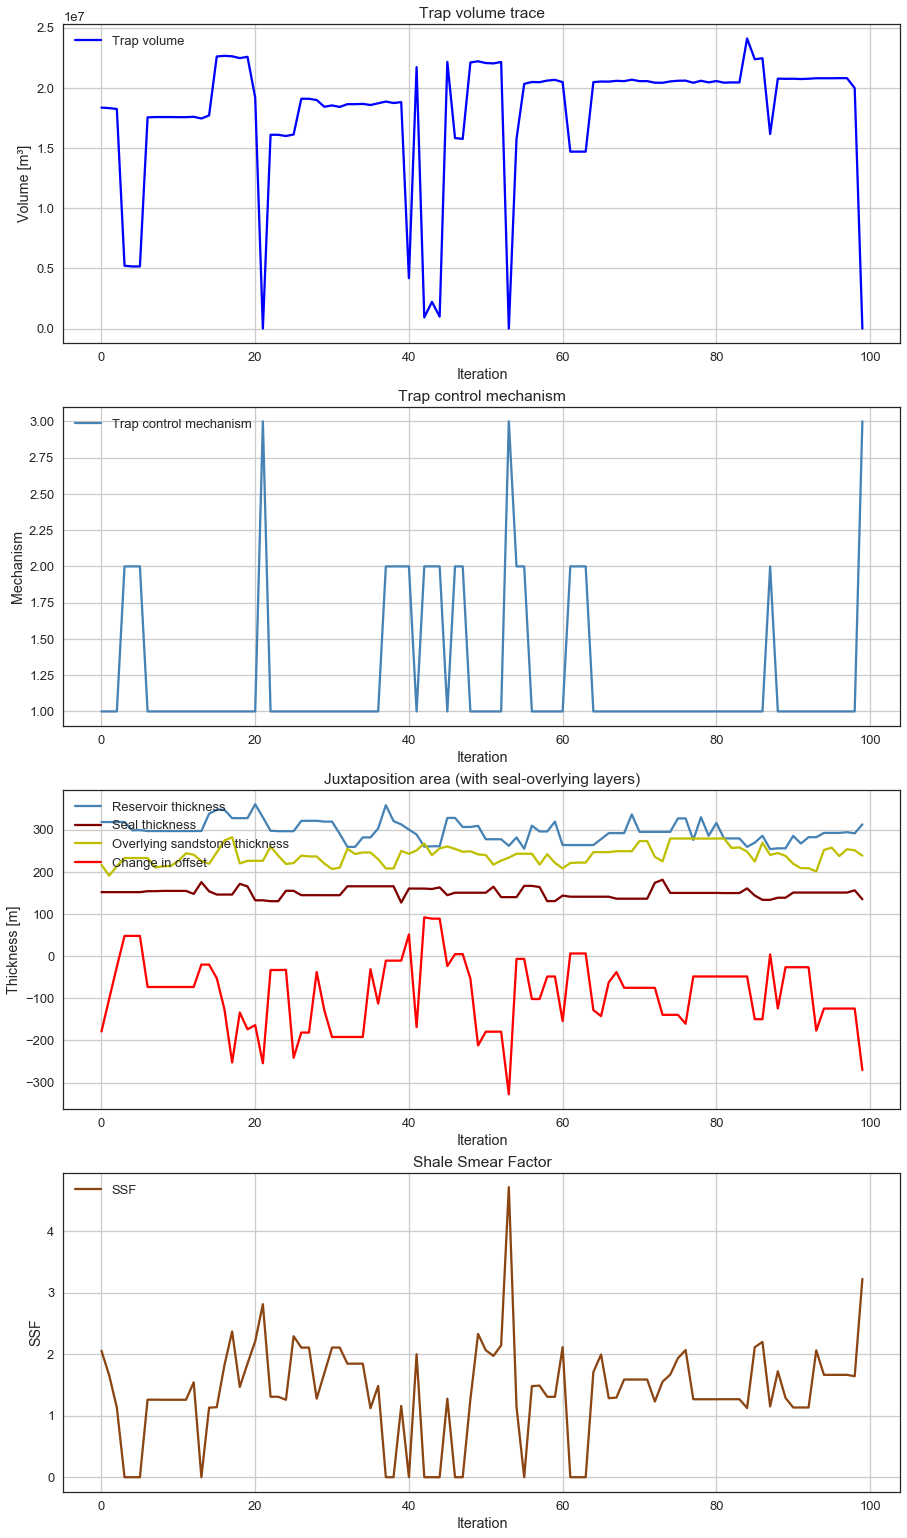

In [30]:
figsize(15,27)
fig, ax = plt.subplots(4, 1)

ax[0].plot(max_volume_trace_L, color='b', label='Trap volume')
ax[0].set_title('Trap volume trace')
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('Volume [m³]')
ax[0].legend(loc="upper left")
ax[0].grid()

ax[1].plot(trap_control_trace_L, color='steelblue', label='Trap control mechanism')
ax[1].set_title('Trap control mechanism')
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('Mechanism')
ax[1].legend(loc="upper left")
ax[1].grid()

ax[2].plot(fw_res_th_trace_L, color='steelblue', label='Reservoir thickness')
ax[2].plot(fw_seal_th_trace_L, color='maroon', label='Seal thickness')
ax[2].plot(fw_sec_res_th_trace_L, color='y', label='Overlying sandstone thickness')
ax[2].plot(offset_unc_trace_L*rescale_f, color='r', label='Change in offset')
ax[2].set_title('Juxtaposition area (with seal-overlying layers)')
ax[2].set_xlabel('Iteration')
ax[2].set_ylabel('Thickness [m]')
ax[2].legend(loc="upper left")
ax[2].grid()

ax[3].plot(SSF_trace_L, color='saddlebrown', label='SSF')
ax[3].set_title('Shale Smear Factor')
ax[3].set_xlabel('Iteration')
ax[3].set_ylabel('SSF')
ax[3].legend(loc="upper left")
ax[3].grid()

#ax[4].plot(over_jux_area_trace_L, color='g', label='Juxtaposition area')
#ax[4].set_title('Juxtaposition area (with seal-overlying layers)')
#ax[4].set_xlabel('Iteration')
#ax[4].set_ylabel('Area [m²]')
#ax[4].legend(loc="upper left")
#ax[4].grid()

C:\Users\Fabian\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


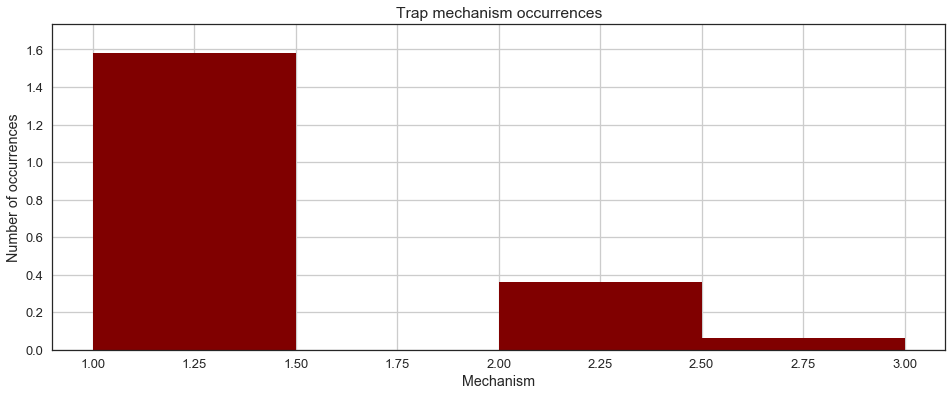

In [31]:
figsize(16, 6)
_hist1 = plt.hist(trap_control_trace_L, bins=4, normed=True, 
                  histtype="stepfilled", color = "maroon")
plt.title("Trap mechanism occurrences")
plt.legend(loc="upper right")
#plt.xticks(np.arange(0, np.max(_hist1[0])+1, np.max(_hist1[0])/10))
plt.grid()
plt.ylim(0, 1.1 * np.max(_hist1[0]))
plt.ylabel("Number of occurrences")
plt.xlabel("Mechanism")

NameError: name 'max_volume_trace' is not defined

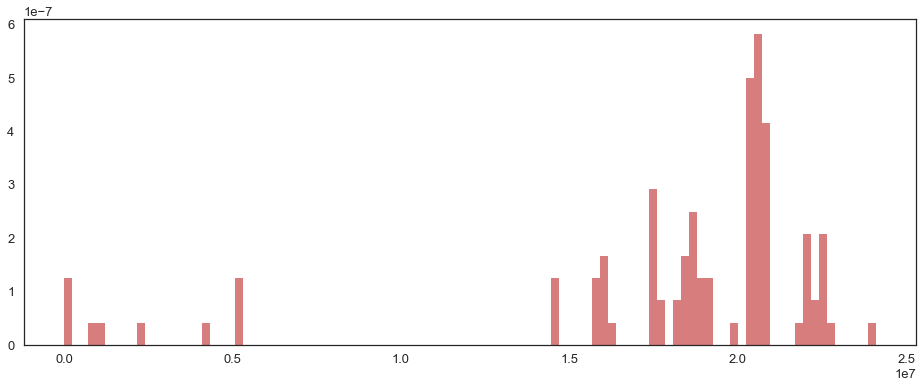

In [33]:
figsize(16, 6)

# Possibly mask away complete failures:
#volumes = max_volume_trace
#mask = volumes == 0
#masked_trace = volumes[~mask]
_hist1 = plt.hist(max_volume_trace, bins=100, normed=True, 
                  histtype="stepfilled",label="Prior volume distribution", color = "steelblue")
_hist2 = plt.hist(max_volume_trace_L, bins=100, normed=True, 
                  histtype="stepfilled",label="Prosterior volume distribution", color="indianred", alpha = 0.8)
_hist_scale = np.append(_hist1[0],_hist2[0])
plt.vlines(max_volume_trace.mean(), 0, 1.1 * np.max(_hist_scale), label="Prior volume mean", linestyles="-.", color = "steelblue")
plt.vlines(np.median(max_volume_trace), 0, 1.1 * np.max(_hist_scale), label="Prior volume median", linestyles=":", color = "steelblue")
plt.vlines(max_volume_trace_L.mean(), 0, 1.1 * np.max(_hist_scale), label="Posterior volume mean", linestyles="-.", color = "indianred")
plt.vlines(np.median(max_volume_trace_L), 0, 1.1 * np.max(_hist_scale), label="Posterior volume median", linestyles=":", color = "indianred")
plt.title("Prior trap volume distribution")
plt.legend(loc="upper right")
#plt.xticks(np.arange(0, np.max(_hist_scale)+1, np.max(_hist_scale)/10))
plt.grid()
plt.ylim(0, 1.1 * np.max(_hist_scale))
plt.xlabel("Volume [m³]")
plt.ylabel("Probability")

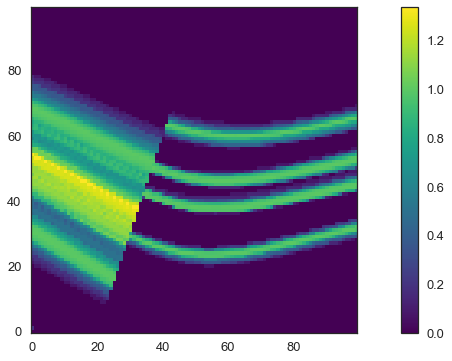

In [37]:
lith_blocks = []
for i in structural_model_trace_L[:]:
    #print(i[0][0])
    lith_blocks.append(i[0][0])

lith_prob = compute_prob_lith(lith_blocks)
i_entropy = calculate_ie_masked(lith_prob)

plt.imshow(i_entropy.reshape(resolution,resolution,resolution)[:,0,:].T, origin="lower", cmap="viridis")
plt.colorbar()

Bayes action (minimum) at risk r 0.50: 20480000.00 --- expected loss: 2400390.00
Bayes action (minimum) at risk r 0.75: 20416000.00 --- expected loss: 3427900.00
Bayes action (minimum) at risk r 1.00: 18856000.00 --- expected loss: 4299340.00
Bayes action (minimum) at risk r 1.25: 18640000.00 --- expected loss: 5061300.00
Bayes action (minimum) at risk r 1.50: 18408000.00 --- expected loss: 5799120.00


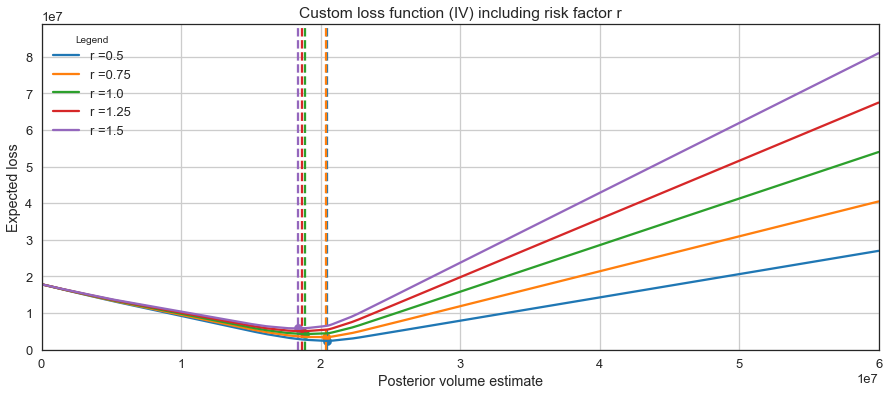

In [38]:
figsize(15, 6)

ax = plt.subplot(111)
expected_loss_s = lambda estimate_s, risk_s: volume_lossR(estimate_s, max_volume_trace_L, risk_s).mean()

for r in risks_s:
    _color = next(ax._get_lines.prop_cycler)
    loss = [expected_loss_s(e, r) for e in estimates_s]
    _min_vol = sop.fmin(expected_loss_s, -40, args=(r,),disp = False)
    if _min_vol < 0:
        _min_vol = 0
    plt.plot(estimates_s, loss, label = "r ="+str(r), color=_color['color'])
    plt.scatter(_min_vol, expected_loss_s(_min_vol,r), s = 70, color=_color['color'])#, label = "Bayes action r "+str(r))
    plt.vlines(_min_vol, 0, 10 * np.max(loss), color=_color['color'], linestyles="--")
    print("Bayes action (minimum) at risk r %.2f: %.2f --- expected loss: %.2f" % (r, _min_vol,\
                                                                              expected_loss_s(_min_vol,r)))
    
plt.title("""Custom loss function (IV) including risk factor r""")    
plt.legend(loc="upper left", scatterpoints=1, title="Legend")
#plt.vlines(0, 0, 1.1 * np.max(loss), label="zero score", linestyles="-")
#plt.vlines(res_score.mean(), 0, 1.1 * np.max(loss), label="posterior's mean", linestyles="-.")
#plt.vlines(np.median(res_score), 0, 1.1 * np.max(loss), label="score median", linestyles=":")
plt.xlabel("Posterior volume estimate")
plt.ylabel("Expected loss")
plt.xlim(estimates_s[0], estimates_s[-1])
plt.ylim(0,1.1 * np.max(loss))
plt.grid()


In [ ]:
#import graphviz
#pymc.graph.dag(model)

In [ ]:
#sys.path.append("/home/bl9/Theses/Risk\ analysis/Notebooks")
#graph = pymc.graph.graph(model)
#graph.write_png()

In [ ]:
#figsize(16, 9)
#
## No reduced uncertainty, different risks
#BA_before = np.zeros_like(risks_s)
#EL_before = np.zeros_like(risks_s)
#expected_loss = lambda estimate_s, risk_s: volume_lossR(estimate_s, masked_trace, risk_s).mean()
#
#counter = 0
#for r in risks_s:
#    loss = [expected_loss(e, r) for e in estimates_s]
#    _min_score = sop.fmin(expected_loss, -40, args=(r,),disp = False)
#    #print(_min_score)
#    if _min_score < 0:
#        _min_score = 0
#    plt.plot(estimates_s, loss, label = "Risk r "+str(r))
#    plt.scatter(_min_score, expected_loss(_min_score,r), s = 20, color = 'black')
#    #lt.vlines(_min_results, 0, 0.02, color = 'black', linestyles="--")
#    #print("Bayes action (minimum) at risk r %.2f: %.2f" % (r, _min_score))
#    BA_before[counter] = _min_score
#    EL_before[counter] = expected_loss(_min_score,r)
#    counter += 1
#

In [ ]:
# DETERMINATION OF LAYER THICKNESSES ON HANGING- AND FOOTWALL BASED ON VOXEL-COUNTING
#fault_block = fault_sol[0,0]
#lith_block = lith_sol[0,0]
#th_factor = scale_factor
#
## Finding fault tips, upper and lower
#def find_fault_tips(fault_block):
#    fault_reshape = fault_block.reshape(50,50,50)
#    upper_fault_tip = np.count_nonzero(fault_reshape[:,25,49])+1
#    lower_fault_tip = np.count_nonzero(fault_reshape[:,25,0])-1
#    return upper_fault_tip, lower_fault_tip
#    
## Footwall thicknesses
#def fw_thicknesses(lith_block, upper_fault_tip, th_factor):
#    lith_reshape = lith_block.reshape(50,50,50)
#    fw_reservoir_count = 0
#    fw_seal_count = 0 
#    fw_sec_res_count = 0 
#    for i in lith_reshape[upper_fault_tip,25,:]:
#        if i == (interp_data.get_formation_number()['Reservoir']):
#            fw_reservoir_count += 1
#            fw_reservoir_thickness = fw_reservoir_count * th_factor
#        elif i == (interp_data.get_formation_number()['Seal']):
#            fw_seal_count += 1
#            fw_seal_thickness = fw_seal_count * th_factor
#        elif i == (interp_data.get_formation_number()['SecondaryReservoir']):
#            fw_sec_res_count += 1
#            fw_sec_res_thickness = fw_sec_res_count * th_factor
#    return fw_reservoir_thickness, fw_seal_thickness, fw_sec_res_thickness
#
## Hanging wall thicknesses
#def hw_thicknesses(lith_block, lower_fault_tip, th_factor):
#    hw_reservoir_count = 0
#    hw_seal_count = 0 
#    hw_sec_res_count = 0 
#    for i in lith_reshape[lower_fault_tip,25,:]:
#        if i == (interp_data.get_formation_number()['Reservoir']):
#            hw_reservoir_count += 1
#            hw_reservoir_thickness = hw_reservoir_count * th_factor
#        elif i == (interp_data.get_formation_number()['Seal']):
#            hw_seal_count += 1
#            hw_seal_thickness = hw_seal_count * th_factor
#        elif i == (interp_data.get_formation_number()['SecondaryReservoir']):
#            hw_sec_res_count += 1
#            hw_sec_res_thickness = hw_sec_res_count * th_factor
#    return hw_reservoir_thickness, hw_seal_thickness, hw_sec_res_thickness

# DETERMINING THICKNESS BASED ON Z-POINT_POSITIONS IN INTERP_DATA

# Footwall at X = 1600 and Y = 1000
#def fw_thicknesses(interp_data):
#    res_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'Reservoir'
#    seal_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'Seal'
#    sec_res_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'SecondaryReservoir'
#    over_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'Overlying'
#    
#    rescale_f = interp_data.rescaling_factor
#    
#    fw_x_cond = interp_data.geo_data_res.interfaces['X'] == (interp_data.extent_rescaled['X'].values[1] - (1400/rescale_f))
#    y_mid = interp_data.geo_data_res.interfaces['Y'] == (interp_data.extent_rescaled['Y'].values[1] - (1000/rescale_f))
#    points_fw = interp_data.geo_data_res.interfaces[fw_x_cond]
#    points_fw = points_fw[y_mid]
#    
#    fw_rb_z = points_fw[res_bot_cond]['Z'].values*rescale_f
#    fw_sb_z = points_fw[seal_bot_cond]['Z'].values*rescale_f
#    fw_r2b_z = points_fw[sec_res_bot_cond]['Z'].values*rescale_f
#    fw_ob_z = points_fw[over_bot_cond]['Z'].values*rescale_f
#    
#    fw_res_th = np.abs(fw_sb_z-fw_rb_z)
#    fw_seal_th = np.abs(fw_r2b_z-fw_sb_z)
#    fw_sec_res_th = np.abs(fw_ob_z-fw_r2b_z)
#    return fw_res_th, fw_seal_th, fw_sec_res_th, fw_rb_z, fw_sb_z, fw_r2b_z, fw_ob_z
#
## Hanging wall at X = 600 and Y = 1000
#def hw_thicknesses(interp_data):
#    res_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'Reservoir'
#    seal_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'Seal'
#    sec_res_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'SecondaryReservoir'
#    over_bot_cond = interp_data.geo_data_res.interfaces['formation'] == 'Overlying'
#    
#    rescale_f = interp_data.rescaling_factor
#    
#    hw_x_cond = interp_data.geo_data_res.interfaces['X'] == (interp_data.extent_rescaled['X'].values[1] - (400/rescale_f))
#    y_mid = interp_data.geo_data_res.interfaces['Y'] == (interp_data.extent_rescaled['Y'].values[1] - (1000/rescale_f))
#    points_hw = interp_data.geo_data_res.interfaces[hw_x_cond]
#    points_hw = points_hw[y_mid]
#    
#    hw_rb_z = points_hw[res_bot_cond]['Z']
#    hw_sb_z = points_hw[seal_bot_cond]['Z']
#    hw_r2b_z = points_hw[sec_res_bot_cond]['Z']
#    hw_ob_z = points_hw[over_bot_cond]['Z']
#    
#    hw_res_th = np.abs(hw_sb_z.values-hw_rb_z.values)*rescale_f
#    hw_seal_th = np.abs(hw_r2b_z.values-hw_sb_z.values)*rescale_f
#    hw_sec_res_th = np.abs(hw_ob_z.values-hw_r2b_z.values)*rescale_f
#    return hw_res_th, hw_seal_th, hw_sec_res_th

# DETERMINING THICKNESS BASED ON Z-POINT_POSITIONS USING GEO_DATA
#res_bot_cond = geo_data.interfaces['formation'] == 'Reservoir'
#seal_bot_cond = geo_data.interfaces['formation'] == 'Seal'
#sec_res_bot_cond = geo_data.interfaces['formation'] == 'SecondaryReservoir'
#over_bot_cond = geo_data.interfaces['formation'] == 'Overlying'
#
#fw_x_cond = geo_data.interfaces['X'] == 1600
#y_mid = geo_data.interfaces['Y'] == 1000
#points_fw = geo_data.interfaces[fw_x_cond]
#points_fw = points_fw[y_mid]
## finding Z-values for each layer bottom
#fw_rb_z = points_fw[res_bot_cond]['Z']
#fw_sb_z = points_fw[seal_bot_cond]['Z']
#fw_r2b_z = points_fw[sec_res_bot_cond]['Z']
#fw_ob_z = points_fw[over_bot_cond]['Z']
#
#fw_res_th = np.abs(fw_sb_z.values-fw_rb_z.values)
#fw_seal_th = np.abs(fw_r2b_z.values-fw_sb_z.values)
#fw_sec_res_th = np.abs(fw_ob_z.values-fw_r2b_z.values)
#
#hw_x_cond = geo_data.interfaces['X'] == 600
#y_mid = geo_data.interfaces['Y'] == 1000
#points_hw = geo_data.interfaces[hw_x_cond]
#points_hw = points_hw[y_mid]
## finding Z-values for each layer bottom
#hw_rb_z = points_hw[res_bot_cond]['Z']
#hw_sb_z = points_hw[seal_bot_cond]['Z']
#hw_r2b_z = points_hw[sec_res_bot_cond]['Z']
#hw_ob_z = points_hw[over_bot_cond]['Z']
#
#hw_res_th = np.abs(hw_sb_z.values-hw_rb_z.values)
#hw_seal_th = np.abs(hw_r2b_z.values-hw_sb_z.values)
#hw_sec_res_th = np.abs(hw_ob_z.values-hw_r2b_z.values)
#
## Footwall
#def fw_thicknesses():
#    fw_x_cond = geo_data.interfaces['X'] == 1600
#    y_mid = geo_data.interfaces['Y'] == 1000
#    points_fw = geo_data.interfaces[fw_x_cond]
#    points_fw = points_fw[y_mid]
#    # finding Z-values for each layer bottom
#    fw_rb_z = points_fw[res_bot_cond]['Z']
#    fw_sb_z = points_fw[seal_bot_cond]['Z']
#    fw_r2b_z = points_fw[sec_res_bot_cond]['Z']
#    fw_ob_z = points_fw[over_bot_cond]['Z']
#    
#    fw_res_th = np.abs(fw_sb_z.values-fw_rb_z.values)
#    fw_seal_th = np.abs(fw_r2b_z.values-fw_sb_z.values)
#    fw_sec_res_th = np.abs(fw_ob_z.values-fw_r2b_z.values)
#
## Hanging wall
#def hw_thicknesses():
#    hw_x_cond = geo_data.interfaces['X'] == 600
#    y_mid = geo_data.interfaces['Y'] == 1000
#    points_hw = geo_data.interfaces[hw_x_cond]
#    points_hw = points_hw[y_mid]
#    # finding Z-values for each layer bottom
#    hw_rb_z = points_hw[res_bot_cond]['Z']
#    hw_sb_z = points_hw[seal_bot_cond]['Z']
#    hw_r2b_z = points_hw[sec_res_bot_cond]['Z']
#    hw_ob_z = points_hw[over_bot_cond]['Z']
#    
#    hw_res_th = np.abs(hw_sb_z.values-hw_rb_z.values)
#    hw_seal_th = np.abs(hw_r2b_z.values-hw_sb_z.values)
#    hw_sec_res_th = np.abs(hw_ob_z.values-hw_r2b_z.values)

In [ ]:
#@pymc.deterministic
#def fault_tips(fault_sol=pos_unc_model[1]):
#    fault = fault_sol[0,0]
#    return find_fault_tips(fault)    
#
#@pymc.deterministic
#def fw_th(lith_sol=pos_unc_model[0], upper_fault_tip=fault_tips[0]):
#    lith = lith_sol[0,0]
#    #print("FOOTWALL RES THICKNESS:", fw_thicknesses(lith, upper_fault_tip, th_factor=scale_factor)[0])
#    #print("FOOTWALL SEAL THICKNESS:", fw_thicknesses(lith, upper_fault_tip, th_factor=scale_factor)[1])
#    return fw_thicknesses(lith, upper_fault_tip, th_factor=scale_factor)
#
#@pymc.deterministic
#def hw_th(lith_sol=pos_unc_model[0], lower_fault_tip=fault_tips[1]):
#    lith = lith_sol[0,0]
#    return hw_thicknesses(lith, lower_fault_tip, th_factor=scale_factor)